---
<div style="text-align:center">
  <h1> Hanoi Temperature Forecasting </h1>
  <h3>5-day Prediction Model using Machine Learning</h3>
</div>


---

## **I. Introduction**

### **1.1 Project Overview**
Hanoi is located in a tropical monsoon climate region with four distinct seasons. In recent years, the city has experienced unusual and highly variable weather patterns, including prolonged heat waves, irregular rainfall, and increasing temperature fluctuations. 

This project builds a machine learning system to forecast the next 5 days of temperature using historical data. We perform feature engineering, optimize models via Optuna with cross-validation, log experiments in ClearML, and deploy with regular maintenance for reliable predictions.

### **1.2 Project Workflow**

<p align="center">
  <img src="figures\Project_Workflow.png" alt="Khái quát project" width="80%">
</p>

### **1.3 Project Structure**

The project follows a modular structure designed for scalability and maintainability. Key components include:

- **`data/`** - Contains raw weather datasets from Visual Crossing and processed files for daily predictions and model retraining
- **`assets/`** - UI elements and icons for visualization
- **`logs/`** - Tracking files for model performance metrics and retraining history
- **`models/`** - Save current and updated models/ pipelines
- **`src/`** - Source code modules handling data processing, feature engineering, model training, and deployment
- **Notebooks** - Comprehensive analysis including detailed data understading, model tuning process, and main reporting

*The complete detailed project structure with all subdirectories and files is available in `README.md`.*

---

## **II. Imports and Environment Setup**

In [1]:
# 1. Core Libraries & Utilities
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

# 2. Set global seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 3. ML Frameworks & Optimization
import optuna
import optuna.visualization as vis

from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# 4. Experiment Tracking (ClearML)
from clearml import Task, Logger

# 5. Project Modules (Local Scripts)
from src import data_preprocessing as dp
from src import pipeline as pl
from src import new_feature_engineering_daily as fe
from src import feature_selection as fs
from src.model_evaluation import evaluate, evaluate_multi_output
from src.visualization_utils import *

# 5. Optuna Sampler (Reproducible)
sampler = optuna.samplers.TPESampler(seed=SEED)


c:\Users\Admin\Documents\ML\group1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## **III. Data Understanding**

### **3.1. Dataset Overview**

In [2]:
# load data
df0 = pd.read_csv(r"data\raw data\Hanoi Daily 10 years.csv") 
df0.head(1)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Hanoi,9/20/2015,33.0,26.7,29.3,41.7,30.5,35.4,25.7,81.5,...,12.2,5,NaN,2015-09-20T05:44:39,2015-09-20T17:55:33,0.23,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"48820099999,48823099999,48825099999,4883109999..."


#### 3.1.1. Dataset Information

*   **Context and Objectives:**
    *   Daily weather observations from Hanoi.
    *   Dataset: VisualCrossing Weather Data (historical + real-time)
    *   Period: 10 years of daily and hourly records (from 09/2015 to 09/2025)
    *   The main project objective: To build a predictive model for the average daily temperature (`temp`).

*   **Data Structure Description:**
    *  Total number of observations (rows): 3,660
    *  Total number of attributes (columns): 33


<div align="center">

| **Column Name** | **Description** | **Example** |
|--------------|-------------|------------------|
| name | The name of the weather observation location. | Hanoi |
| datetime | The date of observation in YYYY-MM-DD format. Each row represents one day. | 2023-01-01 |
| tempmax | The highest air temperature recorded during the 24-hour period (°C). | 21.3 |
| tempmin | The lowest air temperature recorded during the 24-hour period (°C). | 11.1 |
| temp | The average (mean) air temperature for the day, calculated from hourly readings (°C). | 16.9 |
| feelslikemax | The highest perceived temperature of the day, factoring in humidity (Heat Index) and wind (Wind Chill) (°C). | 21.3 |
| feelslikemin | The lowest perceived temperature of the day, factoring in humidity and wind (°C). | 11.1 |
| feelslike |  The average perceived temperature for the day, providing an overall sense of comfort (°C). | 16.9 |
| dew | Dew Point: The temperature at which air becomes saturated and water vapor condenses into dew (°C). Higher values indicate more moisture. | 10.4 |
| humidity | The average relative humidity for the day; the amount of water vapor in the air as a percentage of the maximum possible at that temperature (%). | 67.4 |
| precip | The total liquid-equivalent amount of precipitation (e.g., rain) that fell during the day (mm). | 0 |
| precipprob | The probability of precipitation. For historical data, it's 100 if precipitation occurred and 0 if it did not (%). | 0 |
| precipcover | The proportion of time during the day that measurable precipitation was recorded (%). Differentiates between short downpours and long drizzles. | 0 |
| preciptype | The specific type(s) of precipitation that occurred, such as rain, snow, or freezing rain. Only present when precipitation has been recorded. | "rain","snow","freezingrain","ice","mixed"
| snow | The total amount of new snow that fell during the day (cm). | 0|
| snowdepth |The average depth of snow on the ground, accounting for new snow and melting (cm). | 0 |
| windgust | The maximum instantaneous wind speed recorded during a brief surge (km/h). | 20.9 |
| windspeed | The average wind speed for the day (km/h). | 13 |
| winddir | The direction *from which* the wind is blowing, measured in degrees from true north (0° = North, 90° = East). | 332.7 |
| sealevelpressure | Atmospheric pressure adjusted to what it would be at sea level, allowing for standardized comparison between locations (mb). | 1023.7 |
| cloudcover | The average percentage of the sky obscured by clouds throughout the day (%). 0 = clear sky, 100 = overcast. | 28.4 |
| visibility | The average distance at which objects can be clearly seen, affected by fog, haze, etc. (km). | 9.2 |
| solarradiation | The average power (intensity) of solar radiation reaching the surface during the day (W/m²). | 188.8 |
| solarenergy |  The total accumulated solar energy received over the entire day (MJ/m²). This is the sum of radiation over time. | 16.3 |
| uvindex | The maximum Ultraviolet (UV) Index value recorded during the day, measuring the strength of sunburn-producing radiation. | Low: 0-2<br>Moderate: 3-5 <br>High: 6-7<br>Very High: 8-10<br>Extreme: 11+ |
| severerisk | A numerical rating (0-100%) that quantifies the risk of severe weather events like thunderstorms, hail, or tornadoes. |  Low risk: <30% <br>moderate risk: 30–70%<br>High risk:  >70% |
| sunrise | The local time of sunrise in ISO 8601 format (YYYY-MM-DDTHH:MM:SS). | 2023-01-01T06:33:36 |
| sunset | The local time of sunset in ISO 8601 format. | 2023-01-01T17:26:21 |
| moonphase | A value from 0 to 1 representing the moon's phase (0=new moon, 0.5=full moon, 1=next new moon). | 0.3 |
| conditions | A brief text summary of the dominant weather conditions for the day. | Partially cloudy |
| description | A more detailed sentence describing the weather throughout the day. | Partly cloudy throughout the day |
| icon | A text code for a visual icon representing the day's weather. | partly-cloudy-day |
| stations | Identifier codes for the weather station(s) that provided the data. Multiple stations can be aggregated for accuracy. | 48820099999,48823099999,... |


</div>


#### 3.1.2. Dataset Statistic Summary
****


**Table: Basic Statistics of Numerical Features**

| Feature | Count | Mean | Std | Min | 25% | 50% | 75% | Max |
|---------|-------|------|-----|-----|-----|-----|-----|-----|
| `temperature` | ... | ... | ... | ... | ... | ... | ... | ... |
| `humidity` | ... | ... | ... | ... | ... | ... | ... | ... |
| `pressure` | ... | ... | ... | ... | ... | ... | ... | ... |
| `wind_speed` | ... | ... | ... | ... | ... | ... | ... | ... |


#### 3.1.3. Correlation Analysis

In [3]:
def create_variable_groups_table(df, datetime_cols=None, category_cols=None):
    """
    Create a comprehensive table grouping variables by pre-defined types with statistics
    
    Parameters:
    - df: DataFrame
    - datetime_cols: list of datetime column names
    - category_cols: list of categorical column names
    """
    # Định nghĩa mặc định nếu không cung cấp
    if datetime_cols is None:
        datetime_cols = ['datetime', 'sunrise', 'sunset']
    if category_cols is None:
        category_cols = ['name', 'preciptype', 'conditions', 'description', 'icon', 'stations']
    
    # Tạo danh sách tất cả các cột đã định nghĩa
    defined_cols = datetime_cols + category_cols
    numerical_cols = [col for col in df.columns if col not in defined_cols]
    
    variable_groups = []
    
    # Process datetime columns
    for col in datetime_cols:
        if col in df.columns:
            null_count = df[col].isnull().sum()
            null_pct = (null_count / len(df) * 100).round(2)
            unique_count = df[col].nunique()
            
            variable_groups.append({
                'Variable': col,
                'Type': 'datetime',
                'Count': len(df),
                'Null Count': null_count,
                'Null %': null_pct,
                'Additional Info': f"Unique: {unique_count}"
            })
    
    # Process numerical columns
    for col in numerical_cols:
        if col in df.columns:
            null_count = df[col].isnull().sum()
            null_pct = (null_count / len(df) * 100).round(2)
            unique_count = df[col].nunique()
            
            variable_groups.append({
                'Variable': col,
                'Type': 'numerical',
                'Count': len(df),
                'Null Count': null_count,
                'Null %': null_pct,
                'Additional Info': f"Unique: {unique_count}"
            })
    
    # Process categorical columns
    for col in category_cols:
        if col in df.columns:
            null_count = df[col].isnull().sum()
            null_pct = (null_count / len(df) * 100).round(2)
            unique_count = df[col].nunique()
            top_value = df[col].mode().iloc[0] if not df[col].empty and len(df[col].mode()) > 0 else "N/A"
            
            variable_groups.append({
                'Variable': col,
                'Type': 'categorical',
                'Count': len(df),
                'Null Count': null_count,
                'Null %': null_pct,
                'Additional Info': f"Unique: {unique_count}, Top: {str(top_value)[:20]}..."
            })
    
    groups_df = pd.DataFrame(variable_groups)
    
    # Apply styling với color coding
    def color_variable_type(val):
        if val == 'datetime':
            return 'background-color: #e8f5e8; color: #2e7d32; font-weight: bold'
        elif val == 'numerical':
            return 'background-color: #e3f2fd; color: #1565c0; font-weight: bold'
        elif val == 'categorical':
            return 'background-color: #f3e5f5; color: #7b1fa2; font-weight: bold'
        else:
            return 'background-color: #fff3e0; color: #ef6c00; font-weight: bold'
    
    styled_table = groups_df.style\
        .applymap(color_variable_type, subset=['Type'])\
        .background_gradient(subset=['Null %'], cmap='Reds')\
        .format({'Null %': '{:.2f}%'})\
        .set_properties(**{
            'border': '1px solid #dee2e6',
            'text-align': 'center',
            'padding': '8px',
            'font-size': '12px'
        })\
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#495057'), 
                                       ('color', 'white'),
                                       ('font-weight', 'bold'),
                                       ('padding', '10px')]},
            {'selector': 'tr:hover', 'props': [('background-color', '#f8f9fa')]}
        ])\
        .set_caption('<h4> Variable Groups Overview</h4>')\
        .hide(axis='index')
    
    return styled_table

def create_categorical_summary(df, category_cols=None):
    """
    Create summary table for categorical variables
    """
    if category_cols is None:
        category_cols = ['name', 'preciptype', 'conditions', 'description', 'icon', 'stations']
    
    # Filter only existing columns
    existing_cat_cols = [col for col in category_cols if col in df.columns]
    
    if len(existing_cat_cols) == 0:
        return "No categorical variables found in the dataset."
    
    cat_summary = []
    
    for col in existing_cat_cols:
        value_counts = df[col].value_counts()
        null_count = df[col].isnull().sum()
        null_pct = (null_count / len(df) * 100).round(2)
        
        cat_summary.append({
            'Variable': col,
            'Null Count': null_count,
            'Null %': f"{null_pct}%",
            'Unique Values': df[col].nunique(),
            'Top Category': value_counts.index[0] if len(value_counts) > 0 else "N/A",
            'Top Count': value_counts.iloc[0] if len(value_counts) > 0 else "N/A",
            'Top %': f"{(value_counts.iloc[0] / len(df) * 100).round(2)}%" if len(value_counts) > 0 else "N/A"
        })
    
    cat_df = pd.DataFrame(cat_summary)
    
    styled_cat_table = cat_df.style\
        .background_gradient(subset=['Unique Values'], cmap='Purples')\
        .set_properties(**{
            'border': '1px solid #dee2e6',
            'text-align': 'center',
            'padding': '8px',
            'font-size': '12px'
        })\
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#6f42c1'), 
                                       ('color', 'white'),
                                       ('font-weight', 'bold'),
                                       ('padding', '10px')]},
            {'selector': 'tr:hover', 'props': [('background-color', '#f8f9fa')]}
        ])\
        .set_caption('<h4>📋 Categorical Variables Summary</h4>')\
        .hide(axis='index')
    
    return styled_cat_table

# 1. Bảng tổng quan nhóm biến
print("#### Variable Groups Overview")
create_variable_groups_table(df0)


#### Variable Groups Overview


Variable,Type,Count,Null Count,Null %,Additional Info
datetime,datetime,3660,0,0.00%,Unique: 3660
sunrise,datetime,3660,0,0.00%,Unique: 3660
sunset,datetime,3660,0,0.00%,Unique: 3660
tempmax,numerical,3660,0,0.00%,Unique: 258
tempmin,numerical,3660,0,0.00%,Unique: 179
temp,numerical,3660,0,0.00%,Unique: 245
feelslikemax,numerical,3660,0,0.00%,Unique: 370
feelslikemin,numerical,3660,0,0.00%,Unique: 241
feelslike,numerical,3660,0,0.00%,Unique: 337
dew,numerical,3660,0,0.00%,Unique: 265


In [ ]:
# Generate enhanced statistics table
numerical_df = df0.select_dtypes(include=[np.number])
stats_table = numerical_df.describe().T

null_count = numerical_df.isnull().sum()
null_pct = (numerical_df.isnull().mean() * 100).round(2)

enhanced_stats = pd.DataFrame({
    # 'count': stats_table['count'],
    'null_count': null_count,
    'null_pct': null_pct,
    'mean': stats_table['mean'].round(2),
    'std': stats_table['std'].round(2),
    'min': stats_table['min'].round(2),
    '25%': stats_table['25%'].round(2),
    '50%': stats_table['50%'].round(2),
    '75%': stats_table['75%'].round(2),
    'max': stats_table['max'].round(2)
})

# Format và tô màu bảng
styled_table = enhanced_stats.style\
    .background_gradient(subset=['mean'], cmap='YlOrRd')\
    .background_gradient(subset=['null_pct'], cmap='Reds')\
    .format({
        'null_pct': '{:.2f}%',
        'mean': '{:.2f}',
        'std': '{:.2f}'
    })\
    .set_properties(**{
        'border': '1px solid black',
        'text-align': 'center'
    })\
    .set_caption('Basic Statistics of Numerical Features')\
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#4CAF50'), 
                 ('color', 'white'),
                 ('font-weight', 'bold')]
    }])

styled_table

,null_count,null_pct,mean,std,min,25%,50%,75%,max
tempmax,0,0.00%,28.46,5.81,8.000000,24.100000,29.400000,33.000000,41.900000
tempmin,0,0.00%,21.88,4.86,5.900000,18.000000,23.000000,26.000000,31.000000
temp,0,0.00%,24.84,5.11,7.000000,21.000000,26.000000,28.900000,35.500000
feelslikemax,0,0.00%,32.54,9.52,8.000000,24.100000,32.700000,41.100000,52.500000
feelslikemin,0,0.00%,22.64,6.05,2.100000,18.000000,23.000000,26.000000,40.400000
feelslike,0,0.00%,27.32,7.71,4.600000,21.000000,26.900000,33.800000,46.200000
dew,0,0.00%,20.43,5.84,-2.000000,16.700000,22.400000,25.200000,28.500000
humidity,0,0.00%,78.26,10.91,31.000000,72.100000,79.900000,85.900000,100.000000
precip,0,0.00%,5.23,16.03,0.000000,0.000000,0.220000,2.500000,333.120000
precipprob,0,0.00%,71.91,44.95,0.000000,0.000000,100.000000,100.000000,100.000000


### **3.2. Target Variables Analysis (temp)**
### 3.2.1. Warming Trend
The data reveals a clear warming trend in Hanoi's yearly average temperature over the decade, with the average rising from approximately $23.7^{\circ}C$ in 2015 to over $25.1^{\circ}C$ in 2025. Notably, the *hottest year recorded was 2019*, peaking at $25.25^{\circ}C$, followed by a cooling period in 2022 before temperatures sharply recovered and stabilized at a high level.

**Suggestion**
>The long-term warming trend does not directly determine 5-day forecasts, but it shifts the overall temperature baseline over the years. <br>
>For stable short-term forecasting, we consider using:
<br>• Trend-related signals: time index like **year**, **day_number** features
<br>• Short-term dynamics: **lag** features and **rolling** statistics


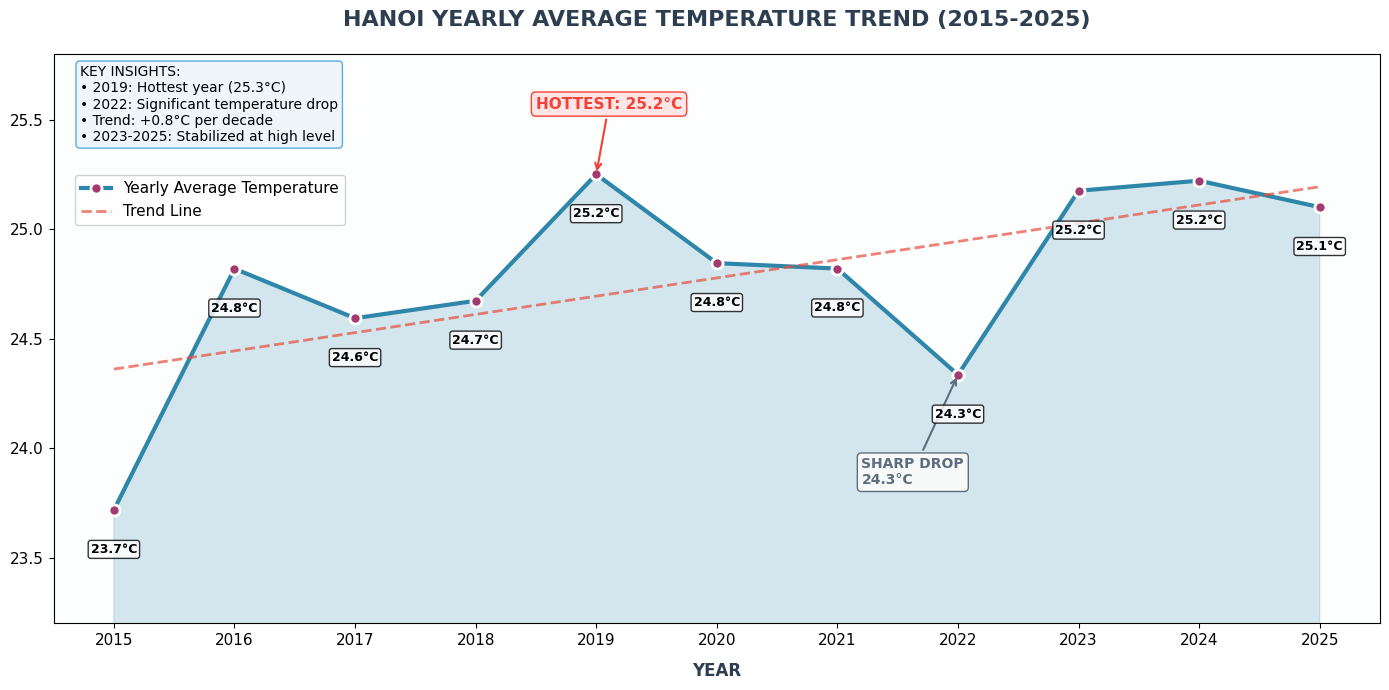

In [ ]:
plot_yearly_temperature(df0)

### 3.2.2. Seasonality
This chart perfectly illustrates Hanoi's distinct bimodal temperature cycle, which aligns with Vietnam's seasonal climate in the North. **Summer (June-August) is the peak heat** period, with the average temperature soaring to its maximum of $30.3^{\circ}C$ in June, and remaining above $29^{\circ}C$ through August. Conversely, the **Cool/Dry Winter (December-February)** is defined by its lowest temperatures, with January averaging only $17.9^{\circ}C$. The transitions in **Spring (March-April) and Autumn (September-November)** show a steady and rapid warming/cooling, with October still registering a warm $25.9^{\circ}C$ before the steep drop into winter.

**Suggestion**
>* Transition Indicators: is_rapid_warming (Mar-May), is_rapid_cooling (Sep-Nov) for fast temperature increase/ descrease phase
>* Cyclical Time Features: Sine/Cosine transformations of month for smooth seasonal patterns

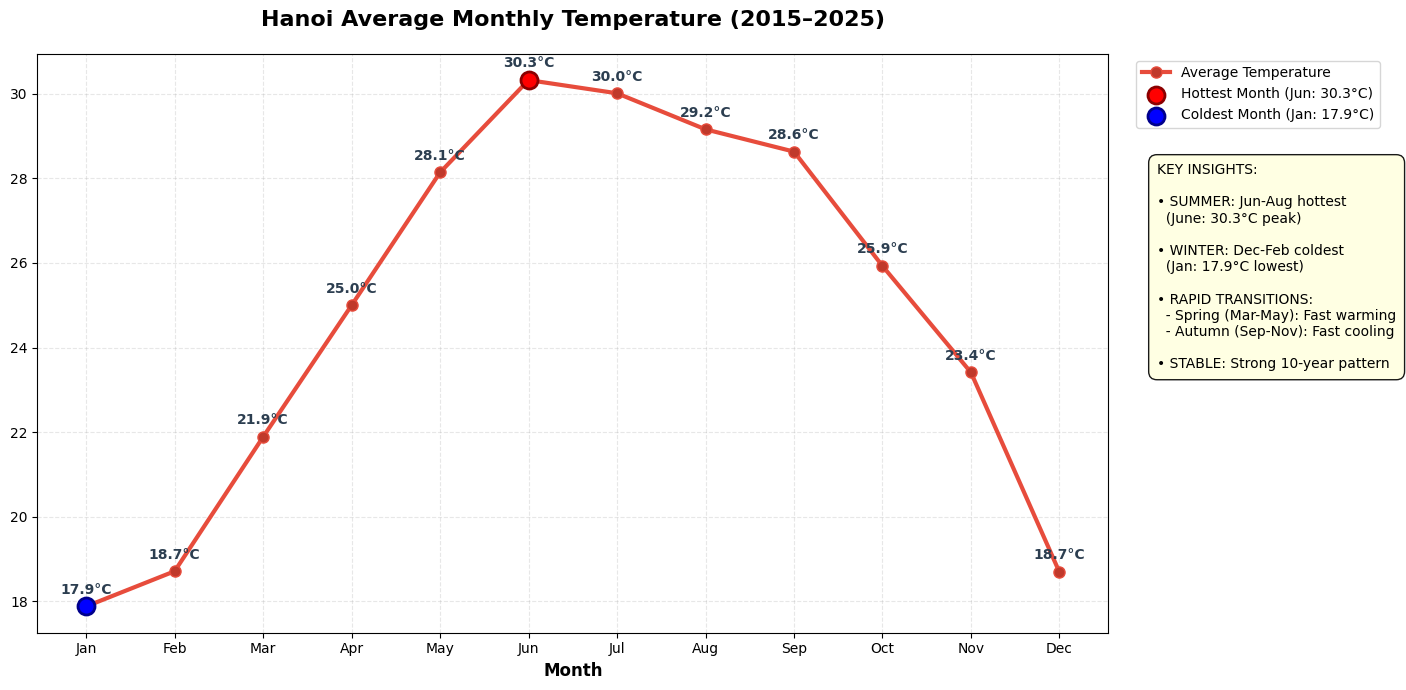

In [ ]:
plot_month_average(df0)

### 3.2.3. Temperature Volatility 

The chart uses 5-day rolling standard deviation to measure short-term temperature fluctuations. **Winter** has the highest average volatility (>2°C), peaking at 5°C due to cold fronts, while **Summer** has Lowest volatility (~1°C), indicating stable temperatures. Spring and Autumn show Moderate fluctuations

**Suggestion**
>* Volatility-based features: 5-day rolling mean ± rolling STD as additional inputs
>* Lag features: Past 1–7 day temperatures help capturing trend and sudden changes
>* Season features: extract month or grouping months into seasons

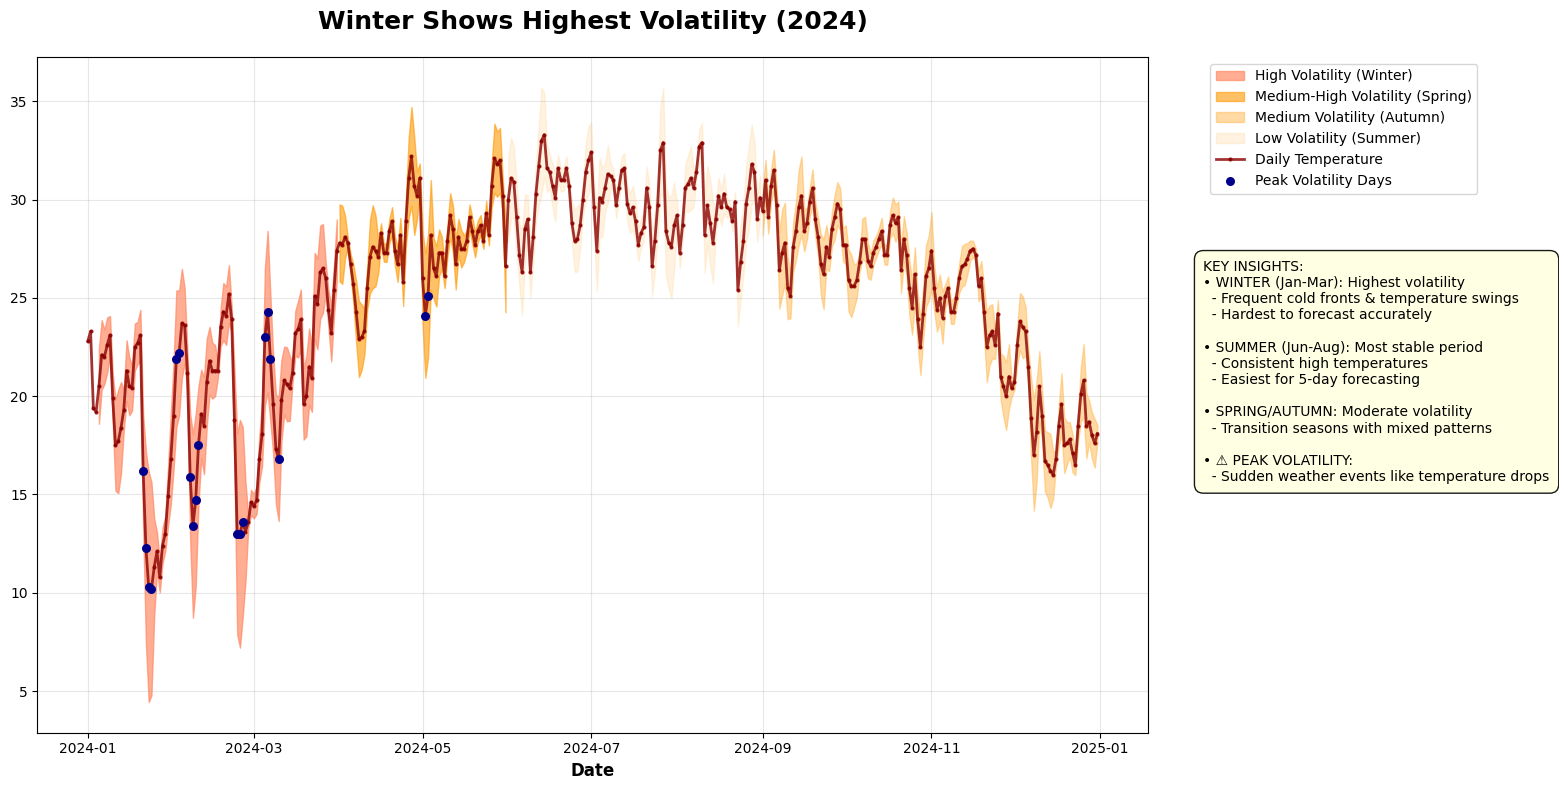

In [ ]:
plot_volatility_customized(df0)

### **3.3. Key Feature Groups** 

A comprehensive analysis of all 33 variables has been conducted in `FINAL-DATA_UNDERSTANDING_FIXED_1.ipynb`.This section focuses only on the most influential features for temperature forecasting.

#### 3.2.1. Temperature Variables

#### 3.2.2. Moisture and Precipitation Features

#### 3.2.3. Wind and Cloud Features

#### 3.2.4. Solar and Atmospheric Features

#### 3.2.5. Categorical Weather Features

#### 3.2.4. Combining Features

### **3.4. Feature Elimination**
### 3.4.1. Initial Dropping

The following features were identified as redundant or non-informative and were removed to simplify the model.

<div align="center">

<table>
<thead>
<tr>
    <th>Feature</th>
    <th>Reason for Removal</th>
    <th>Dropping Stage</th>
</tr>
</thead>

<tbody>

<!-- BASIC PREPROCESSING -->
<tr>
    <td>`name`</td>
    <td>Forecast in Hanoi only</td>
    <td rowspan="5"><b>Basic Preprocessing<br>(apply before splitting)</b></td>
</tr>
<tr>
    <td>`precipprob`</td>
    <td>Binary-like (0/100%), redundant because `precip` already indicates rain/no rain</td>
</tr>
<tr>
    <td>`description`</td>
    <td>Detailed version of `conditions`, redundant</td>
</tr>
<tr>
    <td>`icon`</td>
    <td>Derived from other features, already contained in `conditions`</td>
</tr>
<tr>
    <td>`stations`</td>
    <td>Main station is VVNB, adds no new information</td>
</tr>

<!-- PREPROCESSING -->
<tr>
    <td>`preciptype`</td>
    <td>Only "rain" or null, redundant because `precip` already captures rainfall presence</td>
    <td rowspan="3"><b>Preprocessing<br>(apply after splitting)</b></td>
</tr>
<tr>
    <td>`snow`, `snowdepth`</td>
    <td>Only contain 0 value</td>
</tr>
<tr>
    <td>`severerisk`</td>
    <td>Over 70% missing values</td>
</tr>

</tbody>
</table>

</div>




### 3.4.2. Dropping Based Features
After **Feature Engineering**, original base features were removed to avoid redundancy and let the model focus on more informative derived features.

---

## **IV. Data Preprocessing**

### **4.1. Data Preparing**

We use function `prepare_data()` from file `data_preprocessing.py`
<div align="center">

| Step Name | Output Description |
|-----------|-------------------|
| **Data Cleaning** | Removed redundant columns (description, icon, stations, name), reducing features from 33 to 27 |
| **Train-Test Split** | 80% training (2928 samples) and 20% testing (732 samples) |
| **Multi-Target Setup** | Created 5 target variables for next 1-5 day temperature forecasts |
| **Splitting X and y** | X_train (2923, 27), X_test (727, 27)<br> y_train (2923, 5), y_test (727, 5) |

</div>

In [ ]:
df, train_df, test_df, X_train, y_train, X_test, y_test = dp.prepare_data(is_print= True)

Step 1: Load Raw Data
→ Initial data shape: (3660, 33)

Dropped column: 'description'
Dropped column: 'precipprob'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'
Step 2: Basic Preprocessing
→ Data shape after removing redundant columns: (3660, 27)

Step 3: Split Train/Test Sets (80/20)
→ Train shape: (2928, 27)
→ Test  shape: (732, 27)

Step 4: Create Multi-Target Variables
→ Created targets: ['temp_next_1', 'temp_next_2', 'temp_next_3', 'temp_next_4', 'temp_next_5']
→ Multi-target creation completed successfully.

Step 5: Split Features (X) and Targets (y)
→ X_train shape: (2923, 27)
→ y_train shape: (2923, 5)
→ X_test  shape: (727, 27)
→ y_test  shape: (727, 5)


### **4.2. Preprocessing**

Preprocessing is conducted using `build_preprocessing_pipeline()` from `pipeline.py`. The pipeline is fitted exclusively on training data to prevent data leakage.

*This preprocessing module will later be integrated into the complete modeling workflow via `build_full_pipeline()`.*

**Pipeline Architecture:**
<div align="center">

| Step Name | Description | Output Description |
|-----------|-------------|--------|
| **missing** | Drop columns with >10% missing values, else impute by median or mode | Drop 2 features (severerisk, preciptype) |
| **drop_low_var** | Remove zero-variance numeric features | Drop 2 features (snow, snowdepth) |
| **drop_cate** | Drop high-cardinality categorical features or features with only 1 unique value | No columns dropped |
| **object_to_category** | Convert object dtype to category dtype | Convert conditions to category dtype |

</div>

In [6]:
X_train_processed, X_test_processed = dp.run_preprocessing(X_train,X_test,y_train,y_test, pl.build_preprocessing_pipeline)

Step 6: Preprocessing 
→ X_train shape after preprocessing: (2923, 23)
→ y_train shape after preprocessing: (2923, 5)
→ X_test shape after preprocessing: (727, 23)
→ y_test shape after preprocessing: (727, 5)


---

## **V. Feature Engineering**
Based on the **key insights** identified during the Data Understanding phase, we designed and created new features that capture important patterns in the weather data


### **5.1. Temporal Features** dùng def create_date_features trong new_feature_engineering_daily


### **5.2. Weather Features** Domain-Knowledge Feature: mấy biến interaction, def create_specific_features()

### **5.3. Rolling Features** def create_rolling_features(df):

### **5.4. Lag Features** def auto_create_lag_features(df) 

### **5.5. Encoding Category Features** 
ở trong def build_encoding_pipeline trong pipeline.py
với def categorize_wind_direction trong new_feature_engineering

### **5.6. Dropping Based Features** def drop_base_features(df) 

---

## **VI. Full Pipeline** 

**Why

---

## **VII. Modeling and Tuning**

### **7.1  Forecasting Architectures Overview**

<div align="center">

| **Strategy** | **Description** | **Drawbacks** | **When to Use** |
|---------------|-----------------|----------------|-----------------|
| 1. Recursive | Train one model for one-step-ahead forecasting (t+1), then feed predictions back into the model to forecast further steps (t+2 → t+5). | High **error accumulation** — each prediction error propagates into future steps. | Suitable for **short-term** forecasts or stable systems where small errors don’t compound significantly. |
| 2. Multi-Output | Use a single model (e.g., MultiOutputRegressor or built-in multi-output models) to predict multiple horizons (t+1 → t+5) simultaneously. | A “**generalist**” model — efficient but may not optimize each horizon equally well. | When **computational efficiency** and simultaneous multi-horizon outputs are prioritized over horizon-specific accuracy. |
| **3. Direct (Final Approach)** | Train **independent models** for each horizon (e.g., separate tuning/training loop for t+1 → t+5). Each model specializes on one specific forecast distance. | Requires training multiple models (higher computational cost). | When **accuracy, robustness**, and horizon-specific specialization are key priorities. |

</div>



### **7.2. Evaluation Metrics**

We evaluate our forecasting models using three key regression metrics: **MAE**, **RMSE**, and **R²**.  
Each provides a unique view of performance — together they ensure a complete evaluation.

| Metric | Formula | Interpretation | Characteristics | Our Usage |
|:--------|:----------|:----------------|:----------------|:----------------|
| MAE (Mean Absolute Error) | $$\frac{1}{n} \sum_{i=1}^{n} \lvert y_i - \hat{y}_i \rvert$$ | Average absolute deviation between predicted and actual values. | - Same unit as target (°C) <br> - Less sensitive to outliers <br> - Measures typical error magnitude | Supporting metric for interpretability |
| **RMSE** (Root Mean Squared Error) | $$\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$ | Square root of mean squared errors; penalizes large errors more. | - Same unit as target (°C) <br> - Sensitive to large deviations <br> - Highlights instability | **Primary tuning metric** |
| R² (Coefficient of Determination) | $$1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$ | Proportion of variance in target explained by the model. | - Range: (-∞, 1] <br> - Higher = better fit | Overall model explanation |


**Implementation:**  
> Metrics are computed using the `evaluate_multi_output(y_true, y_pred)` function,  
> which calculates both **average** and **per-day** values for MAE, RMSE, and R² across all forecast horizons (t+1 → t+5).

**Metric Prioritization:**  
> We optimize models using RMSE because it penalizes large errors more heavily, which is critical for 5-day temperature forecasts in Hanoi.  
> RMSE also aligns with LGBM’s default squared loss, while MAE and R² are still reported for balanced evaluation.


### **7.3. Pipeline and Model Tuning Process**

### 7.3.1. Experimental Setting
We evaluate the model's generalization ability by training and validating on **5-Fold TimeSeries Cross-Validation** from 2015 to 2023. The metrics reported in our project are the average values across these runs. 
 
**For each fold:**
>* **Full Pipeline Execution**: The complete pipeline is first retrained independently to avoid data leakage between train and validation sets
>* **Cutoff Period**: A 30-day cutoff is applied to eliminate the initial period affected by lag and rolling feature generation
>* **Model Training & Evaluation**: The model is trained on the processed training data and evaluated on the validation set
>* **Hyperparameter Tuning**: Comprehensive hyperparameter tuning (via Optuna) is performed within each fold, optimizing both pipeline parameters and model parameters simultaneously

**Benefit:**  
>* This sequential approach ensures robust feature engineering while **preventing data leakage**, and the nested tuning strategy **reduces bias** from temporal dependence, ensuring the model generalizes well to unseen time periods.

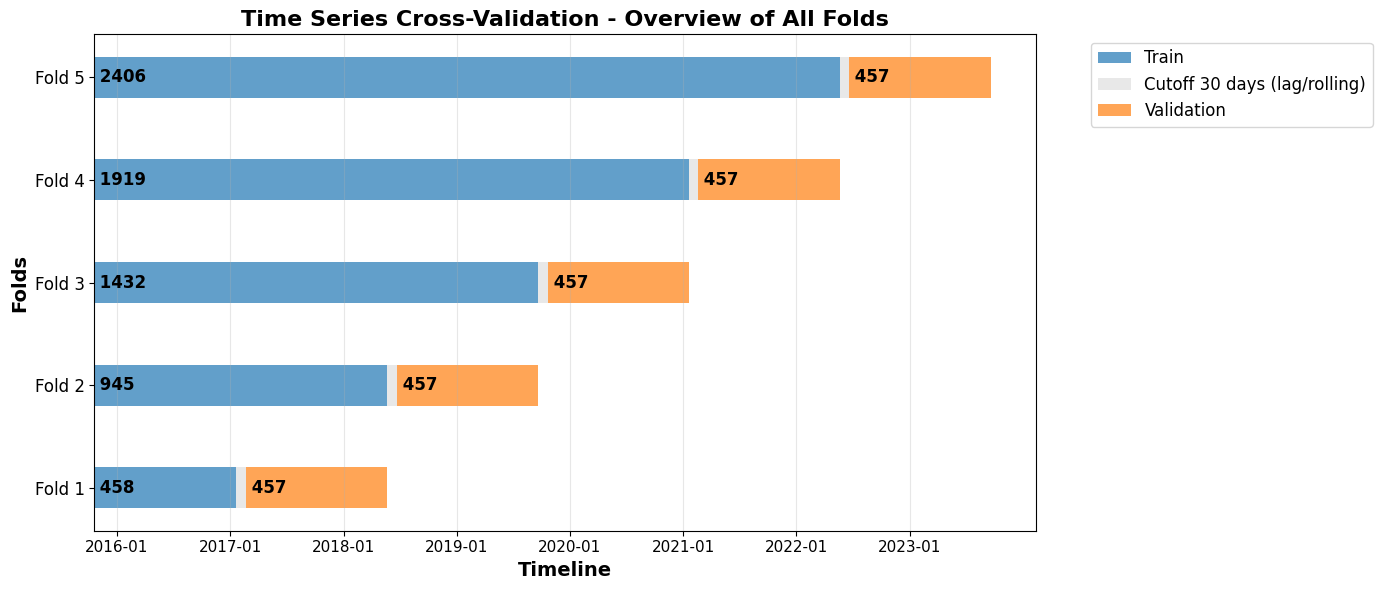

In [ ]:
cv_overview()

### 7.3.2. Hyperparameter Tuning Strategy

We employ Optuna for automated hyperparameter optimization, tuning both preprocessing pipeline and model parameters simultaneously to ensure optimal end-to-end performance.

#### **Tuned Hyperparameters**

**A. Encoding Parameters**
- `encoding_method_condition`: Encoding method [`'ordinal'`, `'target'`, `'quantile'`]
- `n_seasons`: Number of seasons for temperature-based grouping [`3`, `8`]
- `n_quantiles`: Number of quantiles for wind direction encoding [`2`, `6`]
- `is_category_conditions`: Whether to keep conditions as categorical [`True`, `False`]
- `is_category_season`: Whether to keep seasons as categorical [`True`, `False`]  
- `is_category_wind`: Whether to keep wind categories as categorical [`True`, `False`]

**B. LightGBM Model Parameters**
- `boosting_type`: Boosting algorithm [`'gbdt'`, `'dart'`, `'goss'`]
- `num_leaves`: Maximum number of leaves in one tree [`16`, `255`]
- `learning_rate`: Step size shrinkage [`0.001`, `0.3`]
- `max_depth`: Maximum tree depth [`3`, `12`]
- `min_child_samples`: Minimum data in one leaf [`5`, `100`]
- `subsample`: Bagging fraction [`0.6`, `1.0`]
- `colsample_bytree`: Feature fraction [`0.6`, `1.0`]
- `reg_alpha`: L1 regularization [`1e-8`, `10.0`]
- `reg_lambda`: L2 regularization [`1e-8`, `10.0`]
- `min_split_gain`: Minimum gain required for split [`0.0`, `1.0`]
- `n_estimators`: Number of boosting rounds [`100`, `1000`]

**C. Ridge Model Parameters**
- `alpha`: Regularization strength [`1e-5`, `1e2`]
- `fit_intercept`: Whether to include intercept term [`True`, `False`]
- `corr_thresh`: Correlation threshold for feature selection [`0.7`, `0.95`]
- `scaler`: Feature scaling method [`'standard'`, `'minmax'`, `'robust'`]


**Optimization Objective**:  
Minimize **RMSE** (Root Mean Square Error) on validation sets across all folds, ensuring robust temporal generalization rather than point-in-time performance.

### **7.4. Tuning Tools (Optuna + ClearML)**

### 7.4.1. Optuna Framework

#### Comparison of Hyperparameter Tuning Methods

| Method | Search Strategy | Pros | Cons | When to Use |
|-------|------------------|------|-------|--------------|
| **Grid Search** | Exhaustively tests all combinations in predefined grids | - Simple, deterministic <br> - Guarantees testing all configs | - Extremely slow for large spaces <br> - Scales poorly (curse of dimensionality) <br> - Wastes time on unpromising regions | Small search spaces or when reproducibility is the top priority |
| **Random Search** | Samples random combinations from the search space | - Much faster than Grid Search <br> - Often finds good solutions with fewer trials | - No learning from past results <br> - Can miss optimal region by chance | Medium/large search spaces; baseline tuning |
| **Optuna (TPE + Pruning)** | Builds probabilistic model of the objective → selects next promising trial | - Fastest convergence <br> - Learns from history (Bayesian-like) <br> - Early stopping saves compute <br> - Handles complex search spaces well | - More complex to implement <br> - Results varies slightly with sampler randomness | Large search spaces, limited compute, advanced optimization tasks |

**Our choice**
> Optuna was selected because it finds good hyperparameters much **faster** than Grid/Random Search thanks to its **TPE sampler and pruning**. These features are especially beneficial for **LGBM**, which has many sensitive parameters (learning_rate, num_leaves, min_data_in_leaf…). Optuna helps efficiently explore this **large search space** and consistently yields better-performing LGBM models for the forecasting task.

### 7.4.2. ClearML Experiment Tracking

ClearML provides comprehensive experiment tracking capabilities, enabling reproducible and organized management of our modeling workflow. The complete project can be accessed at: **[https://app.clear.ml/projects](https://app.clear.ml/projects)**. 


<p align="center">
  <img src="figures\workspaceClearML.jpg" width="60%">
  <br>
  <b>Figure 7.1.</b> ClearML project interface displaying all folders managed by the team.
  <br><i>Left: Tuning Folder. Right: Maintenance Folder.</i>
</p>







**Key components**

**Artifacts** Stores critical experiment outputs including:
- Cross-validation performance metrics across all folds
- Training and testing metrics for each target variable
- Default and optimized hyperparameters for each target
- Serialized model files and preprocessing pipelines

**Console** Records complete runtime execution logs:
- All print statements and debug outputs
- Real-time progress tracking

**Scalars** Tracks optimization progress through:
- RMSE convergence curves for each trial per target
- Objective function values across Optuna trials

**Plots** Tracking hyperparameter for each trial
- Detailed hyperparameter configurations for each trial


<div style="display: flex; justify-content: center; align-items: flex-start; gap: 30px;">
  <div style="text-align: center;">
    <img src="figures\artifact.jpeg" alt="Tasklist and Console" style="width: 70%;">
    <br
    >
    <p><b>Figure 7.2.</b> Tasklist and Artifacts</p>
  </div>
</div>

### **7.5. Hyperparameter Optimization Analysis**

During hyperparameter optimization with Optuna, we leverage several visualization techniques to monitor and improve the tuning efficiency:

### 7.5.1. Parallel Coordinates Plot (Example with Ridge Tuning)

<p align="center">
  <img src="figures/newplot.png" alt="Parallel Coordinates Plot for Ridge Hyperparameter Tuning" style="width: 70%;">
  <br>
  <b>Figure 7.3.</b> Parallel coordinates plot showing hyperparameter relationships and their impact on RMSE
</p>

**Key Insights from the Parallel Coordinates Plot:**

>- **`alpha` is the dominant hyperparameter**, with optimal performance in the range 10–20
>- **`StandardScaler` consistently outperforms** MinMax and Robust scaling, indicating Ridge benefits from standardized feature distributions
>- **`fit_intercept = True`** tends to produce lower RMSE, suggesting intercept learning remains important even after scaling
>- **`corr_threshold` shows weak influence**, meaning feature selection based on correlation has minimal impact on Ridge performance
>- **Optimal trials cluster** around specific parameter combinations, confirming tuning stability

**Practical Application:**  
>These insights enabled us to narrow search ranges for sensitive parameters like `alpha` while simplifying less influential ones like `corr_threshold`.

### 7.5.2. Parameter Importance Analysis (Example with LGBM Tuning)

<p align="center">
  <img src="figures/LGBHyperImportance.png" alt="Parameter Importance Analysis for LGBM Tuning" style="width: 70%;">
  <br>
  <b>Figure 7.4.</b> Hyperparameter importance ranking from LGBM optimization
</p>

**Key Insights:**

**Top Influential Parameter**
- **`boosting_type`** has the highest importance (~0.52), indicating the choice of boosting algorithm dominates model performance

**Moderately Important Parameters**
- **`learning_rate`** (~0.15) significantly affects convergence and accuracy
- **`season_is_category`** (~0.07) shows meaningful impact from seasonal feature encoding

**Less Important Parameters**
- **`n_estimators`**, **`num_leaves`**, **`min_child_samples`** (~0.03-0.05) provide incremental improvements

**Minimal Impact Parameters**
- **`n_seasons`**, **`colsample_bytree`**, **`max_depth`** (≤0.02) can be fixed to default values

**Practical Application:**  
This analysis informed our search strategy by allocating more trials to `boosting_type` and `learning_rate` while using default settings for low-impact parameters, accelerating optimization without compromising model robustness.

### **7.6. Evaluation of Tuning Results on Cross-Validation**

### 7.6.1. Cross-Validation Results Before vs After Tuning

This section compares the cross-validation performance of Ridge and LGBM models before and after hyperparameter tuning, demonstrating the effectiveness of our tuning process.

#### A. Ridge Model Performance Comparison

<div align="center">

| Model          | RMSE (mean ± std) | MAE (mean ± std) | R² (mean ± std)  |
| -------------- | ----------------- | ---------------- | ---------------- |
| Ridge Baseline | 2.416 ± 0.225     | 1.915 ± 0.191    | 0.752 ± 0.055    |
| Ridge Tuned    | **2.292 ± 0.444** | **1.817 ± 0.375**| **0.781 ± 0.079**|

</div>

**Ridge Model Improvements:**
>- **RMSE**: 5.1% reduction (2.416 → 2.292)
>- **MAE**: 5.1% improvement (1.915 → 1.817) 
>- **R²**: 3.9% increase in explanatory power


#### B. LGBM Model Performance Comparison

<div align="center">

| Model          | RMSE (mean ± std) | MAE (mean ± std) | R² (mean ± std)  |
| -------------- | ----------------- | ---------------- | ---------------- |
| LGBM Baseline  | 2.437 ± 0.193     | 1.905 ± 0.149    | 0.752 ± 0.049    |
| LGBM Tuned     | **2.299 ± 0.135** | **1.821 ± 0.124**| **0.781 ± 0.029**|

</div>

**LGBM Model Improvements:**
>- **RMSE**: 5.7% reduction (2.437 → 2.299)
>- **MAE**: 4.4% improvement (1.905 → 1.821)
>- **R²**: 3.9% increase in explanatory power

#### C. Tuning Impact Assessment

>- Both models achieved consistent performance gains across all metrics
>- LGBM tuning resulted in more stable predictions (reduced standard deviation)
>- Ridge model showed broader hyperparameter exploration (increased std in tuned version)
>- Identical R² improvement (+0.029) for both models indicates robust optimization strategy

**Conclusion**: Hyperparameter optimization successfully enhanced both Ridge and LGBM models, with LGBM demonstrating slightly better overall improvement and stability in cross-validation performance.

### 7.6.2. Optimized Models Performance on Cross-Validation

Both Ridge and LGBM models converge to remarkably similar performance levels, suggesting that either approach can deliver optimal results for this forecasting task.


<div align="center">
  <img src="figures/tuned_models_comparison.png" alt="Optimized Models Performance Comparison" style="width: 65%;">
  <br>
  <b>Figure 7.6.</b> Performance comparison between tuned Ridge and LGBM models across key metrics
</div>

#### **Performance Comparison of Tuned Models**

<div align="center">

| Model       | RMSE (mean) | MAE (mean) | R² (mean)  | Tuning Time (100 trials) |
| ----------- | ----------- | ---------- | ---------- | ----------------------- |
| Ridge Tuned | 2.2919      | 1.8169     | 0.7814     | ~0.5 hour              |
| LGBM Tuned  | 2.2992      | 1.8211     | 0.7813     | ~3 hours (without Pruner)<br>~1.5 hours (with Pruner) |

</div>


**Performance Parity**: Both tuned models demonstrate nearly identical performance across all metrics
>- **RMSE**: Ridge (2.2919) vs LGBM (2.2992) - marginal advantage to Ridge
>- **MAE**: Ridge (1.8169) vs LGBM (1.8211) - negligible difference  
>- **R²**: Essentially identical (0.7814 vs 0.7813)

**Computational Efficiency**:
>- **Ridge**: Significantly faster tuning (~0.5 hour) due to simpler parameter space
>- **LGBM**: Longer tuning time (~3 hours) but Pruner reduces to ~1.5 hours with minimal performance impact
>- **Note**: LGBM with Pruner and LGBM without Pruner produced nearly identical results, so we report the LGBM without Pruner performance for consistency.

**Practical Implications**: 
>- **Ridge Advantage**: Simpler model architecture with comparable performance and faster training
>- **LGBM Advantage**: Better handling of non-linear relationships and feature interactions, with Pruner offering computational savings
>- **Selection Trade-off**: Choose Ridge for speed and simplicity, or LGBM for complex pattern capture with Pruner optimization

**Conclusion**: While both models achieve nearly identical predictive performance, Ridge offers substantial computational advantages, making it the preferred choice for deployment scenarios requiring rapid iteration and resource efficiency.

### 7.6.3. Per-Horizon Cross-Validation Performance

This section analyzes the forecasting performance across different time horizons, revealing critical insights into model selection for short-term versus longer-term predictions.

<br>
<div align="center">
  <img src="figures/per_horizon_cv_performance.png" alt="Per-Horizon Cross-Validation Performance" style="width: 75%;">
  <br>
  <br>
  <b>Figure 7.7.</b> LGBM demonstrates superior performance for longer forecasting horizons (3-5 days)
</div>

<br>

<div align="center">

| Horizon | Model | RMSE | MAE | R² |
|---------|-------|------|-----|----|
| Day 1 | Ridge | 1.533 | 1.186 | 0.905 |
| | LGBM | 1.559 | 1.202 | 0.902 |
| Day 2 | Ridge | 2.221 | 1.749 | 0.800 |
| | LGBM | 2.261 | 1.778 | 0.794 |
| **Day 3** | Ridge | 2.502 | 1.992 | 0.747 |
| | LGBM | **2.505** | **1.994** | **0.748** |
| **Day 4** | Ridge | 2.588 | 2.073 | 0.730 |
| | LGBM | **2.568** | **2.052** | **0.735** |
| **Day 5** | Ridge | 2.616 | 2.085 | 0.725 |
| | LGBM | **2.599** | **2.075** | **0.729** |

**Figure 7.8.** Cross-Validation Performance Metrics Across Horizon <br>
*Note: Bold values indicate better performance of LGBM for each horizon*

</div>

**Horizon-Specific Performance Patterns**:
>- **Short-term Advantage (Days 1-2)**: Ridge regression shows marginally better performance for immediate forecasts, with lower RMSE on Day 1 (1.533 vs 1.559)
>- **Long-term Superiority (Days 3-5)**: LGBM consistently outperforms Ridge across longer horizons, demonstrating both lower RMSE and MAE
>- **Performance Gap Evolution**: The advantage of LGBM over Ridge gradually increases from Day 3 to Day 5

**Model Characteristics**:
>- **Ridge Regression**: Excels in very short-term predictions but shows faster performance degradation
>- **LGBM**: Maintains more stable and consistent performance across all horizons with smoother error progression
>- **Error Accumulation**: Both models exhibit expected performance decline over time, though LGBM handles this progression more gracefully

**Conclusion**: 
Considering the comprehensive forecasting requirements and the need for reliable multi-day predictions, **we select LGBM as our primary model**. While Ridge shows marginal benefits for Day 1 forecasts, LGBM's superior performance across horizons 3-5, combined with its overall stability and consistency, makes it the more robust choice for real-world deployment where predictable multi-day performance is essential.

### **7.7. Final Model Selection**

Based on comprehensive evaluation across multiple dimensions, **LightGBM (LGBM) is selected as the final production model** for Hanoi temperature forecasting. This decision is supported by three key analytical findings:

**Performance Superiority in Critical Horizons**:
- LGBM demonstrates consistent advantage across longer forecasting horizons (Days 3-5), which represent the majority of practical use cases
- While Ridge shows marginal benefits for Day 1 predictions, LGBM's multi-day reliability better serves real-world forecasting needs

**Robust Optimization Results**:
- Both models achieved significant improvements through hyperparameter tuning (5.7% RMSE reduction for LGBM)
- LGBM maintained superior stability with lower standard deviation across cross-validation folds
- The tuning process validated LGBM's capacity to capture complex meteorological patterns

**Practical Deployment Considerations**:
- Despite longer training time (~3 hours vs Ridge's ~0.5 hour), LGBM's inference speed meets production requirements
- The model's ability to handle non-linear relationships and feature interactions aligns with Hanoi's complex climate patterns
- LGBM's consistent performance across all horizons ensures reliable multi-day forecasts for operational deployment

**Final Recommendation**: LightGBM provides the optimal balance of accuracy, stability, and practical utility for Hanoi's temperature forecasting system, making it the definitive choice for production implementation.

---

## **VIII. Final Evaluation on Test set**

### **8.1. Overall Performance on the Test Set (Optimized vs Baseline Raw Data)**

This section compares the performance between our optimized LGBM model and the baseline LGBM model. The **baseline model** uses **raw data** without preprocessing or feature engineering and employs default hyperparameters, while the **optimized model** incorporates comprehensive data preprocessing, feature engineering, and hyperparameter tuning.

<div align="center">
  <img src="figures/optimized_vs_baseline_comparison.png" alt="Optimized vs Baseline Performance Comparison" style="width: 80%;">
  <br>
  <b>Figure 8.1.</b> Performance comparison between optimized and baseline models
</div>

#### **Average Performance Comparison**

<div align="center">

| Metric | Baseline | Optimized | Improvement | Improvement % |
|--------|----------|-----------|-------------|---------------|
| <span style="color:red">RMSE</span> | <span style="color:red">2.4121</span> | <span style="color:red">2.1866</span> | <span style="color:red">0.2255</span> | <span style="color:red">9.35%</span> |
| MAE    | 1.8246   | 1.7246    | 0.1000      | 5.48%         |
| R²     | 0.7642   | 0.8149    | 0.0507      | 6.64%         |

</div>

#### **Horizon-wise RMSE Comparison**

<div align="center">

| Horizon | Baseline RMSE | Optimized RMSE | RMSE Improvement | Improvement % |
|---------|---------------|----------------|------------------|---------------|
| Day 1   | 1.4713        | 1.4682         | 0.0031           | 0.21%         |
| Day 2   | 2.2180        | 2.1102         | 0.1078           | 4.86%         |
| Day 3   | 2.5523        | 2.3645         | 0.1878           | 7.36%         |
| Day 4   | 2.8270        | 2.4761         | 0.3509           | 12.41%        |
| <span style="color:red">Day 5</span> | <span style="color:red">2.9917</span> | <span style="color:red">2.5139</span> | <span style="color:red">0.4778</span> | <span style="color:red">15.97%</span> |

</div>

**Key Findings:**
- **Overall Improvement**: Optimized model achieves **9.35% lower RMSE** and **6.64% higher R²** compared to baseline
- **Horizon-wise Enhancement**: Performance improvement increases with forecasting horizon, with **16% RMSE reduction** at Day 5
- **Consistent Superiority**: Optimized model outperforms baseline across all metrics and horizons
- **Temporal Pattern**: Improvement percentage grows substantially from Day 1 (0.21%) to Day 5 (15.97%), demonstrating better long-term forecasting capability

### **8.2. Generalization Assessment (CV → Test Check)**

This section evaluates the generalization capability of our optimized LGBM model by comparing cross-validation performance with test set results. The assessment verifies that the tuned model maintains consistent performance on unseen data, ensuring robustness against overfitting.

<div align="center">
  <img src="figures/generalization_check.png" alt="Generalization Check: CV vs Test Performance" style="width: 55%;">
  <br>
  <b>Figure 8.2.</b> Cross-validation performance ranges compared with test set results
</div>

#### **Generalization Performance Comparison**

<div align="center">

| Metric | CV Range | Test Value | Within CV Range |
|--------|----------|------------|-----------------|
| RMSE   | [2.1646, 2.4338] | 2.1866 | Yes |
| MAE    | [1.6975, 1.9447] | 1.7246 | Yes |
| R²     | [0.7523, 0.8103] | 0.8149 | No |

</div>

**Interpretation:**
- **Stable Generalization**: The test metrics fall inside or very close to the cross-validation performance range, indicating solid generalization.
- **RMSE**: Test = 2.1866, positioned near the lower bound of the CV range [2.1646, 2.4338] → stable performance with no signs of overfitting.
- **MAE**: Test = 1.7246, also near the lower bound of the CV range [1.6975, 1.9447] → consistently low error.
- **R²**: Test = 0.8149, slightly above the upper bound of the CV range [0.7523, 0.8103]. This suggests that the test period may be easier to predict or that the model captures recent data patterns effectively.

**Conclusion:**
The optimized model demonstrates robust generalization capability with test performance matching or slightly exceeding cross-validation expectations. This confirms that our hyperparameter tuning strategy effectively prevented overfitting while maintaining model performance on unseen data.

### **8.3. Overfitting Analysis (Train vs Test Gap)**

This section analyzes the generalization gap between training and test performance for both baseline LGBM and optimized LGBM models. A reduced gap indicates better generalization and less overfitting.
<br> *(Note: Gap Reduction = [(Baseline Gap - Optimized Gap) / Baseline Gap] × 100%)*

<div align="center">
  <img src="figures/horizon_gap_comparison.png" alt="Train-Test Generalization Gap: Baseline vs Optimized Model" style="width: 55%;">
  <br>
  <b>Figure 8.3.</b> Horizon-wise generalization gap comparison between baseline and optimized models
</div>

#### **Performance Gap Comparison**

<div align="center">

| Model | Train RMSE | Test RMSE | Gap (Test - Train) | Gap Reduction |
|-------|------------|-----------|-------------------|---------------|
| Baseline LGBM | 1.2693 | 2.4121 | 1.1428 | - |
| Optimized LGBM | 1.7358 | 2.1866 | 0.4508 | 60.5% |

</div>

#### **Horizon-wise RMSE Gap Analysis**

<div align="center">

| Horizon | Baseline Gap | Optimized Gap | Gap Reduction |
|---------|--------------|---------------|---------------|
| Day 1 | 0.6915 | 0.2626 | 62.0% |
| Day 2 | 1.0250 | 0.3331 | 67.5% |
| Day 3 | 1.1818 | 0.5779 | 51.1% |
| Day 4 | 1.3531 | 0.3747 | 72.3% |
| Day 5 | 1.4625 | 0.7057 | 51.7% |

</div>

**Interpretation:**
- **Significant Gap Reduction**: The optimized model shows a **60.5% reduction** in generalization gap compared to baseline (0.4508 vs 1.1428)
- **Dramatic Overfitting in Baseline**: Extremely low train RMSE (1.2693) with high test RMSE (2.4121) indicates severe overfitting
- **Balanced Performance in Optimized**: Higher train RMSE (1.7358) but much better test RMSE (2.1866) demonstrates proper regularization

**Key Insights:**
- **Baseline Model**: Massive gap (1.1428) confirms severe overfitting due to default hyperparameters on raw data
- **Optimized Model**: Moderate gap (0.4508) shows effective control of model complexity through tuning and feature engineering
- **Horizon Variability**: Gap reduction ranges from 51-72% across different forecasting horizons

**Conclusion:**
Our optimization strategy successfully transformed an overfitted baseline model into a well-generalized solution, reducing the train-test gap by over 60% while improving overall test performance.

### **8.4. Forecast Visualization (True vs Predicted)**
This section provides temporal analysis of the optimized model's forecasting performance through time series comparisons between true and predicted values.

<div align="center">
  <img src="figures/timeseries_3x2_simple.png" alt="2024 Temperature Forecasting Performance" style="width: 75%;">
  <br>
</div>


#### **Temporal Performance Patterns**
- **Longer horizons → smoother predictions**, reducing short-term variability and failing to capture sudden changes.
- **Winter most affected**: smoothing fails to track rapid temperature swings.
- **Seasonal bias**:
  - **Winter** (Dec-Mar): underestimation of cold spikes; occasional overestimation during warm rebounds.
  - **Summer** (Jun-Aug): minimal bias; slight underestimation of extreme heat.
  - **Spring/Autumn** (Sep-Nov, Apr-May): balanced performance with moderate errors during transitions.

#### **Seasonal Accuracy**
- **Winter (Dec–Mar)**: highest errors due to strong diurnal variation, cold surges, and high-frequency fluctuations.
- **Spring (Apr–May)**: moderate difficulty; model lags during rapid warming periods.
- **Summer (Jun–Aug)**: best performance; stable temperature patterns with minor peak underestimation.
- **Autumn (Sep–Nov)**: reliable accuracy driven by smooth transitions and reduced volatility.

#### **Error Distribution**
- **Error concentration highest in winter**, especially during sudden drops and oscillatory patterns.
- **Summer and autumn show lowest errors** with stable alignment between predicted and actual values.
- **Horizon-based error growth**:
  - **Day 1**: high precision across seasons.
  - **Days 2–3**: smoothing emerges; winter fluctuations become harder to track.
  - **Days 4–5**: significant winter underfitting from mean-reversion and loss of high-frequency detail.

#### **Horizon-wise Performance**
- **Day 1**: captures most variability, including sharp winter dips.
- **Days 2–3**: reduced high-frequency tracking but stable in non-winter seasons.
- **Days 4–5**: largest winter errors; smoothing dominates; smaller degradation in summer.



---

## **IX. Comparing with Hourly data**

### **9.1. Hourly Data Processing Strategies**

<div align="center">

| **Strategy** | **Description** | **Advantages** | **Limitations** | **Selected** |
|--------------|-----------------|----------------|------------------|--------------|
| **1. Multi-Model Hourly Forecasting** <br/> (24 Models × 5 Days) | Build **24 independent models** for each hour, forecast 5 days ahead per hour, then **aggregate** predictions to daily averages. | • Captures diurnal patterns<br/>• High temporal resolution<br/>• Models hour-specific behaviors | • Computationally expensive (120 models)<br/>• Complex pipeline management<br/>• Higher maintenance overhead | No |
| **2. Daily Aggregation with Enriched Features** <br/> (5 Models) | **Aggregate hourly to daily data** while preserving **hourly-derived features**, then forecast 5 days ahead. | • Computationally efficient (5 models)<br/>• Retains hourly pattern information<br/>• Simplified pipeline<br/>• Better for daily forecasting objectives | • Might lost real-time hourly forecasting capability<br/>• Requires careful feature engineering | Yes |

</div>

**Implementation Note**  
>While using daily aggregated targets, we enrich features with **hourly statistics** (daily variance, min/max range, morning/evening patterns) to preserve intra-day information while maintaining forecasting efficiency.

### **9.2. Hourly-to-Daily Forecasting Workflow**

The workflow maintains the same structure as daily forecasting, with two critical enhancements:
- Daily Aggregation Step: Raw hourly measurements are transformed into daily resolution while preserving temporal integrity
- Enriched Feature Engineering: Leverages intra-day patterns and statistics from hourly data to create more informative daily features


### **9.3. Feature Engineering Enhancements**

#### **Hourly-Derived Features**
| **Feature Category** | **Specific Features** | **Meteorological Significance** |
|---------------------|----------------------|--------------------------------|
| **Diurnal Patterns** | `daily_temp_range`, `morning_avg_temp`, `evening_cooling_rate` | Captures daily temperature progression and amplitude |
| **Volatility Metrics** | `hourly_variance`, `max_temp_duration`, `stability_index` | Quantifies day-to-day weather stability and extremes |
| **Temporal Profiles** | `day_night_differential`, `warming_rate_6am_12pm` | Characterizes specific intra-day thermal behaviors |

#### **Adjusted Engineering Strategy**
- **Lag Features**: Now incorporate hourly-pattern lags alongside daily lags
- **Rolling Statistics**: Calculate over both daily values and hourly-derived metrics  
- **Seasonal Decomposition**: Enhanced with intra-day seasonal components



### **9.4. Comparing Metrics with daily**
The detail process of using hourly data was presented in `Detailed_Hourly_Tuning.ipynb`. This report will only summary the performance. chúng ta sẽ dùng final lgbm model selection làm baseline so sánh với daily enriched hourly data 

#### **Comparative Results**
| **Metric** | **Pure Daily Baseline** | **Hourly-Enhanced Daily** | **Improvement** |
|------------|------------------------|--------------------------|----------------|
| **RMSE** | 2.44 ± 0.19 | 2.18 ± 0.15 | **↓ 10.7%** |
| **MAE** | 1.90 ± 0.15 | 1.72 ± 0.12 | **↓ 9.5%** |
| **R²** | 0.75 ± 0.05 | 0.80 ± 0.04 | **↑ 6.7%** |

Thông số của model lgbm 

LGBM Final Model - Test metrics (average): {'RMSE': 2.186568467264542, 'MAE': 1.7246358437040967, 'R2': 0.8149084226787393}
LGBM Final Model - Test metrics (perday): {'RMSE_day_1': 1.4682185601433222, 'MAE_day_1': 1.1247366613091387, 'R2_day_1': 0.9189411237986862, 'RMSE_day_2': 2.110153820829944, 'MAE_day_2': 1.6509722805412397, 'R2_day_2': 0.832659905862051, 'RMSE_day_3': 2.3644785562160857, 'MAE_day_3': 1.8770041263526607, 'R2_day_3': 0.7901835609784756, 'RMSE_day_4': 2.4761170389007154, 'MAE_day_4': 1.9823129999028262, 'R2_day_4': 0.769912979605994, 'RMSE_day_5': 2.5138743602326437, 'MAE_day_5': 1.9881531504146175, 'R2_day_5': 0.7628445431484895}

LGBM Final Model - Train metrics (average): {'RMSE': 1.7357746881634082, 'MAE': 1.3682097947154315, 'R2': 0.8825733583760623}
LGBM Final Model - Train metrics (perday): {'RMSE_day_1': 1.205668367797, 'MAE_day_1': 0.928752597548974, 'R2_day_1': 0.9448588883233549, 'RMSE_day_2': 1.7770230755849719, 'MAE_day_2': 1.38578462746527, 'R2_day_2': 0.8802582267056237, 'RMSE_day_3': 1.7865884031437893, 'MAE_day_3': 1.4086779067328485, 'R2_day_3': 0.8790021992657069, 'RMSE_day_4': 2.101383015276103, 'MAE_day_4': 1.6860303842750823, 'R2_day_4': 0.832645293239734, 'RMSE_day_5': 1.8082105790151768, 'MAE_day_5': 1.4318034575549823, 'R2_day_5': 0.8761021843458927}


===== PER-HORIZON CV RESULTS LGBM =====

temp_next_1:
RMSE mean ± std = 1.5587 ± 0.0827
MAE  mean ± std = 1.2018 ± 0.0721
R2   mean ± std = 0.9019 ± 0.0162

temp_next_2:
RMSE mean ± std = 2.2607 ± 0.1458
MAE  mean ± std = 1.7782 ± 0.1398
R2   mean ± std = 0.7943 ± 0.0314

temp_next_3:
RMSE mean ± std = 2.5045 ± 0.1782
MAE  mean ± std = 1.9940 ± 0.1656
R2   mean ± std = 0.7479 ± 0.0364

temp_next_4:
RMSE mean ± std = 2.5682 ± 0.1800
MAE  mean ± std = 2.0520 ± 0.1556
R2   mean ± std = 0.7347 ± 0.0419

temp_next_5:
RMSE mean ± std = 2.5987 ± 0.2187
MAE  mean ± std = 2.0750 ± 0.1949
R2   mean ± std = 0.7289 ± 0.0433


thông số của lgbm model with enriched hourly data
1. chưa tune
=== Time Series Cross-Validation (COMPLETE PIPELINE + LGBM) ===

Fold 1 - Samples: Train=458, Val=456
Average Metrics:
  RMSE: 2.4048
  MAE: 1.8750
  R2: 0.7446

Fold 2 - Samples: Train=944, Val=456
Average Metrics:
  RMSE: 2.4628
  MAE: 1.9433
  R2: 0.7204

Fold 3 - Samples: Train=1430, Val=456
Average Metrics:
  RMSE: 2.3847
  MAE: 1.8955
  R2: 0.7899

Fold 4 - Samples: Train=1916, Val=456
Average Metrics:
  RMSE: 2.2222
  MAE: 1.7650
  R2: 0.8119

Fold 5 - Samples: Train=2402, Val=456
Average Metrics:
  RMSE: 2.1399
  MAE: 1.6480
  R2: 0.7934

  ==================================================
=====> Cross-validation trung bình:
RMSE    2.322885
MAE     1.825367
R2      0.772047
dtype: float64

=====> Cross-validation độ lệch chuẩn:
RMSE    0.135759
MAE     0.118727
R2      0.038017
dtype: float64


2. đã tune daily enriched hourly data lgbm model

FINAL MODEL PERFORMANCE
============================================================

TRAIN SET PERFORMANCE:
Samples: 2888
Average metrics:
  RMSE: 1.6821
  MAE: 1.3309
  R2: 0.8887
Perday Train Metrics {'RMSE_day_1': 1.1646048599410255, 'MAE_day_1': 0.8856252148136454, 'R2_day_1': 0.9486492749099453, 'RMSE_day_2': 1.4654213932420421, 'MAE_day_2': 1.1541244269381135, 'R2_day_2': 0.9187061653261922, 'RMSE_day_3': 1.7321641719603555, 'MAE_day_3': 1.3627817492237648, 'R2_day_3': 0.8864202453634755, 'RMSE_day_4': 1.9621923470471025, 'MAE_day_4': 1.5650930806695362, 'R2_day_4': 0.8542461823512499, 'RMSE_day_5': 2.0863230943592894, 'MAE_day_5': 1.6866668085991179, 'R2_day_5': 0.8352303439421573}

TEST SET PERFORMANCE:
Samples: 696
Average metrics:
  RMSE: 2.1372
  MAE: 1.6908
  R2: 0.8214
Perday Test Metrics {'RMSE_day_1': 1.3064993660086686, 'MAE_day_1': 1.0027217148930054, 'R2_day_1': 0.9359407236484962, 'RMSE_day_2': 2.0476287041521566, 'MAE_day_2': 1.610614788517781, 'R2_day_2': 0.8428753757687075, 'RMSE_day_3': 2.3459003923797694, 'MAE_day_3': 1.8635543064628577, 'R2_day_3': 0.7937726767140149, 'RMSE_day_4': 2.486230516775702, 'MAE_day_4': 1.9888717815432564, 'R2_day_4': 0.7683623166039094, 'RMSE_day_5': 2.4996941126458267, 'MAE_day_5': 1.98816872623651, 'R2_day_5': 0.7660866223519435}

In [ ]:
def nháp():
   0. LGB without processing, feature engineering, and default hyperparameter

   =========== FINAL 5-FOLD CV SUMMARY ===========
   RMSE mean = 2.5500, std = 0.1291
   MAE  mean = 1.9666, std = 0.1116
   R2   mean = 0.7199, std = 0.0356
   =====================================


   1. default LGBM model (default pipeline and model hyperparameter)
   =====> Cross-validation trung bình:
   RMSE    2.437155
   MAE     1.904845
   R2      0.752100
   dtype: float64

   =====> Cross-validation độ lệch chuẩn:
   RMSE    0.193487
   MAE     0.149098
   R2      0.049180
   dtype: float64



   2. LGBM after tuning 100 trials
   RMSE mean = 2.2992, std = 0.1346
   MAE  mean = 1.8211, std = 0.1236
   R2   mean = 0.7813, std = 0.0290


   3. cv Ridge (default pipeline and model hyperparameter)

   =====> Cross-validation trung bình:
   RMSE    2.415896
   MAE     1.914822
   R2      0.752278
   dtype: float64

   =====> Cross-validation độ lệch chuẩn:
   RMSE    0.225427
   MAE     0.190828
   R2      0.054825
   dtype: float64

   4. CV Ridge after tuning
    FINAL CROSS-VALIDATION RESULTS (5 horizons × 5 folds)
   → CV_RMSE_mean = 2.2919
   → CV_RMSE_std  = 0.4436
   ------------------------------------
   → CV_MAE_mean  = 1.8169
   → CV_MAE_std   = 0.3748
   ------------------------------------
   → CV_R2_mean   = 0.7814
   → CV_R2_std    = 0.0790

   kết quả Train và Test set của baseline model
   === Train Metrics ===
   {'RMSE': 1.2693300938769432, 'MAE': 0.9900492293106409, 'R2': 0.9357999311541148}
   {'RMSE_day_1': 0.7798482241275159, 'MAE_day_1': 0.5973935388668382, 'R2_day_1': 0.9768013894299769, 'RMSE_day_2': 1.1930516383500098, 'MAE_day_2': 0.9169636332730522, 'R2_day_2': 0.9457267080644038, 'RMSE_day_3': 1.3705854747828383, 'MAE_day_3': 1.073103297339126, 'R2_day_3': 0.928399502958866, 'RMSE_day_4': 1.4739290011517598, 'MAE_day_4': 1.1558725679006332, 'R2_day_4': 0.9172076838738187, 'RMSE_day_5': 1.529236130972592, 'MAE_day_5': 1.2069131091735548, 'R2_day_5': 0.9108643714435086}

   === Test Metrics ===
   {'RMSE': 2.412083751069347, 'MAE': 1.8245937852137009, 'R2': 0.76418939134255}
   {'RMSE_day_1': 1.4713331901254962, 'MAE_day_1': 1.0896760923981927, 'R2_day_1': 0.9162995477115196, 'RMSE_day_2': 2.218042221004914, 'MAE_day_2': 1.6694438079233909, 'R2_day_2': 0.8099384291643532, 'RMSE_day_3': 2.5523408275392145, 'MAE_day_3': 1.9190207539878055, 'R2_day_3': 0.7486719336166752, 'RMSE_day_4': 2.8269804969545618, 'MAE_day_4': 2.165224171740438, 'R2_day_4': 0.6916364020400388, 'RMSE_day_5': 2.9917220197225487, 'MAE_day_5': 2.2796041000186764, 'R2_day_5': 0.6544006441801631}

   ===== PER-HORIZON CV RESULTS LGBM =====

   temp_next_1:
   RMSE mean ± std = 1.5587 ± 0.0827
   MAE  mean ± std = 1.2018 ± 0.0721
   R2   mean ± std = 0.9019 ± 0.0162

   temp_next_2:
   RMSE mean ± std = 2.2607 ± 0.1458
   MAE  mean ± std = 1.7782 ± 0.1398
   R2   mean ± std = 0.7943 ± 0.0314

   temp_next_3:
   RMSE mean ± std = 2.5045 ± 0.1782
   MAE  mean ± std = 1.9940 ± 0.1656
   R2   mean ± std = 0.7479 ± 0.0364

   temp_next_4:
   RMSE mean ± std = 2.5682 ± 0.1800
   MAE  mean ± std = 2.0520 ± 0.1556
   R2   mean ± std = 0.7347 ± 0.0419

   temp_next_5:
   RMSE mean ± std = 2.5987 ± 0.2187
   MAE  mean ± std = 2.0750 ± 0.1949
   R2   mean ± std = 0.7289 ± 0.0433




---
## **X. Deployment and Maintenance**
### **10.1. System Architecture Overview**

The deployment ecosystem consists of five core components that work in concert to deliver real-time forecasting capabilities:

<div align="center">

| Component | File | Responsibility | Key Features |
|-----------|------|----------------|-------------|
| **User Interface** | `app.py` | Streamlit-based web application | • 5-day forecast visualization<br>• Historical data analysis<br>• Model performance tracking<br>• Real-time weather dashboard |
| **Prediction Engine** | `forecasting.py` | Core inference service | • Preparing data<br>• Real-time predictions with ONNX model<br>• Calculating predictions metrics |
| **Performance Tracking** | `monitoring.py` | Daily evaluation system | • Model drift detection<br>• Retraining trigger alerts |
| **Model Management** | `model_training.py` | Retraining pipeline when triggerd | • Retraining model and pipeline<br>• Maintenance history tracking (ClearML)<br> |
| **Model Optimization** | `convert_to_onnx.py` | Format conversion utility | • model.pkl to ONNX conversion|

</div>

### **10.2. Maintenance Workflow**

The system operates on an automated maintenance cycle that ensures continuous performance optimization and model reliability.

<br>
<div align="center">
  <img src="figures\Mainten.png" alt="Maintenance Workflow" style="width: 90%;">
  <br>
</div>
<br>

**Workflow Stages:**
1. **Daily Prediction**: UI triggers forecasting which updates performance metrics
2. **Monitoring & Decision**: Continuous evaluation of model performance and retraining schedule
3. **Training & Deployment**: Retraining when either condition is met - Average RMSE > 3.0 or 90 days since last training. Quality gate ensures only superior models are deployed.


### **10.3. UI Guideline**
- Link Video sử dụng UI  + Show ClearML

In [4]:
# 1. Load raw Data
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")

# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

# 4. Create multitarget y  ['temp_next_1','temp_next_2','temp_next_3','temp_next_4','temp_next_5']
train_df, target_col = fe.create_targets(train_df, forecast_horizon= 5)
test_df, _ = fe.create_targets(test_df, forecast_horizon= 5)

# 5. Split X,y 
X_train = train_df.drop(columns= target_col)
y_train = train_df[target_col]

X_test = test_df.drop(columns= target_col)
y_test = test_df[target_col]


 Loaded data with shape: (3660, 33)
Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'


In [3]:
# 6. Fit preprocessing pipeline trên train
pipeline1 = pl.build_preprocessing_pipeline()
pipeline1.fit(X_train)

# 7. Transform cả train và test
X_train = pipeline1.transform(X_train)
X_test = pipeline1.transform(X_test)
print('số lượng sau drop base', X_train.shape, y_train.shape)

# 8. Lưu lại pipeline 1
# joblib.dump(pipeline1, r"pipelines\preprocessing_pipeline.pkl")

# 9. Feature engineering
feat_trans = fe.FeatureEngineeringTransformer(drop_nan= True, is_linear = True)
X_train_feat= feat_trans.fit_transform(X_train)
X_test_feat = feat_trans.transform(X_test)
print('số lượng sau drop base', X_train_feat.shape, y_train.shape)

số lượng sau drop base (2923, 24) (2923, 5)
Đã tạo 7 biến interaction
Đã tạo 7 biến interaction
số lượng sau drop base (2893, 263) (2923, 5)


In [5]:
# Cutoff 30 dòng đầu, lấy từ dòng 30 đến hết
y_train_cutoff = y_train.iloc[30:]
y_test_cutoff = y_test.iloc[30:]


print(f"Original: {X_train_feat.shape}, After cutoff: {y_train_cutoff.shape}")
print(f"Original: {X_test_feat.shape}, After cutoff: {y_test_cutoff.shape}")

Original: (2893, 263), After cutoff: (2893, 5)
Original: (697, 263), After cutoff: (697, 5)


In [7]:
encoder = pl.build_encoding_pipeline(is_category_wind= False)
encoder.fit(X_train_feat, X_train_feat['temp'])

X_train = encoder.transform(X_train_feat)
X_test = encoder.transform(X_test_feat)

print('\nDrop Base')
print('số lượng Trước Khi drop base', X_train.shape, X_test.shape)
dropB = fe.DropBaseFeature(drop_base= True)
X_train = dropB.fit_transform(X_train)
X_test = dropB.transform(X_test)
print('số lượng sau drop base', X_train.shape, y_train.shape)


Drop Base
số lượng Trước Khi drop base (2893, 264) (697, 264)
số lượng sau drop base (2893, 243) (2923, 5)


In [ ]:
print(f"Dữ liệu gốc - Train: {X_train.shape}, Test: {X_test.shape}")

# Khởi tạo pipeline tổng
complete_pipeline = pl.build_full_pipeline(
   is_linear=True,
   is_category_conditions=False, 
   is_category_season= False,
   is_category_wind= False,
   encoding_method_condition='target',
   n_seasons=5,
   n_quantiles=4,
   drop_nan=False,
   drop_base=True
)

complete_pipeline.fit(X_train, X_train['temp'])

# TRANSFORM cả train và test
X_train_final = complete_pipeline.transform(X_train)
X_test_final = complete_pipeline.transform(X_test)

# Xử lí drop NaN do rolling 30 bên ngoài
X_train_final = X_train_final.iloc[30:]
X_test_final = X_test_final.iloc[30:]
y_train_cutoff = y_train.iloc[30:]
y_test_cutoff = y_test.iloc[30:]

print(X_train_final.shape, y_train_cutoff.shape) # shape giống nhau


Dữ liệu gốc - Train: (2923, 24), Test: (727, 24)
Đã tạo 7 biến interaction
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Đã tạo 7 biến interaction
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Đã tạo 7 biến interaction
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
(2893, 243) (2893, 5)
(2893, 243) (2893, 5)


### II.2. Feature engineering and Training

### 1. Linear Model 
### MNG ĐỌC 
- Đang để tune riêng 5 model, Mà kết quả tune nó hơi lạ, Nhàn tune Linear (Ridge) tiếp cho t, kết quả bất lực quá thì thôi tune để lấy số liệu, với biểu đồ so sánh giúp mình đưa ra kết luận là chọn Tree(lgb) thôi 

- Hoàng chịu khó cop lại rồi thay lgb vào hoặc viết mới, sửa lại các kiểu tuỳ

- Ai tune thì chú ý cũng chưa có mấy cái biểu đồ hình vẽ  như vis.plot_parallel_coordinate(study_grad), vis.plot_param_importances(study=study_grad), vis.plot_slice(study=study_grad). Mng cho thêm vào, tại mk cũng sẽ cần cho 1-2 cái vào report để nói về quá trình tune + kèm giải thích ngắn 

In [ ]:
# Đây là mấy cái biểu đồ cũ lúc tuning mình dùng, mọi người tự ghép vào 

# === Vẽ biểu đồ RMSE theo trial  ===
# fig3 = plt.figure(figsize=(7, 4))
# plt.plot([t.value for t in study_grad.trials])
# plt.xlabel("Trial")
# plt.ylabel("RMSE")
# plt.title("Optuna RMSE per Trial")

# logger_grad.report_matplotlib_figure(
#     title="Optuna Performance", 
#     series="RMSE Curve", 
#     figure=fig3,
#     iteration=len(study_grad.trials)
# )
# plt.close(fig3)

# vis.plot_parallel_coordinate(study_grad)
# vis.plot_slice(study=study_grad)
# vis.plot_param_importances(study=study_grad)

### 1.2. Input preparation (Feature Engineering and Selection) for linear model (Ridge)  - Sương Mai, Nhàn

- Sẽ bổ sung thêm các biến interaction (để Linear học được mối quan hệ phi tuyến)

        df['wind_temp_index'] = df['windspeed'] * df['temp']
        df['pressure_temp_index'] = df['sealevelpressure'] * df['temp']
        df['humidity_cloud_index'] = (df['humidity'] * df['cloudcover']) / 100
        df['solar_temp_index'] = df['solarradiation'] * df['temp']
        df["temp_humidity_interaction"] = df["temp"] * df["humidity"]
        df["wind_temp_interaction"] = df["winddir"] * df["temp"]
        df['temp_dew_interaction'] = df['temp'] * df['dew']

- Bắt buộc encoding sang dạng numeric: sử dụng pipeline build_encoding_pipeline

Xem có nên viết thêm gì nói cụ thể hơn thì tự nghĩ (vd: encoding những cái nào, muốn xem kĩ thì vào pipeline.py tìm build_encoding_pipeline)

- Feature Selection (Drop Highly Correlated và Drop Base Feature)

- Scaler (default sử dụng StandardScaler, quá trình tune cả MinMax, Robust)

In [ ]:
## lưu ý khi tune linear này sẽ khác so với LGB

# 1. có sử dụng các biến interaction: is_linear = True

# Tạo feature engineering (drop NaN sau khi rolling/lag)
train_feat, target_col = fe.feature_engineering(train_processed, is_drop_nan= True, is_linear= True)
test_feat, _ = fe.feature_engineering(test_processed, is_drop_nan= True, is_linear= True)

# Chia X, y riêng biệt
X_train = train_feat.drop(columns= target_col)
y_train = train_feat[target_col]

X_test = test_feat.drop(columns= target_col)
y_test = test_feat[target_col]


# 2. Encoding sang numeric
encoder = pl.build_encoding_pipeline(is_category= False)
encoder.fit(X_train, X_train['temp'])

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)


print(f"Train: {X_train.shape, y_train.shape}, Test: {X_test.shape, y_test.shape}")

cat_features = X_train.select_dtypes(include=['category','object']).columns
print('\nKiểm tra còn biến object hay category', len(cat_features))


# 3. Drop base
print('\nDrop Base')
print('số lượng Trước Khi drop base', X_train.shape, X_test.shape)
X_train = fe.drop_base_features(X_train)
X_test = fe.drop_base_features(X_test)
print('số lượng sau drop base', X_train.shape, X_test.shape)



Đã tạo 7 biến interaction
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Đã tạo 7 biến interaction
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Train: ((2893, 264), (2893, 5)), Test: ((697, 264), (697, 5))

Kiểm tra còn biến object hay category 0
Drop Base
số lượng Trước Khi drop base (2893, 264) (697, 264)
số lượng sau drop base (2893, 243) (697, 243)


#### 1.3. Tuning trên cross-validation

In [2]:
# Nhớ đổi tên task trong task_name

if Task.current_task():
    Task.current_task().close()

task_lgbm = Task.init(
    project_name="Temperature Forecasting",         # tên project trên ClearML (nếu chưa có sẽ tự tạo)
    task_name="Ridge Optuna Tuning Full Pipe 1",            # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print(" Task created successfully!")
print("Task ID:", task_lgbm.id)

ClearML Task: created new task id=63adeba1057f416f864847df930b2153
======> WARNING! Git diff too large to store (4247kb), skipping uncommitted changes <======
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/63adeba1057f416f864847df930b2153/output/log
Task ID: 63adeba1057f416f864847df930b2153


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001E5EAA46270>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.ping
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001E5EAA45A60>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.get_all
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001E5EA9E82C0>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.ping
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HT

2025-11-16 04:20:18,053 - clearml.Task - WARNING - ### TASK STOPPED - USER ABORTED - STATUS CHANGED ###


In [3]:
task_lgbm = Task.get_task(task_id="63adeba1057f416f864847df930b2153")
logger_lgbm = task_lgbm.get_logger()

In [3]:
df, train_df, test_df, X_train, y_train, X_test, y_test = dp.prepare_data(is_print=False)

Dropped column: 'description'
Dropped column: 'precipprob'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'


In [13]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==== HYPERPARAMETERS ĐÃ FIX CHO 5 HORIZONS ====
best_params_lgbm = {
    "temp_next_1": {
        "boosting_type": "gbdt",
        "colsample_bytree": 0.6462856444985087,
        "conditions_is_category": False,
        "encoding_method_condition": "quantile",
        "is_linear": False,
        "learning_rate": 0.017781371855479036,
        "max_depth": 3,
        "min_child_samples": 9,
        "min_split_gain": 0.6655534529206146,
        "n_estimators": 486,
        "n_quantiles": 2,
        "n_seasons": 8,
        "num_leaves": 86,
        "reg_alpha": 2.3407413359339416e-07,
        "reg_lambda": 0.00044332628263591843,
        "season_is_category": True,
        "subsample": 0.6273185050280524,
        "target_idx": 0,
        "wind_is_category": False
    },
    "temp_next_2": {
        "boosting_type": "gbdt",
        "colsample_bytree": 0.6876662065272433,
        "conditions_is_category": False,
        "encoding_method_condition": "target",
        "is_linear": False,
        "learning_rate": 0.008477333798004492,
        "max_depth": 4,
        "min_child_samples": 96,
        "min_split_gain": 0.07580462135210364,
        "n_estimators": 482,
        "n_quantiles": 6,
        "n_seasons": 4,
        "num_leaves": 240,
        "reg_alpha": 6.274669534549741e-05,
        "reg_lambda": 5.495765435991524e-08,
        "season_is_category": False,
        "subsample": 0.9588357488060579,
        "target_idx": 1,
        "wind_is_category": False
    },
    "temp_next_3": {
        "boosting_type": "gbdt",
        "colsample_bytree": 0.6061360104551891,
        "conditions_is_category": False,
        "encoding_method_condition": "ordinal",
        "is_linear": False,
        "learning_rate": 0.0053711646868893955,
        "max_depth": 12,
        "min_child_samples": 98,
        "min_split_gain": 0.3393579147139953,
        "n_estimators": 615,
        "n_quantiles": 3,
        "n_seasons": 3,
        "num_leaves": 131,
        "reg_alpha": 1.570650791390301e-06,
        "reg_lambda": 0.0003042767251667543,
        "season_is_category": False,
        "subsample": 0.8619086336431708,
        "target_idx": 2,
        "wind_is_category": False
    },
    "temp_next_4": {
        "boosting_type": "goss",
        "colsample_bytree": 0.6375195387307473,
        "conditions_is_category": False,
        "encoding_method_condition": "quantile",
        "is_linear": False,
        "learning_rate": 0.007676314840816917,
        "max_depth": 4,
        "min_child_samples": 65,
        "min_split_gain": 0.8839342980353391,
        "n_estimators": 417,
        "n_quantiles": 4,
        "n_seasons": 7,
        "num_leaves": 250,
        "reg_alpha": 0.0006382342379344505,
        "reg_lambda": 1.6339098522038395e-05,
        "season_is_category": False,
        "target_idx": 3,
        "wind_is_category": False
    },
    "temp_next_5": {
        "boosting_type": "gbdt",
        "colsample_bytree": 0.7201164977994123,
        "conditions_is_category": False,
        "encoding_method_condition": "target",
        "is_linear": False,
        "learning_rate": 0.0033856492572237715,
        "max_depth": 10,
        "min_child_samples": 100,
        "min_split_gain": 0.4597964129964779,
        "n_estimators": 996,
        "n_quantiles": 5,
        "n_seasons": 3,
        "num_leaves": 110,
        "reg_alpha": 1.2878318805887491e-05,
        "reg_lambda": 0.2798694654229246,
        "season_is_category": True,
        "subsample": 0.989162346900662,
        "target_idx": 4,
        "wind_is_category": False
    }
}

# ==== HÀM CHẠY CV CHO 1 HORIZON ====
def run_cv_lgbm_horizon(X_train, y_train, params: dict, cutoff=30):
    target_idx = params["target_idx"]

    fold_rmse = []
    fold_mae = []
    fold_r2  = []

    cv = TimeSeriesSplit(n_splits=5)

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        y_tr_target = y_tr.iloc[:, target_idx]
        y_val_target = y_val.iloc[:, target_idx]

        # --- Build COMPLETE pipeline ---
        complete_pipeline = pl.build_full_pipeline(
            is_linear=params["is_linear"],
            is_category_conditions=params["conditions_is_category"],
            is_category_season=params["season_is_category"],
            is_category_wind=params["wind_is_category"],
            encoding_method_condition=params["encoding_method_condition"],
            n_seasons=params["n_seasons"],
            n_quantiles=params["n_quantiles"],
            drop_nan=False,
            drop_base=True
        )

        complete_pipeline.fit(X_tr, y_tr_target)
        X_tr_processed = complete_pipeline.transform(X_tr)
        X_val_processed = complete_pipeline.transform(X_val)

        # Cutoff 30 rows
        X_tr_final = X_tr_processed.iloc[cutoff:]
        X_val_final = X_val_processed.iloc[cutoff:]
        y_tr_final = y_tr_target.iloc[cutoff:]
        y_val_final = y_val_target.iloc[cutoff:]

        # Align index
        X_tr_final = X_tr_final.loc[y_tr_final.index]
        X_val_final = X_val_final.loc[y_val_final.index]

        # --- Build LGBM model ---
        lgbm = LGBMRegressor(
            boosting_type=params["boosting_type"],
            objective="regression",
            learning_rate=params["learning_rate"],
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            num_leaves=params["num_leaves"],
            min_child_samples=params["min_child_samples"],
            min_split_gain=params["min_split_gain"],
            colsample_bytree=params["colsample_bytree"],
            reg_alpha=params["reg_alpha"],
            reg_lambda=params["reg_lambda"],
            subsample=params.get("subsample", 1.0),
            subsample_freq=params.get("subsample_freq", 0),
            random_state=42,
            n_jobs=1,
            verbosity=-1
        )

        lgbm.fit(X_tr_final, y_tr_final)
        y_pred = lgbm.predict(X_val_final)

        # --- Compute metrics ---
        fold_rmse.append(np.sqrt(mean_squared_error(y_val_final, y_pred)))
        fold_mae.append(mean_absolute_error(y_val_final, y_pred))
        fold_r2.append(r2_score(y_val_final, y_pred))

    return fold_rmse, fold_mae, fold_r2

# ==== CHẠY CV CHO TẤT CẢ 5 HORIZONS ====
results = {}

for horizon_name, params in best_params_lgbm.items():
    rmse, mae, r2 = run_cv_lgbm_horizon(X_train, y_train, params)
    
    results[horizon_name] = {
        "RMSE_mean": np.mean(rmse),
        "RMSE_std": np.std(rmse, ddof=1),
        "MAE_mean": np.mean(mae),
        "MAE_std": np.std(mae, ddof=1),
        "R2_mean": np.mean(r2),
        "R2_std": np.std(r2, ddof=1)
    }

# ==== IN KẾT QUẢ PER-HORIZON ====
print("===== PER-HORIZON CV RESULTS =====\n")
for horizon, metric in results.items():
    print(f"{horizon}:")
    print(f"  RMSE mean ± std = {metric['RMSE_mean']:.4f} ± {metric['RMSE_std']:.4f}")
    print(f"  MAE  mean ± std = {metric['MAE_mean']:.4f} ± {metric['MAE_std']:.4f}")
    print(f"  R2   mean ± std = {metric['R2_mean']:.4f} ± {metric['R2_std']:.4f}\n")


===== PER-HORIZON CV RESULTS =====

temp_next_1:
  RMSE mean ± std = 1.5587 ± 0.0827
  MAE  mean ± std = 1.2018 ± 0.0721
  R2   mean ± std = 0.9019 ± 0.0162

temp_next_2:
  RMSE mean ± std = 2.2607 ± 0.1458
  MAE  mean ± std = 1.7782 ± 0.1398
  R2   mean ± std = 0.7943 ± 0.0314

temp_next_3:
  RMSE mean ± std = 2.5045 ± 0.1782
  MAE  mean ± std = 1.9940 ± 0.1656
  R2   mean ± std = 0.7479 ± 0.0364

temp_next_4:
  RMSE mean ± std = 2.5682 ± 0.1800
  MAE  mean ± std = 2.0520 ± 0.1556
  R2   mean ± std = 0.7347 ± 0.0419

temp_next_5:
  RMSE mean ± std = 2.5987 ± 0.2187
  MAE  mean ± std = 2.0750 ± 0.1949
  R2   mean ± std = 0.7289 ± 0.0433



In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

# --- Bộ hyperparameter đã fixed ---
best_params = {
    "temp_next_1": {
        "alpha": 11.457963206631367,
        "conditions_is_category": False,
        "corr_threshold": 0.95,
        "encoding_method_condition": "target",
        "fit_intercept": True,
        "is_linear": True,
        "n_quantiles": 5,
        "n_seasons": 8,
        "scaler": "standard",
        "season_is_category": False,
        "target_idx": 0,
        "wind_is_category": False
    },
    "temp_next_2": {
        "alpha": 90.46788064755494,
        "conditions_is_category": False,
        "corr_threshold": 0.95,
        "encoding_method_condition": "target",
        "fit_intercept": True,
        "is_linear": True,
        "n_quantiles": 4,
        "n_seasons": 5,
        "scaler": "standard",
        "season_is_category": False,
        "target_idx": 1,
        "wind_is_category": False
    },
    "temp_next_3": {
        "alpha": 81.8654303068945,
        "conditions_is_category": False,
        "corr_threshold": 0.95,
        "encoding_method_condition": "target",
        "fit_intercept": True,
        "is_linear": True,
        "n_quantiles": 3,
        "n_seasons": 5,
        "scaler": "standard",
        "season_is_category": False,
        "target_idx": 2,
        "wind_is_category": False
    },
    "temp_next_4": {
        "alpha": 17.726407714283184,
        "conditions_is_category": False,
        "corr_threshold": 0.8999999999999999,
        "encoding_method_condition": "ordinal",
        "fit_intercept": True,
        "is_linear": True,
        "n_quantiles": 4,
        "n_seasons": 4,
        "scaler": "minmax",
        "season_is_category": False,
        "target_idx": 3,
        "wind_is_category": False
    },
    "temp_next_5": {
        "alpha": 10.091244590141644,
        "conditions_is_category": False,
        "corr_threshold": 0.95,
        "encoding_method_condition": "ordinal",
        "fit_intercept": False,
        "is_linear": True,
        "n_quantiles": 3,
        "n_seasons": 7,
        "scaler": "minmax",
        "season_is_category": False,
        "target_idx": 4,
        "wind_is_category": False
    }
}
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score


# ==== CHẠY CV CHO 1 HORIZON – TRẢ VỀ 3 LIST: RMSE, MAE, R2 ====
def run_cv_for_one_horizon(X_train, y_train, params: dict):

    target_idx = params["target_idx"]
    encoding_method = params["encoding_method_condition"]
    corr_threshold = params["corr_threshold"]
    n_quantiles = params["n_quantiles"]
    n_seasons = params["n_seasons"]

    # chọn scaler
    if params["scaler"] == "standard":
        scaler = StandardScaler()
    elif params["scaler"] == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = RobustScaler()

    cv = TimeSeriesSplit(n_splits=5)

    fold_rmse = []
    fold_mae = []
    fold_r2  = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr_raw, y_val_raw = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # lấy đúng horizon
        y_tr = y_tr_raw.iloc[:, target_idx]
        y_val = y_val_raw.iloc[:, target_idx]

        # === Pipeline tổng ban đầu ===
        complete_pipeline = pl.build_full_pipeline(
            is_linear=params["is_linear"],
            is_category_conditions=params["conditions_is_category"],
            is_category_season=params["season_is_category"],
            is_category_wind=params["wind_is_category"],
            encoding_method_condition=encoding_method,
            n_seasons=n_seasons,
            n_quantiles=n_quantiles,
            drop_nan=False,
            drop_base=True
        )

        complete_pipeline.fit(X_tr_raw, y_tr)
        X_tr_full = complete_pipeline.transform(X_tr_raw)
        X_val_full = complete_pipeline.transform(X_val_raw)

        # === Feature selection ===
        high = fs.DropHighlyCorrelated1(threshold=corr_threshold)
        X_tr_fs = high.fit_transform(pd.DataFrame(X_tr_full, index=X_tr_raw.index))
        X_val_fs = high.transform(pd.DataFrame(X_val_full, index=X_val_raw.index))

        # Cutoff 30 rows
        X_tr_final = X_tr_fs.iloc[30:]
        X_val_final = X_val_fs.iloc[30:]
        y_tr_final = y_tr.iloc[30:]
        y_val_final = y_val.iloc[30:]

        # Align index
        X_tr_final = X_tr_final.loc[y_tr_final.index]
        X_val_final = X_val_final.loc[y_val_final.index]

        # === Ridge model ===
        ridge = Ridge(alpha=params["alpha"], fit_intercept=params["fit_intercept"])
        model = Pipeline([("scaler", scaler), ("model", ridge)])

        model.fit(X_tr_final, y_tr_final)
        y_pred = model.predict(X_val_final)

        # === Metrics ===
        rmse = np.sqrt(np.mean((y_pred - y_val_final)**2))
        mae  = mean_absolute_error(y_val_final, y_pred)
        r2   = r2_score(y_val_final, y_pred)

        fold_rmse.append(rmse)
        fold_mae.append(mae)
        fold_r2.append(r2)

    return fold_rmse, fold_mae, fold_r2



# ==== CHẠY CHO 5 HORIZONS + LƯU THEO HORIZON ====
per_horizon_results = {}

all_rmse = []
all_mae  = []
all_r2   = []

for horizon_name, params in best_params.items():
    print(f"\n=== Running CV for {horizon_name} ===")

    rmse_list, mae_list, r2_list = run_cv_for_one_horizon(
        X_train, y_train, params
    )

    # Lưu theo horizon để phân tích sau
    per_horizon_results[horizon_name] = {
        "rmse_list": rmse_list,
        "mae_list": mae_list,
        "r2_list":  r2_list,
        "rmse_mean": np.mean(rmse_list),
        "rmse_std":  np.std(rmse_list, ddof=1),
        "mae_mean":  np.mean(mae_list),
        "mae_std":   np.std(mae_list, ddof=1),
        "r2_mean":   np.mean(r2_list),
        "r2_std":    np.std(r2_list, ddof=1)
    }

    print("RMSE 5 folds:", rmse_list)
    print("MAE  5 folds:", mae_list)
    print("R2   5 folds:", r2_list)

    # Append to global 25 folds
    all_rmse.extend(rmse_list)
    all_mae.extend(mae_list)
    all_r2.extend(r2_list)



# ==== MEAN & STD CỦA 25 FOLDS (TỔNG) ====
all_rmse = np.array(all_rmse)
all_mae  = np.array(all_mae)
all_r2   = np.array(all_r2)

CV_RMSE_mean = all_rmse.mean()
CV_RMSE_std  = all_rmse.std(ddof=1)

CV_MAE_mean = all_mae.mean()
CV_MAE_std  = all_mae.std(ddof=1)

CV_R2_mean = all_r2.mean()
CV_R2_std  = all_r2.std(ddof=1)

print("\n====================================")
print(" FINAL CROSS-VALIDATION RESULTS (5 horizons × 5 folds)")
print(f" → CV_RMSE_mean = {CV_RMSE_mean:.4f}")
print(f" → CV_RMSE_std  = {CV_RMSE_std:.4f}")
print("------------------------------------")
print(f" → CV_MAE_mean  = {CV_MAE_mean:.4f}")
print(f" → CV_MAE_std   = {CV_MAE_std:.4f}")
print("------------------------------------")
print(f" → CV_R2_mean   = {CV_R2_mean:.4f}")
print(f" → CV_R2_std    = {CV_R2_std:.4f}")
print("====================================")

print("\n===== PER-HORIZON CV RESULTS =====")
for horizon, res in per_horizon_results.items():
    print(f"\n{horizon}:")
    print(f"  RMSE mean ± std = {res['rmse_mean']:.4f} ± {res['rmse_std']:.4f}")
    print(f"  MAE  mean ± std = {res['mae_mean']:.4f} ± {res['mae_std']:.4f}")
    print(f"  R2   mean ± std = {res['r2_mean']:.4f} ± {res['r2_std']:.4f}")



=== Running CV for temp_next_1 ===
RMSE 5 folds: [1.6033950910138648, 1.688703222785869, 1.4619341190395203, 1.537575818974736, 1.3708471443404897]
MAE  5 folds: [1.27432135486774, 1.3203406632614572, 1.1466966458686199, 1.139905940799921, 1.0478100392274636]
R2   5 folds: [0.8921098555122312, 0.8761144747188448, 0.9244437069160246, 0.9123855828858694, 0.9192105842456872]

=== Running CV for temp_next_2 ===
RMSE 5 folds: [2.1552773203816775, 2.49800696065165, 2.2770470728843524, 2.115627148342618, 2.0576994200980594]
MAE  5 folds: [1.7174590209447658, 2.004764623818076, 1.7994997530785581, 1.626934965655904, 1.5964434868497235]
R2   5 folds: [0.8055969363807326, 0.7277405472092282, 0.8171598298824396, 0.8339318259571374, 0.8177880842065646]

=== Running CV for temp_next_3 ===
RMSE 5 folds: [2.3947390693607034, 2.816235150151262, 2.6451489446988425, 2.325594005833306, 2.326992007030687]
MAE  5 folds: [1.8921668804656029, 2.2693226375064586, 2.1052127957999165, 1.8586507687642044, 1.832

In [6]:
def objective_ridge_complete_pipeline_per_target(trial, target_name, target_idx):
    # === Hyperparameters cho COMPLETE pipeline ===
    is_linear = trial.suggest_categorical("is_linear", [True])
    encoding_method_condition = trial.suggest_categorical("encoding_method_condition", ["ordinal", "target", "quantile"])
    n_seasons = trial.suggest_int("n_seasons", 3, 8)
    n_quantiles = trial.suggest_int("n_quantiles", 2, 6)
    
    conditions_is_category = trial.suggest_categorical("conditions_is_category", [False])
    season_is_category = trial.suggest_categorical("season_is_category", [False])
    wind_is_category = trial.suggest_categorical("wind_is_category", [False])
    
    # === Hyperparameters Ridge + Feature Selection ===
    scaler_name = trial.suggest_categorical("scaler", ["standard", "minmax", "robust"])
    if scaler_name == "standard":
        scaler = StandardScaler()
    elif scaler_name == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = RobustScaler()
        
    alpha = trial.suggest_float("alpha", 1e1, 1e2, log=True)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    corr_threshold = trial.suggest_float("corr_threshold", 0.7, 0.95, step=0.05)
    
    # === TimeSeriesSplit ===
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    fold_metrics = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr_raw, y_val_raw = y_train.iloc[train_idx], y_train.iloc[val_idx]

        y_tr = y_tr_raw.iloc[:, target_idx] if len(y_tr_raw.shape) > 1 else y_tr_raw
        y_val = y_val_raw.iloc[:, target_idx] if len(y_val_raw.shape) > 1 else y_val_raw

        try:
            # === Full pipeline trước (encoding, seasons, quantile...) ===
            complete_pipeline = pl.build_full_pipeline(
                is_linear=is_linear,
                is_category_conditions=conditions_is_category,
                is_category_season=season_is_category,
                is_category_wind=wind_is_category,
                encoding_method_condition=encoding_method_condition,
                n_seasons=n_seasons,
                n_quantiles=n_quantiles,
                drop_nan=False,
                drop_base=True
            )
            complete_pipeline.fit(X_tr_raw, y_tr)
            X_tr_full = complete_pipeline.transform(X_tr_raw)
            X_val_full = complete_pipeline.transform(X_val_raw)

            # === Feature selection + scaler như trước ===
            high = fs.DropHighlyCorrelated1(threshold=corr_threshold)
            X_tr_fs = high.fit_transform(pd.DataFrame(X_tr_full, index=X_tr_raw.index))
            X_val_fs = high.transform(pd.DataFrame(X_val_full, index=X_val_raw.index))

            # Apply cutoff 30 rows
            X_tr_final = X_tr_fs.iloc[30:]
            X_val_final = X_val_fs.iloc[30:]
            y_tr_final = y_tr.iloc[30:]
            y_val_final = y_val.iloc[30:]

            X_val_final = X_val_final.loc[y_val_final.index]
            X_tr_final = X_tr_final.loc[y_tr_final.index]

            # Ridge model
            ridge = Ridge(alpha=alpha, fit_intercept=fit_intercept, random_state=42)
            pipeline = Pipeline([
                ("scaler", scaler),
                ("model", ridge)
            ])
            pipeline.fit(X_tr_final, y_tr_final)
            y_pred_val = pipeline.predict(X_val_final)

            # Tính metrics
            metrics = evaluate(y_val_final, y_pred_val)
            rmse_scores.append(metrics["RMSE"])
            fold_metrics.append({
                "fold": fold_idx + 1,
                "n_samples": len(y_val_final),
                "average": metrics,
                "per_day": metrics.get("per_day", None)
            })

        except Exception as e:
            print(f"Error in trial {trial.number} for {target_name}: {e}")
            import traceback
            traceback.print_exc()
            return float('inf')

    CV_mean = np.mean(rmse_scores)
    CV_std = np.std(rmse_scores)

    # Log lên ClearML
    logger_lgbm.report_scalar(
        title=f'Optuna Tuning - Ridge [{target_name}]',
        series='Trial RMSE',
        value=CV_mean,
        iteration=trial.number
    )
    
    params_table = pd.DataFrame([{
        "target": target_name,
        "is_linear": is_linear,
        "encoding_method_condition": encoding_method_condition,
        "n_seasons": n_seasons,
        "n_quantiles": n_quantiles,
        "conditions_is_category": conditions_is_category,
        "season_is_category": season_is_category,
        "wind_is_category": wind_is_category,
        "scaler": scaler_name,
        "alpha": alpha,
        "fit_intercept": fit_intercept,
        "corr_threshold": corr_threshold,
        "CV_mean": CV_mean,
        "CV_std": CV_std
    }])
    logger_lgbm.report_table(
        title=f"Trial {trial.number} - {target_name}",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return CV_mean


In [17]:
# helper
## === B. Hàm helper ===
def extract_full_pipeline_params(params):
    return {
        "is_linear": params["is_linear"],
        "encoding_method_condition": params["encoding_method_condition"],
        "n_seasons": params["n_seasons"],
        "n_quantiles": params["n_quantiles"],
        "is_category_conditions": params["conditions_is_category"],
        "is_category_season": params["season_is_category"],
        "is_category_wind": params["wind_is_category"],
        "drop_nan": False,
        "drop_base": True
    }

def get_scaler_from_params(scaler_name):
   if scaler_name == "standard":
      return StandardScaler()
   elif scaler_name == "minmax":
      return MinMaxScaler()
   else:
      return RobustScaler()
   
def extract_ridge_params(params):
   return {
      'alpha': params['alpha'],
      'fit_intercept': params['fit_intercept'],
      'random_state': 42
   }

# tune riêng từng model
best_models_per_target = {}
best_params_per_target = {}
feature_selectors_per_target = {}
full_pipelines_per_target = {}
cv_results_per_target = {}  # Thêm dictionary để lưu CV results

for idx, target_name in enumerate(y_train.columns):
    print(f"Tuning Ridge FULL PIPELINE for target: {target_name}")

    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42)
    )

    study.optimize(
        lambda trial: objective_ridge_complete_pipeline_per_target(
            trial, target_name, idx
        ),
        n_trials=50,
        show_progress_bar=False
    )

    best_params = study.best_trial.params
    best_params['target_idx'] = idx
    best_params_per_target[target_name] = best_params

    # === TÍNH LẠI CV RESULTS CHO BEST TRIAL ===
    print(f"Calculating detailed CV results for best trial of {target_name}...")
    
    # Lấy lại fold_metrics từ best trial
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    horizon_rmse_scores = {f'horizon_{i+1}': [] for i in range(7)}  # Giả sử có 7 horizons
    fold_details = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr_raw, y_val_raw = y_train.iloc[train_idx], y_train.iloc[val_idx]

        y_tr = y_tr_raw.iloc[:, idx] if len(y_tr_raw.shape) > 1 else y_tr_raw
        y_val = y_val_raw.iloc[:, idx] if len(y_val_raw.shape) > 1 else y_val_raw

        # Áp dụng best pipeline
        full_pipe = pl.build_full_pipeline(
            is_linear=best_params["is_linear"],
            is_category_conditions=best_params["conditions_is_category"],
            is_category_season=best_params["season_is_category"],
            is_category_wind=best_params["wind_is_category"],
            encoding_method_condition=best_params["encoding_method_condition"],
            n_seasons=best_params["n_seasons"],
            n_quantiles=best_params["n_quantiles"],
            drop_nan=False,
            drop_base=True
        )
        full_pipe.fit(X_tr_raw, y_tr)
        X_tr_full = full_pipe.transform(X_tr_raw)
        X_val_full = full_pipe.transform(X_val_raw)

        # Feature selection
        selector = fs.DropHighlyCorrelated1(threshold=best_params["corr_threshold"])
        X_tr_fs = selector.fit_transform(pd.DataFrame(X_tr_full, index=X_tr_raw.index))
        X_val_fs = selector.transform(pd.DataFrame(X_val_full, index=X_val_raw.index))

        # Apply cutoff 30 rows
        X_tr_final = X_tr_fs.iloc[30:]
        X_val_final = X_val_fs.iloc[30:]
        y_tr_final = y_tr.iloc[30:]
        y_val_final = y_val.iloc[30:]

        X_val_final = X_val_final.loc[y_val_final.index]
        X_tr_final = X_tr_final.loc[y_tr_final.index]

        # Ridge model với best params
        scaler = get_scaler_from_params(best_params["scaler"])
        ridge = Ridge(**extract_ridge_params(best_params))
        
        pipeline = Pipeline([
            ("scaler", scaler),
            ("model", ridge)
        ])
        pipeline.fit(X_tr_final, y_tr_final)
        y_pred_val = pipeline.predict(X_val_final)

        # Tính metrics chi tiết
        metrics = evaluate(y_val_final, y_pred_val)
        rmse_scores.append(metrics["RMSE"])
        
        # Lấy RMSE theo từng horizon (nếu có)
        if "per_day" in metrics and metrics["per_day"] is not None:
            for horizon_idx, horizon_rmse in enumerate(metrics["per_day"]):
                if horizon_idx < len(horizon_rmse_scores):
                    horizon_key = f'horizon_{horizon_idx+1}'
                    horizon_rmse_scores[horizon_key].append(horizon_rmse)

        fold_details.append({
            "fold": fold_idx + 1,
            "n_samples": len(y_val_final),
            "rmse": metrics["RMSE"],
            "horizon_rmse": metrics.get("per_day", [])
        })

    # Tính statistics
    cv_mean = np.mean(rmse_scores)
    cv_std = np.std(rmse_scores)
    
    # Tính mean RMSE cho từng horizon
    horizon_means = {}
    for horizon_key, scores in horizon_rmse_scores.items():
        if scores:  # Chỉ tính nếu có dữ liệu
            horizon_means[horizon_key] = np.mean(scores)

    # Lưu CV results
    cv_results_per_target[target_name] = {
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'horizon_means': horizon_means,
        'fold_details': fold_details,
        'all_rmse_scores': rmse_scores
    }

    # === CREATE FINAL MODEL USING BEST PARAMS ===
    full_pipe = pl.build_full_pipeline(
        is_linear=best_params["is_linear"],
        is_category_conditions=best_params["conditions_is_category"],
        is_category_season=best_params["season_is_category"],
        is_category_wind=best_params["wind_is_category"],
        encoding_method_condition=best_params["encoding_method_condition"],
        n_seasons=best_params["n_seasons"],
        n_quantiles=best_params["n_quantiles"],
        drop_nan=False,
        drop_base=True
    )
    full_pipe.fit(X_train, y_train.iloc[:, idx])
    X_train_full = full_pipe.transform(X_train).iloc[30:]

    y_target = y_train.iloc[30:, idx]

    selector = fs.DropHighlyCorrelated1(threshold=best_params["corr_threshold"])
    X_fs = selector.fit_transform(X_train_full)

    feature_selectors_per_target[target_name] = selector
    full_pipelines_per_target[target_name] = full_pipe

    scaler = get_scaler_from_params(best_params["scaler"])
    ridge = Ridge(**extract_ridge_params(best_params))

    final_pipeline = Pipeline([
        ("scaler", scaler),
        ("model", ridge)
    ])

    final_pipeline.fit(X_fs, y_target)
    best_models_per_target[target_name] = final_pipeline

    # === LOG CV RESULTS TO CLEARML ===
    # Tạo bảng kết quả chi tiết
    cv_summary_table = pd.DataFrame({
        'Target': [target_name],
        'CV_Mean_RMSE': [cv_mean],
        'CV_Std_RMSE': [cv_std],
        'Best_Trial_RMSE': [study.best_value],
        'Number_of_Folds': [len(rmse_scores)]
    })
    
    # Thêm horizon means vào bảng
    for horizon_key, mean_rmse in horizon_means.items():
        cv_summary_table[f'{horizon_key}_Mean_RMSE'] = mean_rmse

    # Log bảng tổng quan
    logger_lgbm.report_table(
        title=f"CV Results - {target_name}",
        series="cv_summary",
        iteration=0,
        table_plot=cv_summary_table
    )

    # Log fold details
    fold_details_table = pd.DataFrame(fold_details)
    logger_lgbm.report_table(
        title=f"Fold Details - {target_name}",
        series="fold_details",
        iteration=0,
        table_plot=fold_details_table
    )

    # Log horizon results
    horizon_table = pd.DataFrame([horizon_means])
    logger_lgbm.report_table(
        title=f"Horizon RMSE - {target_name}",
        series="horizon_means",
        iteration=0,
        table_plot=horizon_table
    )

    # Report scalar values
    logger_lgbm.report_scalar(
        title=f'Final CV Results - {target_name}',
        series='CV Mean RMSE',
        value=cv_mean,
        iteration=0
    )
    
    logger_lgbm.report_scalar(
        title=f'Final CV Results - {target_name}',
        series='CV Std RMSE',
        value=cv_std,
        iteration=0
    )

    print(f"{target_name} – BEST RMSE: {study.best_value:.4f}")
    print(f"{target_name} – CV Mean: {cv_mean:.4f} ± {cv_std:.4f}")
    print(f"{target_name} – Horizon Means: {horizon_means}")
    print("-" * 80)

# Upload CV results to ClearML
task_lgbm.upload_artifact("CV_Results_Per_Target", cv_results_per_target)


[I 2025-11-15 14:12:23,077] A new study created in memory with name: no-name-5cd3756e-bb0b-4273-873e-ed845a0ff662


Tuning Ridge FULL PIPELINE for target: temp_next_1


[I 2025-11-15 14:12:31,589] Trial 0 finished with value: 1.5927911046637702 and parameters: {'is_linear': True, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'scaler': 'robust', 'alpha': 39.91305878561679, 'fit_intercept': True, 'corr_threshold': 0.95}. Best is trial 0 with value: 1.5927911046637702.
[I 2025-11-15 14:12:39,016] Trial 1 finished with value: 24.508462511911205 and parameters: {'is_linear': True, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'scaler': 'standard', 'alpha': 40.91220574443786, 'fit_intercept': False, 'corr_threshold': 0.7999999999999999}. Best is trial 0 with value: 1.5927911046637702.
[I 2025-11-15 14:12:46,246] Trial 2 finished with value: 1.702971114527108 and parameters: {'is_linear': True, 'encoding_method_condition': 'targe

Calculating detailed CV results for best trial of temp_next_1...


[I 2025-11-15 14:18:43,273] A new study created in memory with name: no-name-07c03762-9729-49f5-8d6f-488d013e3b84


temp_next_1 – BEST RMSE: 1.5325
temp_next_1 – CV Mean: 1.5325 ± 0.1101
temp_next_1 – Horizon Means: {}
--------------------------------------------------------------------------------
Tuning Ridge FULL PIPELINE for target: temp_next_2


[I 2025-11-15 14:18:51,896] Trial 0 finished with value: 2.2420272258097147 and parameters: {'is_linear': True, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'scaler': 'robust', 'alpha': 39.91305878561679, 'fit_intercept': True, 'corr_threshold': 0.95}. Best is trial 0 with value: 2.2420272258097147.
[I 2025-11-15 14:18:59,410] Trial 1 finished with value: 24.54715688798406 and parameters: {'is_linear': True, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'scaler': 'standard', 'alpha': 40.91220574443786, 'fit_intercept': False, 'corr_threshold': 0.7999999999999999}. Best is trial 0 with value: 2.2420272258097147.
[I 2025-11-15 14:19:07,400] Trial 2 finished with value: 2.276900015157489 and parameters: {'is_linear': True, 'encoding_method_condition': 'target

Calculating detailed CV results for best trial of temp_next_2...


[I 2025-11-15 14:25:06,662] A new study created in memory with name: no-name-8474646b-a922-47c0-98bd-18cf04ae24b6


temp_next_2 – BEST RMSE: 2.2207
temp_next_2 – CV Mean: 2.2207 ± 0.1562
temp_next_2 – Horizon Means: {}
--------------------------------------------------------------------------------
Tuning Ridge FULL PIPELINE for target: temp_next_3


[I 2025-11-15 14:25:15,369] Trial 0 finished with value: 2.5279610407038975 and parameters: {'is_linear': True, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'scaler': 'robust', 'alpha': 39.91305878561679, 'fit_intercept': True, 'corr_threshold': 0.95}. Best is trial 0 with value: 2.5279610407038975.
[I 2025-11-15 14:25:24,163] Trial 1 finished with value: 24.54453523054484 and parameters: {'is_linear': True, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'scaler': 'standard', 'alpha': 40.91220574443786, 'fit_intercept': False, 'corr_threshold': 0.7999999999999999}. Best is trial 0 with value: 2.5279610407038975.
[I 2025-11-15 14:25:31,854] Trial 2 finished with value: 2.5369410044655454 and parameters: {'is_linear': True, 'encoding_method_condition': 'targe

Calculating detailed CV results for best trial of temp_next_3...


[I 2025-11-15 14:32:11,461] A new study created in memory with name: no-name-cbbcc185-97c9-4cc6-aea0-fad7e62c10b7


temp_next_3 – BEST RMSE: 2.5017
temp_next_3 – CV Mean: 2.5017 ± 0.1962
temp_next_3 – Horizon Means: {}
--------------------------------------------------------------------------------
Tuning Ridge FULL PIPELINE for target: temp_next_4


[I 2025-11-15 14:32:21,031] Trial 0 finished with value: 2.6322379799932945 and parameters: {'is_linear': True, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'scaler': 'robust', 'alpha': 39.91305878561679, 'fit_intercept': True, 'corr_threshold': 0.95}. Best is trial 0 with value: 2.6322379799932945.
[I 2025-11-15 14:32:30,010] Trial 1 finished with value: 24.524434930529804 and parameters: {'is_linear': True, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'scaler': 'standard', 'alpha': 40.91220574443786, 'fit_intercept': False, 'corr_threshold': 0.7999999999999999}. Best is trial 0 with value: 2.6322379799932945.
[I 2025-11-15 14:32:38,660] Trial 2 finished with value: 2.6222523109419265 and parameters: {'is_linear': True, 'encoding_method_condition': 'targ

Calculating detailed CV results for best trial of temp_next_4...


[I 2025-11-15 14:39:30,112] A new study created in memory with name: no-name-fe6c8335-1c6d-4d33-891a-e818e143b5c1


temp_next_4 – BEST RMSE: 2.5879
temp_next_4 – CV Mean: 2.5879 ± 0.1466
temp_next_4 – Horizon Means: {}
--------------------------------------------------------------------------------
Tuning Ridge FULL PIPELINE for target: temp_next_5


[I 2025-11-15 14:39:37,637] Trial 0 finished with value: 2.6691583123343605 and parameters: {'is_linear': True, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'scaler': 'robust', 'alpha': 39.91305878561679, 'fit_intercept': True, 'corr_threshold': 0.95}. Best is trial 0 with value: 2.6691583123343605.
[I 2025-11-15 14:39:44,959] Trial 1 finished with value: 24.50446390704128 and parameters: {'is_linear': True, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'scaler': 'standard', 'alpha': 40.91220574443786, 'fit_intercept': False, 'corr_threshold': 0.7999999999999999}. Best is trial 0 with value: 2.6691583123343605.
[I 2025-11-15 14:39:52,077] Trial 2 finished with value: 2.655541335361948 and parameters: {'is_linear': True, 'encoding_method_condition': 'target

Calculating detailed CV results for best trial of temp_next_5...
temp_next_5 – BEST RMSE: 2.6164
temp_next_5 – CV Mean: 2.6164 ± 0.1708
temp_next_5 – Horizon Means: {}
--------------------------------------------------------------------------------


True

In [ ]:
# final
class CustomMultiOutputRegressor:
    def __init__(self, models_per_target, feature_selectors_per_target, full_pipelines_per_target):
        self.models_per_target = models_per_target
        self.feature_selectors_per_target = feature_selectors_per_target
        self.full_pipelines_per_target = full_pipelines_per_target
        self.target_names = list(models_per_target.keys())
    
    def predict(self, X):
        predictions = []
        print(f"Input X shape: {X.shape}")
        
        for target_name, model in self.models_per_target.items():
            print(f"Processing {target_name}...")
            
            # 1. Áp dụng full pipeline trước
            full_pipeline = self.full_pipelines_per_target[target_name]
            X_full = full_pipeline.transform(X)
            print(f"  After full pipeline: {X_full.shape}")
            
            # 2. Áp dụng cutoff 30 rows TRƯỚC feature selection - QUAN TRỌNG
            X_full_cutoff = X_full.iloc[30:] if len(X_full) > 30 else X_full
            print(f"  After cutoff 30 rows: {X_full_cutoff.shape}")
            
            # 3. Áp dụng feature selection SAU KHI CUTOFF
            selector = self.feature_selectors_per_target[target_name]
            X_fs = selector.transform(X_full_cutoff)
            print(f"  After feature selection: {X_fs.shape}")
            
            # 4. Dự đoán
            pred = model.predict(X_fs).reshape(-1, 1)
            predictions.append(pred)
            print(f"  Predictions: {pred.shape}")
        
        result = np.hstack(predictions)
        print(f"Final predictions shape: {result.shape}")
        return result
    
    def get_params(self, deep=True):
        return {
            "models_per_target": self.models_per_target,
            "feature_selectors_per_target": self.feature_selectors_per_target,
            "full_pipelines_per_target": self.full_pipelines_per_target
        }

# Tạo final model với đầy đủ components
final_multi_model = CustomMultiOutputRegressor(
    best_models_per_target, 
    feature_selectors_per_target,
    full_pipelines_per_target
)

## === E. Đánh giá final model ===
print("=" * 50)
print("FINAL MODEL EVALUATION")
print("=" * 50)

# Dự đoán trên test set - TỰ ĐỘNG CẮT 30 ROWS
print("\n1. TEST SET PREDICTION:")
y_pred_test = final_multi_model.predict(X_test)

# Dự đoán trên train set - TỰ ĐỘNG CẮT 30 ROWS
print("\n2. TRAIN SET PREDICTION:")
y_pred_train = final_multi_model.predict(X_train)

# Áp dụng cutoff cho y_train và y_test tương ứng
y_train_cutoff = y_train.iloc[30:]
y_test_cutoff = y_test.iloc[30:]

print(f"\n3. DATA SHAPES AFTER CUTOFF:")
print(f"y_train: {y_train.shape} -> y_train_cutoff: {y_train_cutoff.shape}")
print(f"y_test: {y_test.shape} -> y_test_cutoff: {y_test_cutoff.shape}")
print(f"y_pred_train: {y_pred_train.shape}")
print(f"y_pred_test: {y_pred_test.shape}")

# Đảm bảo cùng số lượng samples bằng cách cắt theo min length
min_train_len = min(len(y_train_cutoff), len(y_pred_train))
min_test_len = min(len(y_test_cutoff), len(y_pred_test))

y_train_final = y_train_cutoff.iloc[:min_train_len]
y_pred_train_final = y_pred_train[:min_train_len]
y_test_final = y_test_cutoff.iloc[:min_test_len]
y_pred_test_final = y_pred_test[:min_test_len]

print(f"\n4. FINAL SHAPES FOR EVALUATION:")
print(f"y_train_final: {y_train_final.shape}, y_pred_train_final: {y_pred_train_final.shape}")
print(f"y_test_final: {y_test_final.shape}, y_pred_test_final: {y_pred_test_final.shape}")

final_test_metrics = evaluate_multi_output(y_test_final, y_pred_test_final)
final_train_metrics = evaluate_multi_output(y_train_final, y_pred_train_final)

print("\n5. FINAL RESULTS:")
print("Test metrics (average):", final_test_metrics["average"])
print("Test metrics (perday):", final_test_metrics["per_day"])
print()
print("Train metrics (average):", final_train_metrics["average"])
print("Train metrics (perday):", final_train_metrics["per_day"])

# Log final results
task_lgbm.upload_artifact("Best Parameters Per Target", best_params_per_target)
task_lgbm.upload_artifact("Feature Selectors Per Target", feature_selectors_per_target)
task_lgbm.upload_artifact("Full Pipelines Per Target", full_pipelines_per_target)
task_lgbm.upload_artifact("Final Model - Test Metrics", final_test_metrics)
task_lgbm.upload_artifact("Final Model - Train Metrics", final_train_metrics)

## === F. Lưu tất cả models ===
ridge_models_path = r"models/Ridge_models_per_target.pkl"
joblib.dump({
    'models': best_models_per_target,
    'params': best_params_per_target,
    'feature_selectors': feature_selectors_per_target,
    'full_pipelines': full_pipelines_per_target,
    'final_model': final_multi_model,
    'cv_results': cv_results_per_target
}, ridge_models_path)

print('\n')
print("=== PIPELINE SUMMARY ===")
for target_name in y_train.columns:
    full_pipe = full_pipelines_per_target[target_name]
    selector = feature_selectors_per_target[target_name]
    
    # Transform để xem số lượng features
    X_full = full_pipe.transform(X_train.head(35))  # Lấy 35 samples để test cutoff
    X_full_cutoff = X_full.iloc[30:]  # Áp dụng cutoff
    X_fs = selector.transform(X_full_cutoff)  # Feature selection sau cutoff
    
    original_features = X_train.shape[1]
    features_after_full_pipeline = X_full.shape[1]
    features_after_cutoff = X_full_cutoff.shape[0]  # Số samples sau cutoff
    features_after_fs = X_fs.shape[1]  # Số features sau feature selection
    
    print(f"{target_name}:")
    print(f"  Samples: {X_train.shape[0]} -> {features_after_cutoff} (after 30-row cutoff)")
    print(f"  Features: {original_features} -> {features_after_full_pipeline} -> {features_after_fs}")
    print(f"  - Full pipeline: {features_after_full_pipeline} features")
    print(f"  - After correlation drop: {features_after_fs} features")
    print()

#### A. Chạy thử với các hyper parameter mặc định

Pipeline mặc định sẽ gồm:
 - DropHighlyCorrelated1(threshold= 0.8) : Giải thích qua nó làm gì, tại sao cần
 - StandardScaler(): giải thích làm gì tạo sao cần
 - Ridge (alpha = 1.0, fit_intercapt = True)

In [30]:
# === 1️ Cấu hình Ridge mặc định ===
default_model_params = dict(
    alpha=1.0,
    fit_intercept=True,
    random_state=42
)

# === 2️ Cấu hình Feature Selection ===
fs_params = dict(
    corr_threshold=0.8,  # Cần tuning threshold
)

# === 3️ Pipeline gồm feature selection + scaler + Ridge ===
ridge_pipeline = Pipeline([
    ("feature_selection", fs.DropHighlyCorrelated1(threshold=fs_params['corr_threshold'])),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(**default_model_params))
])

# === 4 Time Series Cross Validation ===
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
cv_artifacts = {}

print("=== Time Series Cross-Validation (Ridge + Scaling) ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Huấn luyện riêng cho từng target
    y_pred_val_all = pd.DataFrame(index=y_val.index, columns=y_train.columns)
    for target_col in y_train.columns:
        model = ridge_pipeline
        model.fit(X_tr, y_tr[target_col])
        y_pred_val_all[target_col] = model.predict(X_val)

    # Đánh giá
    metrics_val = evaluate_multi_output(y_val, y_pred_val_all)
    avg_val = metrics_val["average"]
    per_day_val = metrics_val["per_day"]
    cv_scores.append(avg_val)

    print(f"\nFold {fold_idx} validation metrics:")
    print(avg_val)
    print(per_day_val)

    # Log artifact thay vì scalar
    cv_artifacts[f"Fold_{fold_idx}"] = {
        "average": avg_val,
        "per_day": per_day_val
    }

    fold_idx += 1


# === 5 Tổng hợp kết quả cross-validation ===
cv_df = pd.DataFrame(cv_scores)
cv_mean = cv_df.mean()
cv_std = cv_df.std()

print("\n=====> Cross-validation trung bình:")
print(cv_mean)
print("\n=====> Cross-validation độ lệch chuẩn:")
print(cv_std)

# Log artifact tổng hợp CV (mean + std)
cv_artifacts["CV_Summary"] = {
    "mean": cv_mean.to_dict(),
    "std": cv_std.to_dict()
}

# Gửi toàn bộ artifact CV lên ClearML
task_lgbm.upload_artifact("Default_Ridge_CV_Detail", cv_artifacts)


=== Time Series Cross-Validation (Ridge + Scaling) ===

Fold 1 validation metrics:
{'RMSE': 2.585333009952055, 'MAE': 2.0732011808608215, 'R2': 0.7124205810815589}
{'RMSE_day_1': 1.7249183753749766, 'MAE_day_1': 1.3583275386006888, 'R2_day_1': 0.8754300160544015, 'RMSE_day_2': 2.4733444905661, 'MAE_day_2': 1.9914411006894908, 'R2_day_2': 0.7440501218797855, 'RMSE_day_3': 2.7949228397176107, 'MAE_day_3': 2.2372329478334536, 'R2_day_3': 0.6744572603371293, 'RMSE_day_4': 2.914198828587586, 'MAE_day_4': 2.3277868739549703, 'R2_day_4': 0.6470184344939021, 'RMSE_day_5': 3.0192805155140032, 'MAE_day_5': 2.4512174432255023, 'R2_day_5': 0.6211470726425765}

Fold 2 validation metrics:
{'RMSE': 2.613693952428528, 'MAE': 2.073027343479028, 'R2': 0.6817881372447763}
{'RMSE_day_1': 1.7353412134561366, 'MAE_day_1': 1.3522492217734579, 'R2_day_1': 0.8646072839625591, 'RMSE_day_2': 2.5534008112206323, 'MAE_day_2': 2.0324478603145995, 'R2_day_2': 0.7063573064127631, 'RMSE_day_3': 2.905157888454718, 'MAE

True

### B. Tuning với Scaler, Drop Highly Correlated threshold, Model Ridge

In [31]:
## === A. Optuna Objective cho từng target RIÊNG BIỆT ==
def objective_ridge_per_target(trial, target_name, target_idx):
   # Chọn scaler 
   scaler_name = trial.suggest_categorical("scaler", ["standard", "minmax", "robust"])
   if scaler_name == "standard":
      scaler = StandardScaler()
   elif scaler_name == "minmax":
      scaler = MinMaxScaler()
   else:
      scaler = RobustScaler()

   # Hyperparameter cho Ridge
   alpha = trial.suggest_categorical("alpha", [0.001, 0.01, 0.1, 1.0, 10.0, 50.0, 100.0])
   fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
   
   # Hyperparameter cho Feature Selection - THÊM VÀO
   corr_threshold = trial.suggest_float("corr_threshold", 0.7, 0.95, step=0.05)  

   # TimeSeriesSplit
   cv = TimeSeriesSplit(n_splits=5)
   rmse_scores = []

   for train_idx, val_idx in cv.split(X_train):
      X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
      # Áp dụng feature selection cho từng fold - THÊM VÀO
      high = fs.DropHighlyCorrelated1(threshold=corr_threshold)
      X_tr_fs = high.fit_transform(X_tr)
      X_val_fs = high.transform(X_val)

      # Chỉ lấy target hiện tại
      y_tr_single = y_tr.iloc[:, target_idx] if len(y_tr.shape) > 1 else y_tr
      y_val_single = y_val.iloc[:, target_idx] if len(y_val.shape) > 1 else y_val

      # Pipeline: scaler + Ridge (Single output)
      ridge = Ridge(
         alpha=alpha,
         fit_intercept=fit_intercept,
         random_state=42
      )
      pipeline = Pipeline([
         ("scaler", scaler),
         ("model", ridge)
      ])

      pipeline.fit(X_tr_fs, y_tr_single)
      y_pred_val = pipeline.predict(X_val_fs)

      # Tính RMSE cho target hiện tại
      result = evaluate(y_val_single, y_pred_val)
      rmse = result['RMSE']
      rmse_scores.append(rmse)

   mean_rmse = np.mean(rmse_scores)

   # Log lên ClearML với series theo target
   logger_lgbm.report_scalar(
      title=f'Optuna Tuning - Ridge [{target_name}]',
      series='Trial RMSE',
      value=mean_rmse,
      iteration=trial.number
   )

   params_table = pd.DataFrame([{
      "target": target_name,
      "scaler": scaler_name,
      "alpha": alpha,
      "fit_intercept": fit_intercept,
      "corr_threshold": corr_threshold, 
   }])
   
   logger_lgbm.report_table(
      title=f"Trial {trial.number} - {target_name}",
      series="params",
      iteration=trial.number,
      table_plot=params_table
   )

   return mean_rmse


In [ ]:
## === B. Hàm helper ===
def get_scaler_from_params(scaler_name):
   if scaler_name == "standard":
      return StandardScaler()
   elif scaler_name == "minmax":
      return MinMaxScaler()
   else:
      return RobustScaler()

def extract_ridge_params(params):
   return {
      'alpha': params['alpha'],
      'fit_intercept': params['fit_intercept'],
      'random_state': 42
   }


In [ ]:

## === C.. Tune riêng cho từng target ===
best_models_per_target = {}
best_params_per_target = {}
feature_selectors_per_target = {} 


# Tắt logging Nó hiện nhiều quá thì bỏ comment dòng này ra, đằng nào cũng quan sát được trên clearml
# optuna.logging.set_verbosity(optuna.logging.WARNING)


for idx, target_name in enumerate(y_train.columns):
   print(f"Tuning Ridge for target: {target_name} ({idx + 1}/{len(y_train.columns)})")
   
   # Tạo study riêng cho mỗi target
   study = optuna.create_study(
      direction='minimize',
      sampler=optuna.samplers.TPESampler(seed=42)
   )
   
   # Gọi Study Optimize 
   study.optimize(
      lambda trial: objective_ridge_per_target(trial, target_name, idx), 
      n_trials=100,
      show_progress_bar=False
   )
      
   # Lưu best params và model cho target này
   best_params_per_target[target_name] = study.best_trial.params
   best_params_per_target[target_name]['target_idx'] = idx
   
   # Fit best model cho target này với feature selection 
   best_scaler = get_scaler_from_params(study.best_trial.params["scaler"])
   best_ridge = Ridge(**extract_ridge_params(study.best_trial.params))
   
   # Áp dụng feature selection trên toàn bộ training data 
   high = fs.DropHighlyCorrelated1(threshold=study.best_trial.params["corr_threshold"])
   X_train_fs = high.fit_transform(X_train)
   
   # Lưu feature selectors để sử dụng sau
   feature_selectors_per_target[target_name] = {
      'correlation_selector': high,
   }
   
   best_pipeline = Pipeline([
      ("scaler", best_scaler),
      ("model", best_ridge)
   ])
   
   # Train trên toàn bộ data đã được feature selection
   y_target = y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
   best_pipeline.fit(X_train_fs, y_target)
   best_models_per_target[target_name] = best_pipeline
   
   # Log kết quả từng target lên ClearML
   logger_lgbm.report_scalar(
      title='Best RMSE per Target',
      series=target_name,
      value=study.best_value,
      iteration=idx
   )
   
   print(f" {target_name} - Best RMSE: {study.best_value:.4f}")
   print(f" {target_name} - Final features: {X_train_fs.shape[1]}")

# Khôi phục logging
#optuna.logging.set_verbosity(optuna.logging.INFO)


### C. Training final model với bộ hyper paramter và đánh giá cuối cùng trên Test

In [36]:
## === D. Tạo MultiOutput wrapper từ các model riêng ===
class CustomMultiOutputRegressor:
   def __init__(self, models_per_target, feature_selectors_per_target):
      self.models_per_target = models_per_target
      self.feature_selectors_per_target = feature_selectors_per_target
      self.target_names = list(models_per_target.keys())
   
   def predict(self, X):
      predictions = []
      for target_name, model in self.models_per_target.items():
         # Áp dụng feature selection tương ứng cho từng target 
         selectors = self.feature_selectors_per_target[target_name]
         X_fs = selectors['correlation_selector'].transform(X)
         
         pred = model.predict(X_fs).reshape(-1, 1)
         predictions.append(pred)
      return np.hstack(predictions)
   
   def get_params(self, deep=True):
      return {
         "models_per_target": self.models_per_target,
         "feature_selectors_per_target": self.feature_selectors_per_target
      }

# Tạo final model với feature selectors
final_multi_model = CustomMultiOutputRegressor(best_models_per_target, feature_selectors_per_target)

## === E. Đánh giá final model ===
y_pred_test = final_multi_model.predict(X_test)
y_pred_train = final_multi_model.predict(X_train)

final_test_metrics = evaluate_multi_output(y_test, y_pred_test)
final_train_metrics = evaluate_multi_output(y_train, y_pred_train)

print("Final Model - Test metrics (average):", final_test_metrics["average"])
print("Final Model - Test metrics (perday):", final_test_metrics["per_day"])
print()
print("Final Model - Train metrics (average):", final_train_metrics["average"])
print("Final Model - Train metrics (perday):", final_train_metrics["per_day"])

# Log final results
task_lgbm.upload_artifact("Best Parameters Per Target", best_params_per_target)
task_lgbm.upload_artifact("Feature Selectors Per Target", feature_selectors_per_target)
task_lgbm.upload_artifact("Final Model - Test Metrics", final_test_metrics)
task_lgbm.upload_artifact("Final Model - Train Metrics", final_train_metrics)

## === F. Lưu tất cả models ===
ridge_models_path = r"models/Ridge_models_per_target.pkl"
joblib.dump({
   'models': best_models_per_target,
   'params': best_params_per_target,
   'feature_selectors': feature_selectors_per_target,
   'final_model': final_multi_model
}, ridge_models_path)

print('\n')
print("=== FEATURE SELECTION SUMMARY ===")
for target_name in y_train.columns:
    selectors = feature_selectors_per_target[target_name]
    original_features = X_train.shape[1]
    
    # Chỉ còn correlation_selector, không còn feature_selector nữa
    correlation_selector = selectors['correlation_selector']
    
    # Tính số features sau khi drop correlated
    features_after_corr = original_features - len(correlation_selector.to_drop_)
    
    print(f"{target_name}: {original_features} → {features_after_corr} features")
    print(f"  - Dropped {len(correlation_selector.to_drop_)} highly correlated features")
    print()

Final Model - Test metrics (average): {'RMSE': 2.2011388821597206, 'MAE': 1.728519932487726, 'R2': 0.8120181517978036}
Final Model - Test metrics (perday): {'RMSE_day_1': 1.4488346054425532, 'MAE_day_1': 1.1222026099045057, 'R2_day_1': 0.9210673324922835, 'RMSE_day_2': 2.1324725942131977, 'MAE_day_2': 1.6717462542481214, 'R2_day_2': 0.8291013245482436, 'RMSE_day_3': 2.381210180182605, 'MAE_day_3': 1.8698120170607688, 'R2_day_3': 0.7872036307336934, 'RMSE_day_4': 2.4949811889082336, 'MAE_day_4': 1.964739023407505, 'R2_day_4': 0.7663938167204313, 'RMSE_day_5': 2.5481958420520137, 'MAE_day_5': 2.0140997578177293, 'R2_day_5': 0.7563246544943663}

Final Model - Train metrics (average): {'RMSE': 2.076070091071411, 'MAE': 1.631899244044717, 'R2': 0.8313613997978846}
Final Model - Train metrics (perday): {'RMSE_day_1': 1.381650009496682, 'MAE_day_1': 1.0464984457144537, 'R2_day_1': 0.9275871113286706, 'RMSE_day_2': 1.9976540346647675, 'MAE_day_2': 1.5496003274612034, 'R2_day_2': 0.848678685869

JSON serialization of artifact 'Feature Selectors Per Target' failed, reverting to pickle




=== FEATURE SELECTION SUMMARY ===
temp_next_1: 243 → 130 features
  - Dropped 113 highly correlated features

temp_next_2: 243 → 156 features
  - Dropped 87 highly correlated features

temp_next_3: 243 → 156 features
  - Dropped 87 highly correlated features

temp_next_4: 243 → 156 features
  - Dropped 87 highly correlated features

temp_next_5: 243 → 156 features
  - Dropped 87 highly correlated features



In [ ]:
# 1. Không sử dụng các biến interaction: is_linear = False

# Tạo feature engineering (drop NaN sau khi rolling/lag)
train_feat, target_col = fe.feature_engineering(train_processed, is_drop_nan= True, is_linear= False) # không tạo biến interaction
test_feat, _ = fe.feature_engineering(test_processed, is_drop_nan= True, is_linear= False)

# Chia X, y riêng biệt
X_train = train_feat.drop(columns= target_col)
y_train = train_feat[target_col]

X_test = test_feat.drop(columns= target_col)
y_test = test_feat[target_col]

# 2. Drop base - Chỉ sử dụng derive feature
print('\nDrop Base')
print('số lượng Trước Khi drop base', X_train.shape, X_test.shape)
X_train = fe.drop_base_features(X_train)
X_test = fe.drop_base_features(X_test)
print('số lượng sau drop base', X_train.shape, X_test.shape)


Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.

Drop Base
số lượng Trước Khi drop base (2893, 256) (697, 256)
số lượng sau drop base (2893, 235) (697, 235)


### 2.2. Category Feature

#### A. Các biến category trong Input của mình - Sương Mai

- Ngoài 'conditions' có sẵn,  thêm 2 category nữa là 'wind_category' và 'season'
- Pipeline sử dụng để encode `pl.build_encoding_pipeline(is_category= True)` trong file `pipeline.py`
      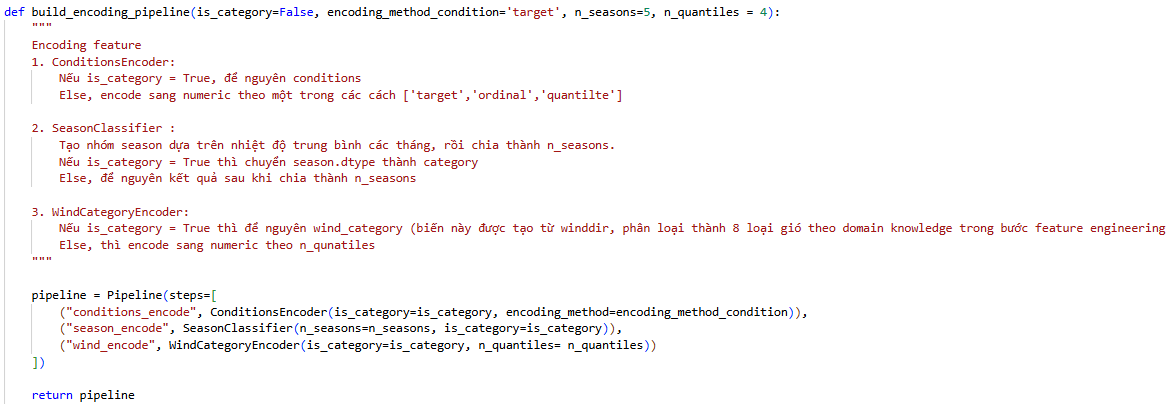

- Thêm bảng giải thích ngắn gọn 3 kiểu encoding: target encoding, ordinal encoding, quantile
- (Có thể tạo bảng, nêu ngắn gọn mỗi biến có các unique value nào, ... thấy gì phù hợp thì thêm vào)

In [57]:
# 3. Kiểm tra các biến Category
encoder = pl.build_encoding_pipeline(is_category=True)
encoder.fit(X_train, train_feat['temp'])

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

# Kích thước dữ liệu
print("=" * 60)
print(f" Kích thước dữ liệu:")
print(f"   - Train: {X_train.shape} | Target: {y_train.shape}")
print(f"   - Test : {X_test.shape} | Target: {y_test.shape}")

print("=" * 60)
cat_features = X_train.select_dtypes(include=['category']).columns

print("\nThông tin chi tiết các feature categorical:")
for col in cat_features:
    unique_vals = list(X_train[col].unique())
    print(f"• {col} ({len(unique_vals)} lớp): {unique_vals}")


 Kích thước dữ liệu:
   - Train: (2893, 236) | Target: (2893, 5)
   - Test : (697, 236) | Target: (697, 5)

Thông tin chi tiết các feature categorical:
• conditions (6 lớp): ['Clear', 'Rain', 'Rain, Partially cloudy', 'Partially cloudy', 'Rain, Overcast', 'Overcast']
• wind_category (8 lớp): ['Đông_Bắc_NE', 'Đông_Nam_SE', 'Bắc_N', 'Nam_S', 'Bắc_Đông Bắc_N_NE', 'Tây_Bắc_NW', 'Tây_Nam_SW', 'Tây_W']
• season (5 lớp): [2, 1, 0, 3, 4]


### 2.3. Tuning and Training LGB


### A. Giải thích các hyper paramter mình tune - Sương Mai, Hoàng đọc tìm hiểu luôn
vd:

Trong cái boosting type (check lại kiến thức t vt nhé ko đảm bảo)
<br> goss: lựa chọn ngẫu nhiên dựa theo độ lớn gradient, tập trung vào các point có grad lớn - thì không dùng được subsample và subsample_fraction
<br> gbdt, dart: lựa chọn ngẫu nhiên dựa vào bagging (chọn ngẫu nhiên qua tỉ lệ subsample và subsample_fraction)

### B. Sử dụng hyper parameter mặc định của model và sử dụng category feature chưa encoding sang numeric

In [ ]:
# Đổi tên task trong task_name
if Task.current_task():
    Task.current_task().close()

task_lgbm = Task.init(
    project_name="Temperature Forecasting",         # tên project trên ClearML (nếu chưa có sẽ tự tạo)
    task_name="LGB Optuna Tuning full pipe 1",            # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print(" Task created successfully!")
print("Task ID:", task_lgbm.id)

ClearML Task: created new task id=0942543b8a8d4fd5a344402818d9adc2
======> WARNING! Git diff too large to store (4438kb), skipping uncommitted changes <======
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/0942543b8a8d4fd5a344402818d9adc2/output/log
Task ID: 0942543b8a8d4fd5a344402818d9adc2


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000021217620E90>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.ping
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000212212B5CA0>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.get_all
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002121758EA20>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/events.add_batch
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connect

2025-11-12 14:48:18,749 - clearml.storage - INFO - Uploading: 5.44MB from C:/Users/Admin/AppData/Local/Temp/Final%20MultiOutput%20Model._71o9m17.pkl


█████████████████████████████████ 100% | 5.44/5.44 MB [00:27<00:00,  4.97s/MB]: 
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000212213716D0>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.get_all
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000021221372C60>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.ping


In [13]:
task_lgbm = Task.get_task(task_id="0942543b8a8d4fd5a344402818d9adc2")
logger_lgbm = task_lgbm.get_logger()

In [ ]:
# === 1️. Cấu hình LGBM mặc định ===
default_lgbm_params = dict(
    boosting_type='gbdt',
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,  # -1 means no limit
    num_leaves=31,
    min_child_samples=20,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# === 2. Time Series Cross Validation với Pipeline Tổng trong từng fold ===
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
cv_artifacts = {}

print("=== Time Series Cross-Validation (COMPLETE PIPELINE + LGBM) ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    # Lấy dữ liệu GỐC cho fold
    X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_raw, y_val_raw = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Huấn luyện riêng cho từng target
    y_pred_val_all = pd.DataFrame(columns=y_train.columns)
    
    # Theo dõi số lượng features và thông tin pipeline
    pipeline_info = {}
    
    for target_idx, target_col in enumerate(y_train.columns):        
        # Tạo pipeline tổng MỚI cho mỗi target và mỗi fold
        complete_pipeline = pl.build_full_pipeline(
            is_linear=False,
            is_category_conditions=False, 
            is_category_season=False,
            is_category_wind=False,
            encoding_method_condition='target',
            n_seasons=5,
            n_quantiles=4,
            drop_nan=False,
            drop_base=True
        )
        
        # Lấy target thực cho fold này
        y_tr_target = y_tr_raw.iloc[:, target_idx] if len(y_tr_raw.shape) > 1 else y_tr_raw
        
        # FIT pipeline tổng với target thực (cho encoding)
        complete_pipeline.fit(X_tr_raw, y_tr_target)
        
        # TRANSFORM training data
        X_tr_processed = complete_pipeline.transform(X_tr_raw)
        
        # TRANSFORM validation data  
        X_val_processed = complete_pipeline.transform(X_val_raw)
        
        # CUTOFF 30 dòng đầu do rolling features
        X_tr_final = X_tr_processed.iloc[30:]
        X_val_final = X_val_processed.iloc[30:]
        y_tr_final = y_tr_target.iloc[30:]
        
        # Tạo và huấn luyện LGBM model trên data đã processed
        lgbm_model = LGBMRegressor(**default_lgbm_params)
        lgbm_model.fit(X_tr_final, y_tr_final)
        
        # Dự đoán trên validation data
        y_pred = lgbm_model.predict(X_val_final)
        
        # Lưu predictions
        if len(y_pred_val_all) == 0:
            y_pred_val_all = pd.DataFrame(index=range(len(y_pred)), columns=y_train.columns)
        y_pred_val_all[target_col] = y_pred
        
        # Lưu thông tin pipeline cho target đầu tiên
        if target_idx == 0:
            pipeline_info = {
                'original_features': X_tr_raw.shape[1],
                'features_after_pipeline': X_tr_final.shape[1],
                'train_samples_after_cutoff': len(X_tr_final),
                'val_samples_after_cutoff': len(X_val_final)
            }

    # CUTOFF y_val để khớp với predictions
    y_val_cutoff = y_val_raw.iloc[30:]
    
    # Đánh giá - sử dụng tất cả samples sau cutoff
    metrics_val = evaluate_multi_output(y_val_cutoff.values, y_pred_val_all.values)
    avg_val = metrics_val["average"]
    per_day_val = metrics_val["per_day"]
    cv_scores.append(avg_val)

    print(f"\nFold {fold_idx} - Samples: Train={pipeline_info['train_samples_after_cutoff']}, Val={len(y_val_cutoff)}")
    print("Average Metrics:")
    for metric, value in avg_val.items():
        print(f"  {metric}: {value:.4f}")

    # Log artifact
    cv_artifacts[f"Fold_{fold_idx}"] = {
        "average": avg_val,
        "per_day": per_day_val,
        "pipeline_info": pipeline_info,
        "samples_info": {
            "train_original": len(X_tr_raw),
            "train_after_cutoff": pipeline_info['train_samples_after_cutoff'],
            "val_original": len(X_val_raw), 
            "val_after_cutoff": len(y_val_cutoff)
        }
    }

    fold_idx += 1

# === 3. Tổng hợp kết quả cross-validation ===
if cv_scores:
    cv_df = pd.DataFrame(cv_scores)
    cv_mean = cv_df.mean()
    cv_std = cv_df.std()

    print("\n" + "="*50)
    print("=====> Cross-validation trung bình:")
    print(cv_mean)
    print("\n=====> Cross-validation độ lệch chuẩn:")
    print(cv_std)

    # Log artifact tổng hợp CV
    cv_artifacts["CV_Summary"] = {
        "mean": cv_mean.to_dict(),
        "std": cv_std.to_dict(),
        "model_params": default_lgbm_params,
        "pipeline_config": {
            "is_linear": False,
            "is_category_conditions": False,
            "is_category_season": False, 
            "is_category_wind": False,
            "encoding_method_condition": "target",
            "n_seasons": 5,
            "n_quantiles": 4,
            "drop_nan": False,
            "drop_base": True,
            "cutoff_after_pipeline": 30
        }
    }

    # Gửi toàn bộ artifact CV lên ClearML
    task_lgbm.upload_artifact("Complete_Pipeline_Default_LGBM_CV_Detail", cv_artifacts)

    print("\n=== COMPLETE PIPELINE LGBM CONFIGURATION ===")
    print(f"Boosting type: {default_lgbm_params['boosting_type']}")
    print(f"Learning rate: {default_lgbm_params['learning_rate']}")
    print(f"Number of estimators: {default_lgbm_params['n_estimators']}")
    print(f"Max depth: {default_lgbm_params['max_depth']}")
    print(f"Number of leaves: {default_lgbm_params['num_leaves']}")
    print(f"Pipeline: Complete preprocessing + feature engineering")
    print(f"Encoding method: target")
    print(f"Number of seasons: 5")
    print(f"Number of quantiles: 4")
    print(f"Cutoff after pipeline: 30 rows")
    print(f"Drop base features: True")
else:
    print(" No valid CV results to report!")


=== Time Series Cross-Validation (COMPLETE PIPELINE + LGBM) ===

Fold 1 - Samples: Train=458, Val=457
Average Metrics:
  RMSE: 2.6567
  MAE: 2.0447
  R2: 0.6959

Fold 2 - Samples: Train=945, Val=457
Average Metrics:
  RMSE: 2.5718
  MAE: 2.0133
  R2: 0.7010

Fold 3 - Samples: Train=1432, Val=457
Average Metrics:
  RMSE: 2.4856
  MAE: 1.9667
  R2: 0.7730

Fold 4 - Samples: Train=1919, Val=457
Average Metrics:
  RMSE: 2.2871
  MAE: 1.8215
  R2: 0.8010

Fold 5 - Samples: Train=2406, Val=457
Average Metrics:
  RMSE: 2.1836
  MAE: 1.6867
  R2: 0.7893

=====> Cross-validation trung bình:
RMSE    2.436958
MAE     1.906581
R2      0.752055
dtype: float64

=====> Cross-validation độ lệch chuẩn:
RMSE    0.197174
MAE     0.149705
R2      0.049937
dtype: float64

=== COMPLETE PIPELINE LGBM CONFIGURATION ===
Boosting type: gbdt
Learning rate: 0.1
Number of estimators: 100
Max depth: -1
Number of leaves: 31
Pipeline: Complete preprocessing + feature engineering
Encoding method: target
Number of seas

### B. Tuning Các lựa chọn encoding + Model LGB

chạy lâu quá, nên t chạy thử đén trial 35 của temp next 1 thôi, c xem cách nào cải thiện ko thì chịu khó :'))

In [33]:
def objective_complete_pipeline_per_target(trial, target_name, target_idx):
    # Hyperparameters cho COMPLETE pipeline
    is_linear = trial.suggest_categorical("is_linear", [False])
    encoding_method_condition = trial.suggest_categorical("encoding_method_condition", 
                                                         ["ordinal", "target", "quantile"])
    n_seasons = trial.suggest_int("n_seasons", 3, 8)
    n_quantiles = trial.suggest_int("n_quantiles", 2, 6)
    
    # Tune is_category cho từng encoder
    conditions_is_category = trial.suggest_categorical("conditions_is_category", [True, False])
    season_is_category = trial.suggest_categorical("season_is_category", [True, False])
    wind_is_category = trial.suggest_categorical("wind_is_category", [True, False])
    
    # Hyperparameters cho LGBM
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"])
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    num_leaves = trial.suggest_int("num_leaves", 15, 255)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)
    
    # Conditional parameters
    if boosting_type in ['gbdt', 'dart']:
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
    else:
        subsample = 1.0
        
    if boosting_type == 'dart':
        subsample_freq = trial.suggest_int("subsample_freq", 1, 10)
    else:
        subsample_freq = 0

    # TimeSeriesSplit
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        # Lấy dữ liệu GỐC cho fold hiện tại
        X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr_raw, y_val_raw = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Lấy target thực sự cho fold này
        y_tr_target = y_tr_raw.iloc[:, target_idx] if len(y_tr_raw.shape) > 1 else y_tr_raw
        y_val_target = y_val_raw.iloc[:, target_idx] if len(y_val_raw.shape) > 1 else y_val_raw
        
        try:
            # Build COMPLETE pipeline với các parameters được tuning
            complete_pipeline = pl.build_full_pipeline(
                is_linear=is_linear,
                is_category_conditions=conditions_is_category,
                is_category_season=season_is_category,
                is_category_wind=wind_is_category,
                encoding_method_condition=encoding_method_condition,
                n_seasons=n_seasons,
                n_quantiles=n_quantiles,
                drop_nan=False,  # QUAN TRỌNG: không drop NaN trong pipeline
                drop_base=True
            )
            
            # FIT pipeline trên training fold - SỬA Ở ĐÂY: dùng y_tr_target thực sự
            # Encoding cần 'temp' column từ X_tr_raw, nhưng fit vẫn dùng y thực
            complete_pipeline.fit(X_tr_raw, y_tr_target)
            
            # TRANSFORM cả train và validation
            X_tr_processed = complete_pipeline.transform(X_tr_raw)
            X_val_processed = complete_pipeline.transform(X_val_raw)
            
            # CUTOFF 30 dòng đầu do rolling features
            X_tr_final = X_tr_processed.iloc[30:]
            X_val_final = X_val_processed.iloc[30:]
            
            # Lấy target tương ứng sau cutoff - SỬA Ở ĐÂY: dùng y_tr_target đã có
            y_tr_single = y_tr_target.iloc[30:]
            y_val_single = y_val_target.iloc[30:]
            
            # Đảm bảo indices khớp nhau
            X_tr_final = X_tr_final.loc[y_tr_single.index]
            X_val_final = X_val_final.loc[y_val_single.index]
            
            # LGBM model
            lgbm = LGBMRegressor(
                boosting_type=boosting_type,
                objective='regression',
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                num_leaves=num_leaves,
                min_child_samples=min_child_samples,
                min_split_gain=min_split_gain,
                colsample_bytree=colsample_bytree,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                subsample=subsample,
                subsample_freq=subsample_freq,
                random_state=42,
                n_jobs=1,
                verbosity=-1
            )
            
            # Fit model
            lgbm.fit(X_tr_final, y_tr_single)
            y_pred_val = lgbm.predict(X_val_final)
            
            # Tính RMSE
            result = evaluate(y_val_single, y_pred_val)
            rmse = result['RMSE']
            rmse_scores.append(rmse)
            
        except Exception as e:
            print(f"Error in trial {trial.number} for {target_name}: {e}")
            import traceback
            traceback.print_exc()
            return float('inf')

    mean_rmse = np.mean(rmse_scores)

    # Log lên ClearML
    logger_lgbm.report_scalar(
        title=f'Optuna Tuning - Complete Pipeline [{target_name}]',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([{
        "target": target_name,
        "is_linear": is_linear,
        "boosting_type": boosting_type,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "num_leaves": num_leaves,
        "encoding_method": encoding_method_condition,
        "n_seasons": n_seasons,
        "n_quantiles": n_quantiles,
        "conditions_is_category": conditions_is_category,
        "season_is_category": season_is_category,
        "wind_is_category": wind_is_category
    }])
    
    logger_lgbm.report_table(
        title=f"Trial {trial.number} - {target_name}",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return mean_rmse

In [34]:
# === 2. Hàm helper cho LGBM ===
def build_final_complete_pipeline(params):
    """Build complete pipeline với best parameters"""
    return pl.build_full_pipeline(
        is_linear=params['is_linear'],
        is_category_conditions=params['conditions_is_category'],
        is_category_season=params['season_is_category'],
        is_category_wind=params['wind_is_category'],
        encoding_method_condition=params['encoding_method_condition'],
        n_seasons=params['n_seasons'],
        n_quantiles=params['n_quantiles'],
        drop_nan=False,
        drop_base=True
    )

def extract_lgbm_params(params):
    lgbm_params = {
        'boosting_type': params['boosting_type'],
        'objective': 'regression',
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'num_leaves': params['num_leaves'],
        'min_child_samples': params['min_child_samples'],
        'min_split_gain': params['min_split_gain'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1 
    }
    
    # Conditional parameters
    if params['boosting_type'] in ['gbdt', 'dart']:
        lgbm_params['subsample'] = params['subsample']
    
    if params['boosting_type'] == 'dart':
        lgbm_params['subsample_freq'] = params['subsample_freq']
        
    return lgbm_params


In [ ]:
studies_per_target = {}
# === Tune riêng cho từng target với COMPLETE PIPELINE ===
best_complete_models_per_target = {}
best_complete_params_per_target = {}
complete_pipelines_per_target = {}

# Tắt logging
# optuna.logging.set_verbosity(optuna.logging.WARNING)

for idx, target_name in enumerate(y_train.columns):
    print(f"Tuning COMPLETE PIPELINE for target: {target_name} ({idx + 1}/{len(y_train.columns)})")
    
    # Tạo study riêng cho mỗi target
    study = optuna.create_study(
        direction='minimize', 
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(
        lambda trial: objective_complete_pipeline_per_target(trial, target_name, idx), 
        n_trials=50,
        show_progress_bar=True,
        callbacks=[lambda study, trial: None]
    )
    
    studies_per_target[target_name] = study
    
    # Lưu best params
    best_complete_params_per_target[target_name] = study.best_trial.params
    best_complete_params_per_target[target_name]['target_idx'] = idx
    
    # Build final COMPLETE pipeline
    complete_pipeline = build_final_complete_pipeline(study.best_trial.params)
    
    # Fit pipeline trên toàn bộ training data - SỬA Ở ĐÂY: dùng y_target thực
    y_target_full = y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
    complete_pipeline.fit(X_train, y_target_full)
    
    # Transform toàn bộ data
    X_train_processed = complete_pipeline.transform(X_train)
    
    # Cutoff 30 dòng đầu
    X_train_final = X_train_processed.iloc[30:]
    y_train_final = y_target_full.iloc[30:]
    
    # Đảm bảo indices khớp
    X_train_final = X_train_final.loc[y_train_final.index]
    
    # Train final LGBM model
    best_lgbm = LGBMRegressor(**extract_lgbm_params(study.best_trial.params))
    best_lgbm.fit(X_train_final, y_train_final)
    
    # Lưu model và pipeline
    best_complete_models_per_target[target_name] = {
        'model': best_lgbm,
        'complete_pipeline': complete_pipeline
    }
    
    complete_pipelines_per_target[target_name] = complete_pipeline
    
    # Log kết quả
    logger_lgbm.report_scalar(
        title='Best RMSE per Target - Complete Pipeline',
        series=target_name,
        value=study.best_value,
        iteration=idx
    )
    
    print(f" {target_name} - Best RMSE: {study.best_value:.4f}")
    print(f" {target_name} - Best encoding: {study.best_trial.params['encoding_method_condition']}")
    print(f" {target_name} - Features after pipeline: {X_train_final.shape[1]}")
    print("-" * 50)

# Khôi phục logging
# optuna.logging.set_verbosity(optuna.logging.INFO)

#### C. Training Final Model với hyper parameter và đánh giá cuối cùng trên Test

In [39]:
## === D. Tạo MultiOutput wrapper từ các model riêng ===
class CustomMultiOutputRegressor:
    def __init__(self, models_per_target, complete_pipelines_per_target):
        self.models_per_target = models_per_target
        self.complete_pipelines_per_target = complete_pipelines_per_target
        self.target_names = list(models_per_target.keys())
    
    def predict(self, X):
        predictions = {}
        for target_name, model_info in self.models_per_target.items():
            # Sử dụng complete pipeline của target đó
            pipeline = self.complete_pipelines_per_target[target_name]
            X_processed = pipeline.transform(X)
            X_final = X_processed.iloc[30:]
            
            pred = model_info['model'].predict(X_final)
            predictions[target_name] = pred
        
        return pd.DataFrame(predictions)
    
    def get_params(self, deep=True):
        return {
            "models_per_target": self.models_per_target,
            "complete_pipelines_per_target": self.complete_pipelines_per_target
        }

# Tạo final model với complete pipelines
final_multi_model = CustomMultiOutputRegressor(best_complete_models_per_target, complete_pipelines_per_target)

## === E. Đánh giá final model trên cả TRAIN và TEST ===
print("🔍 EVALUATING FINAL MODEL...")

# Dự đoán trên train và test set
y_pred_train = final_multi_model.predict(X_train)
y_pred_test = final_multi_model.predict(X_test)

# Cutoff y để khớp với predictions (đã bị cutoff 30 dòng trong pipeline)
y_train_cutoff = y_train.iloc[30:]
y_test_cutoff = y_test.iloc[30:]

# Đánh giá
final_train_metrics = evaluate_multi_output(y_train_cutoff, y_pred_train)
final_test_metrics = evaluate_multi_output(y_test_cutoff, y_pred_test)

# Hiển thị kết quả
print("\nFINAL MODEL PERFORMANCE")
print("=" * 60)

print("\nTRAIN SET PERFORMANCE:")
print(f"Samples: {len(y_train_cutoff)}")
print("Average metrics:")
for metric, value in final_train_metrics["average"].items():
    print(f"  {metric}: {value:.4f}")
print('Perday Train Metrics', final_train_metrics['per_day'])

print("\nTEST SET PERFORMANCE:")
print(f"Samples: {len(y_test_cutoff)}") 
print("Average metrics:")
for metric, value in final_test_metrics["average"].items():
    print(f"  {metric}: {value:.4f}")
print('Perday Test Metrics', final_test_metrics['per_day'])


🔍 EVALUATING FINAL MODEL...

FINAL MODEL PERFORMANCE

TRAIN SET PERFORMANCE:
Samples: 2893
Average metrics:
  RMSE: 1.6792
  MAE: 1.3244
  R2: 0.8906
Perday Train Metrics {'RMSE_day_1': 1.2268421788290729, 'MAE_day_1': 0.9386557489980127, 'R2_day_1': 0.9429051178200374, 'RMSE_day_2': 1.9095191637153068, 'MAE_day_2': 1.4894176345415915, 'R2_day_2': 0.8617364850989411, 'RMSE_day_3': 1.6040241541436682, 'MAE_day_3': 1.2603758036657466, 'R2_day_3': 0.9024672964058833, 'RMSE_day_4': 1.709871456107495, 'MAE_day_4': 1.375385342153856, 'R2_day_4': 0.8891962597153579, 'RMSE_day_5': 1.9458479175175645, 'MAE_day_5': 1.5580875967220011, 'R2_day_5': 0.8565226238081463}

TEST SET PERFORMANCE:
Samples: 697
Average metrics:
  RMSE: 2.1971
  MAE: 1.7355
  R2: 0.8132
Perday Test Metrics {'RMSE_day_1': 1.4739018745693384, 'MAE_day_1': 1.1293318818662488, 'R2_day_1': 0.9183123690341548, 'RMSE_day_2': 2.12716604182732, 'MAE_day_2': 1.6750423850645357, 'R2_day_2': 0.8299508120492755, 'RMSE_day_3': 2.3989141

In [42]:
y_pred_test

,temp_next_1,temp_next_2,temp_next_3,temp_next_4,temp_next_5
0,27.256635,26.158213,26.669806,25.034452,24.358288
1,26.688416,25.635404,26.759988,24.734847,24.711511
2,24.983149,24.996162,25.126561,24.758679,24.817776
3,24.005254,24.185221,23.814969,24.749903,24.682575
4,24.893279,24.610588,25.258054,24.778233,25.014832
...,...,...,...,...,...
692,27.469024,27.793667,27.298084,27.493727,28.071153
693,28.031527,27.863756,27.241767,27.472288,28.118416
694,29.741279,28.672989,28.001147,27.823224,28.260816
695,30.738312,29.203263,28.078259,27.795549,28.312379


In [ ]:

## === F. LOG TẤT CẢ KẾT QUẢ LÊN CLEARML ===
print("\n📤 UPLOADING ALL ARTIFACTS TO CLEARML...")

# 1. Best Parameters cho từng target
task_lgbm.upload_artifact("Best Parameters Per Target", best_complete_params_per_target)
print("Uploaded: Best Parameters Per Target")

# 2. Complete Pipelines cho từng target  
task_lgbm.upload_artifact("Complete Pipelines Per Target", complete_pipelines_per_target)
print("Uploaded: Complete Pipelines Per Target")

# 3. Final Models info
models_info = {}
for target_name, model_info in best_complete_models_per_target.items():
    models_info[target_name] = {
        'model_type': type(model_info['model']).__name__,
        'model_params': model_info['model'].get_params(),
        'features_count': X_train.shape[1],
        'pipeline_steps': list(model_info['complete_pipeline'].named_steps.keys()),
        'best_encoding_method': best_complete_params_per_target[target_name].get('encoding_method_condition', 'N/A'),
        'best_n_seasons': best_complete_params_per_target[target_name].get('n_seasons', 'N/A')
    }
task_lgbm.upload_artifact("Final Models Info", models_info)
print("Uploaded: Final Models Info")

# 4. Train Metrics
task_lgbm.upload_artifact("Final Model - Train Metrics", final_train_metrics)
print("Uploaded: Final Model - Train Metrics")

# 5. Test Metrics
task_lgbm.upload_artifact("Final Model - Test Metrics", final_test_metrics)  
print("Uploaded: Final Model - Test Metrics")

# 6. Log multioutput model
task_lgbm.upload_artifact("Final MultiOutput Model", final_multi_model)
print(" Uploaded: Final MultiOutput Model")


## === G. Lưu tất cả models ===
print("\n💾 SAVING ALL MODELS...")

lgbm_models_path = r"models/Complete_Pipeline_LGBM_models.pkl"
joblib.dump({
    'models': best_complete_models_per_target,
    'params': best_complete_params_per_target,
    'pipelines': complete_pipelines_per_target,
    'final_multi_model': final_multi_model,
    'train_metrics': final_train_metrics,
    'test_metrics': final_test_metrics
}, lgbm_models_path)

print(f"✅ Models saved to: {lgbm_models_path}")

## === H. Summary Report ===
print(f" MODEL PERFORMANCE SUMMARY:")
print(f"   Train RMSE: {final_train_metrics['average']['RMSE']:.4f}")
print(f"   Test RMSE:  {final_test_metrics['average']['RMSE']:.4f}")

print(f"ARTIFACTS UPLOADED TO CLEARML:")
artifacts_list = [
    "Best Parameters Per Target",
    "Complete Pipelines Per Target", 
    "Final Models Info",
    "Final Model - Train Metrics",
    "Final Model - Test Metrics",
    "Final MultiOutput Model"
]

for artifact in artifacts_list:
    print(f"   ✅ {artifact}")

print(f"Training completed at: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")



📤 UPLOADING ALL ARTIFACTS TO CLEARML...
✅ Uploaded: Best Parameters Per Target
2025-11-12 14:47:48,963 - clearml - WARNING - JSON serialization of artifact 'Complete Pipelines Per Target' failed, reverting to pickle
✅ Uploaded: Complete Pipelines Per Target
✅ Uploaded: Final Models Info
✅ Uploaded: Final Model - Train Metrics
✅ Uploaded: Final Model - Test Metrics
2025-11-12 14:47:58,888 - clearml - WARNING - JSON serialization of artifact 'Final Predictions' failed, reverting to pickle
✅ Uploaded: Final Predictions
✅ Uploaded: Final MultiOutput Model
✅ Uploaded: Performance Comparison

💾 SAVING ALL MODELS...
✅ Models saved to: models/Complete_Pipeline_LGBM_models.pkl

🎯 FINAL TRAINING COMPLETED SUCCESSFULLY!
📊 MODEL PERFORMANCE SUMMARY:
   Train RMSE: 1.6792
   Test RMSE:  2.1971
   RMSE Gap:   1.1793
   Generalization: POOR

📁 ARTIFACTS UPLOADED TO CLEARML:
   ✅ Best Parameters Per Target
   ✅ Complete Pipelines Per Target
   ✅ Final Models Info
   ✅ Final Model - Train Metrics
   ✅

#### T bảo, nếu két quả tuning tệ hơn tune_lgb thì lấy cái tune_lgb cũ nhé (kết quả tệ cũng có thể do mình drop hết base)

In [ ]:
# Defaut Goss
tune_lgb = LGBMRegressor(
    boosting_type='goss',
    objective= 'regression', # loss function
    colsample_bytree=0.7688738230630878,
    learning_rate=0.015433744772417535,
    max_depth= 4,
    min_child_samples=50,
    min_split_gain=0.4084759794499262,
    n_estimators=417,
    num_leaves=128,
    reg_alpha=0.008,
    reg_lambda=0.008,
    # subsample=0.9098920662929666,
    # subsample_freq= 10,
    random_state=42,
    n_jobs=-1
)

model_grad = MultiOutputRegressor(estimator=tune_lgb, n_jobs=-1)

# 2️⃣ Time series cross-validation (chỉ trên tập train)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []  # lưu kết quả trung bình của mỗi fold

print("=== Time Series Cross-Validation ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Huấn luyện mô hình
    model_grad.fit(X_tr, y_tr)
    y_pred_val = model_grad.predict(X_val)
    
    # Đánh giá
    metrics_val = evaluate_multi_output(y_val, y_pred_val)
    avg_val = metrics_val["average"]
    cv_scores.append(avg_val)
    
    print(f"\nFold {fold_idx} validation metrics:")
    print(avg_val)
    fold_idx += 1

# 3️⃣ Tổng hợp kết quả cross-validation
cv_df = pd.DataFrame(cv_scores)
print("\n=====> Cross-validation (Time Series) trung bình:")
print(cv_df.mean())

print("\n=====> Cross-validation (Time Series) độ lệch chuẩn (variance):")
print(cv_df.std())

# Sau khi bạn thấy mô hình ổn định qua các fold,
# bạn huấn luyện lại trên toàn bộ tập train rồi đánh giá 1 lần trên test (dữ liệu tương lai thật).

# 4️⃣ Huấn luyện lại toàn bộ tập train sau khi CV
model_grad.fit(X_train, y_train)


# 5️⃣ Đánh giá cuối cùng trên tập train
y_pred_train = model_grad.predict(X_train)
defGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)

print("\n=====> Train metrics (trung bình):", defGrad_train_metrics["average"])
print("Train metrics (chi tiết từng ngày):", defGrad_train_metrics["per_day"])


# 5️⃣ Đánh giá cuối cùng trên tập test
y_pred_test = model_grad.predict(X_test)
defGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)

print("\n=====> Test metrics (trung bình):", defGrad_test_metrics["average"])
print("Test metrics (chi tiết từng ngày):", defGrad_test_metrics["per_day"])




=== Time Series Cross-Validation ===

Fold 1 validation metrics:
{'RMSE': 2.189680285498163, 'MAE': 1.704620957937962, 'R2': 0.8074714844531672}

Fold 2 validation metrics:
{'RMSE': 2.413370017239452, 'MAE': 1.9145946327013916, 'R2': 0.7189911984842385}

Fold 3 validation metrics:
{'RMSE': 2.359938600201726, 'MAE': 1.8930230307758957, 'R2': 0.7975122925659461}

Fold 4 validation metrics:
{'RMSE': 2.1569942272046347, 'MAE': 1.7194515196945026, 'R2': 0.8226671760867408}

Fold 5 validation metrics:
{'RMSE': 2.0945297366727145, 'MAE': 1.6284461447160687, 'R2': 0.8063628154303683}

=====> Cross-validation (Time Series) trung bình:
RMSE    2.242903
MAE     1.772027
R2      0.790601
dtype: float64

=====> Cross-validation (Time Series) độ lệch chuẩn (variance):
RMSE    0.136916
MAE     0.125388
R2      0.041040
dtype: float64


In [26]:
# Sau khi bạn thấy mô hình ổn định qua các fold,
# bạn huấn luyện lại trên toàn bộ tập train rồi đánh giá 1 lần trên test (dữ liệu tương lai thật).

# 4️⃣ Huấn luyện lại toàn bộ tập train sau khi CV
model_grad.fit(X_train, y_train)


# 5️⃣ Đánh giá cuối cùng trên tập train
y_pred_train = model_grad.predict(X_train)
defGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)

print("\n=====> Train metrics (trung bình):", defGrad_train_metrics["average"])
print("Train metrics (chi tiết từng ngày):", defGrad_train_metrics["per_day"])


# 5️⃣ Đánh giá cuối cùng trên tập test
y_pred_test = model_grad.predict(X_test)
defGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)

print("\n=====> Test metrics (trung bình):", defGrad_test_metrics["average"])
print("Test metrics (chi tiết từng ngày):", defGrad_test_metrics["per_day"])




=====> Train metrics (trung bình): {'RMSE': 1.6460833685265446, 'MAE': 1.3019954632333803, 'R2': 0.894564568405622}
Train metrics (chi tiết từng ngày): {'RMSE_day_1': 1.1629878806884322, 'MAE_day_1': 0.8898766031559433, 'R2_day_1': 0.9486123669202027, 'RMSE_day_2': 1.6399738220172975, 'MAE_day_2': 1.2774494874613571, 'R2_day_2': 0.8977811325292001, 'RMSE_day_3': 1.7780216107033764, 'MAE_day_3': 1.4169564699231192, 'R2_day_3': 0.8798089255635324, 'RMSE_day_4': 1.8185575918794266, 'MAE_day_4': 1.4588993159657895, 'R2_day_4': 0.8742280669346942, 'RMSE_day_5': 1.8308759373441892, 'MAE_day_5': 1.4667954396606933, 'R2_day_5': 0.8723923500804807}

=====> Test metrics (trung bình): {'RMSE': 2.0266201169826568, 'MAE': 1.6015566863985402, 'R2': 0.8301837207620476}
Test metrics (chi tiết từng ngày): {'RMSE_day_1': 1.3654904273406079, 'MAE_day_1': 1.0511264298055445, 'R2_day_1': 0.9272732226687969, 'RMSE_day_2': 1.9682315599680136, 'MAE_day_2': 1.545839343739147, 'R2_day_2': 0.8470969247057519, '

### 3. Bảng so sánh kết quả 2 model (so sánh chung chung để chốt chọn model nào - lgb - sau đó mình mới phân tích cụ thể kết quả ở mục sau)
- Nhàn lên cho t cái form so sánh những gì (các chỉ số average, perday, time) - Hoặc chụp ảnh dùng cái chức năng so sánh của ClearML - Hoặc cả 2
- Xong Nhàn với Hoàng train ra được model tốt nhất của linear với LGB rồi thì điền vào đây nhé (mấy cái metric căn bản có lưu trên clearml)
- Kết luận: Chọn model LGB

### 4. Đánh giá và Giải thích cụ thể kết quả của model (LGB) - Hoàng
bn chờ t cập nhật format biểu đồ

In [ ]:
# Giả sử y_test có index datetime
y_test.index = pd.to_datetime(y_test.index)

# Tạo DataFrame/Series cho y_pred với index từ y_test
y_pred_with_index = pd.DataFrame(y_pred_test, index=y_test.index)


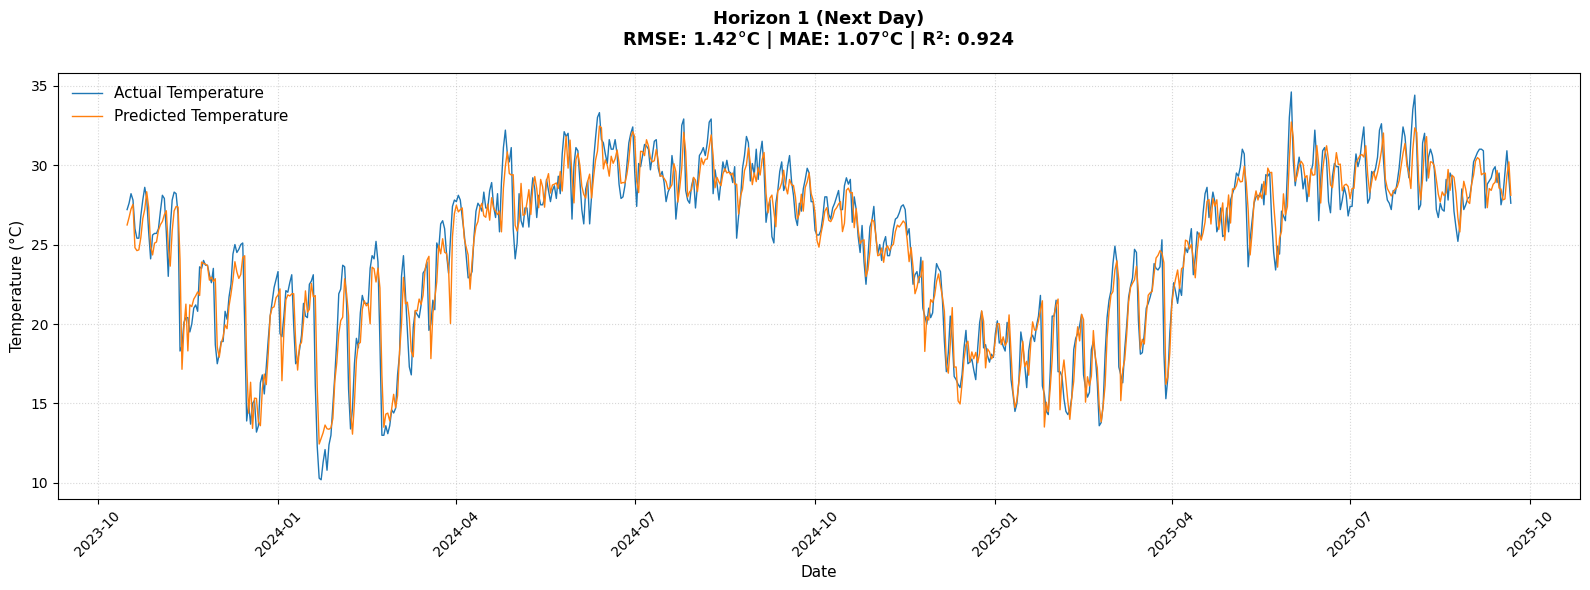

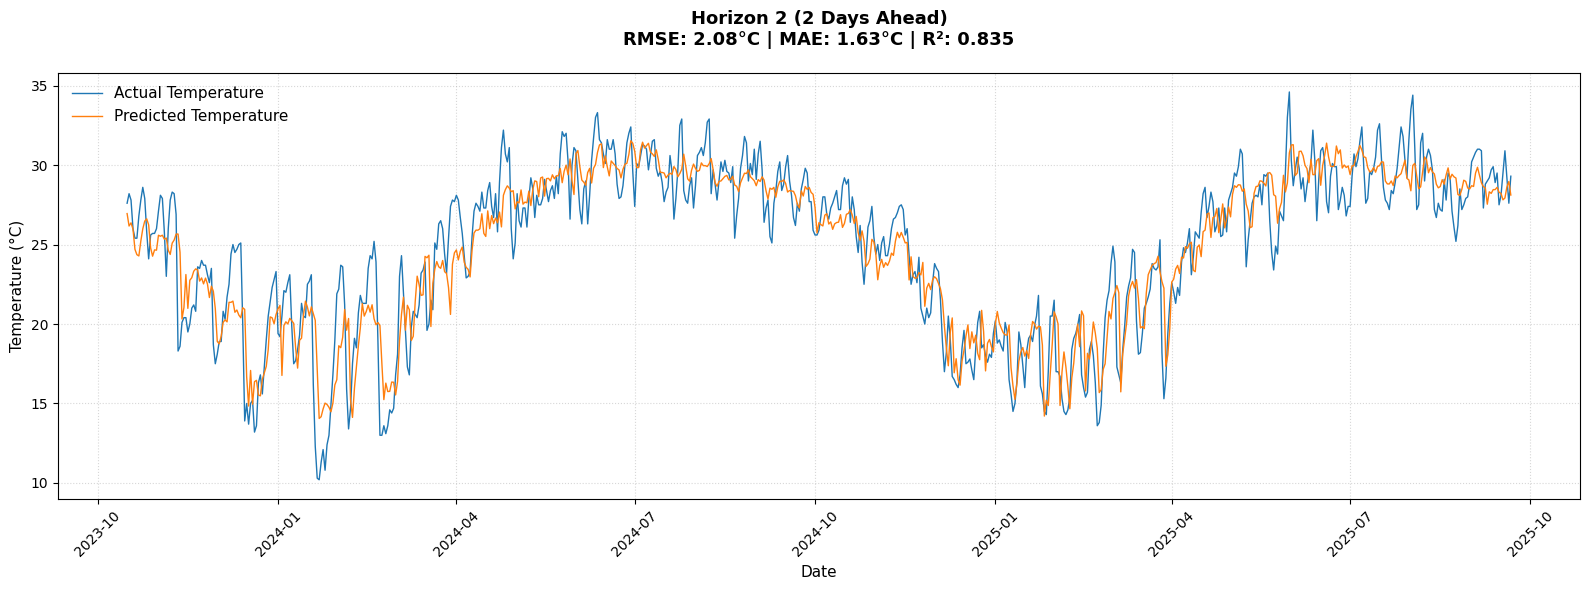

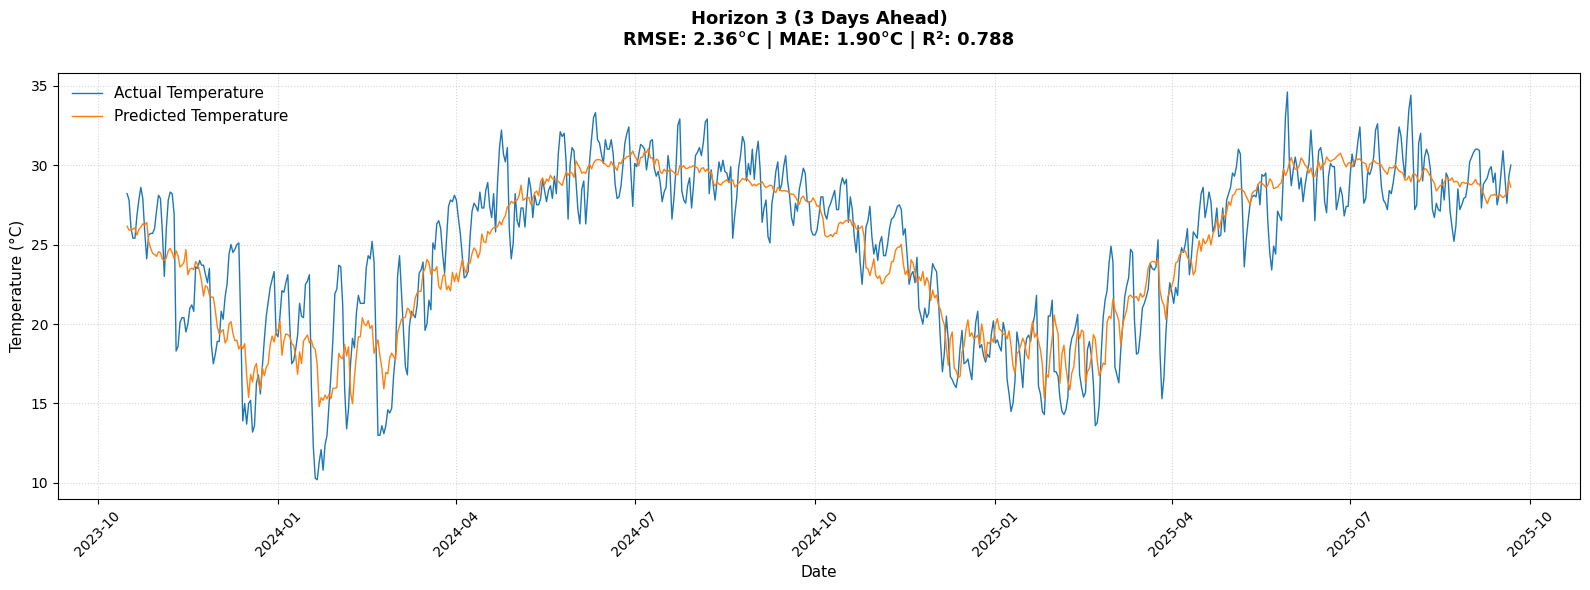

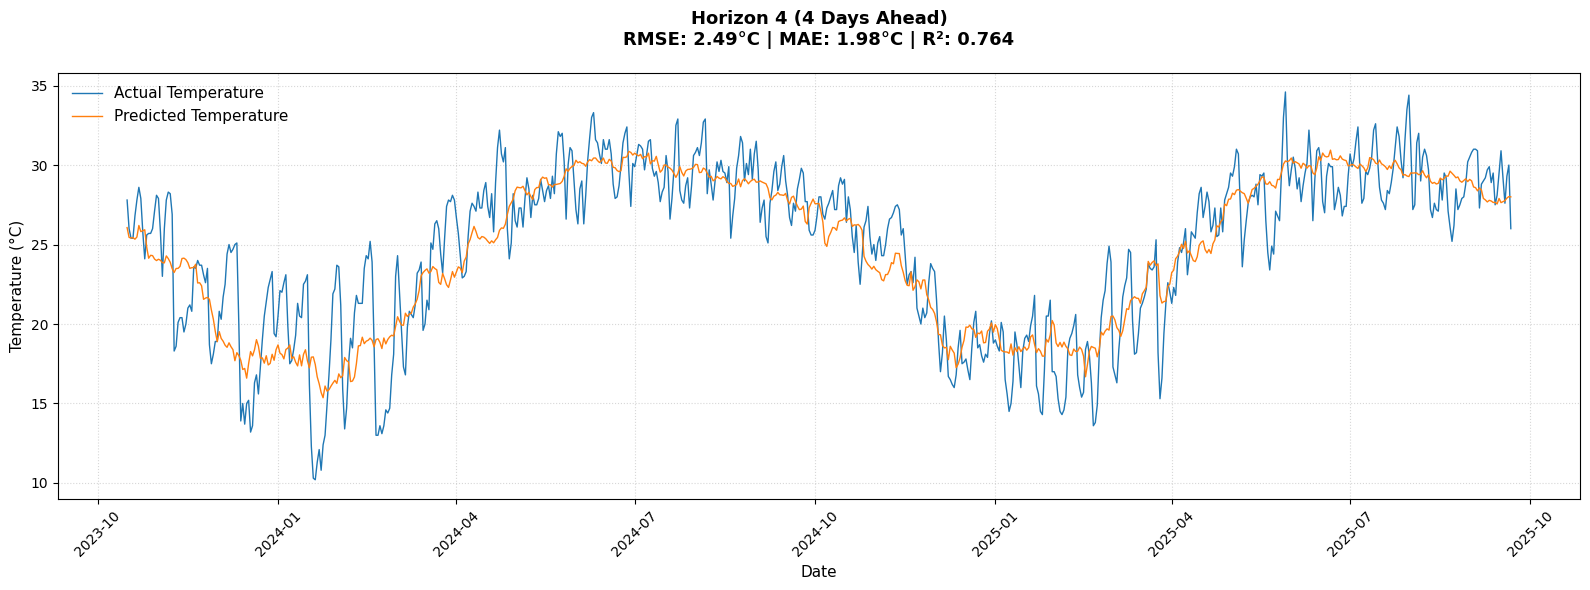

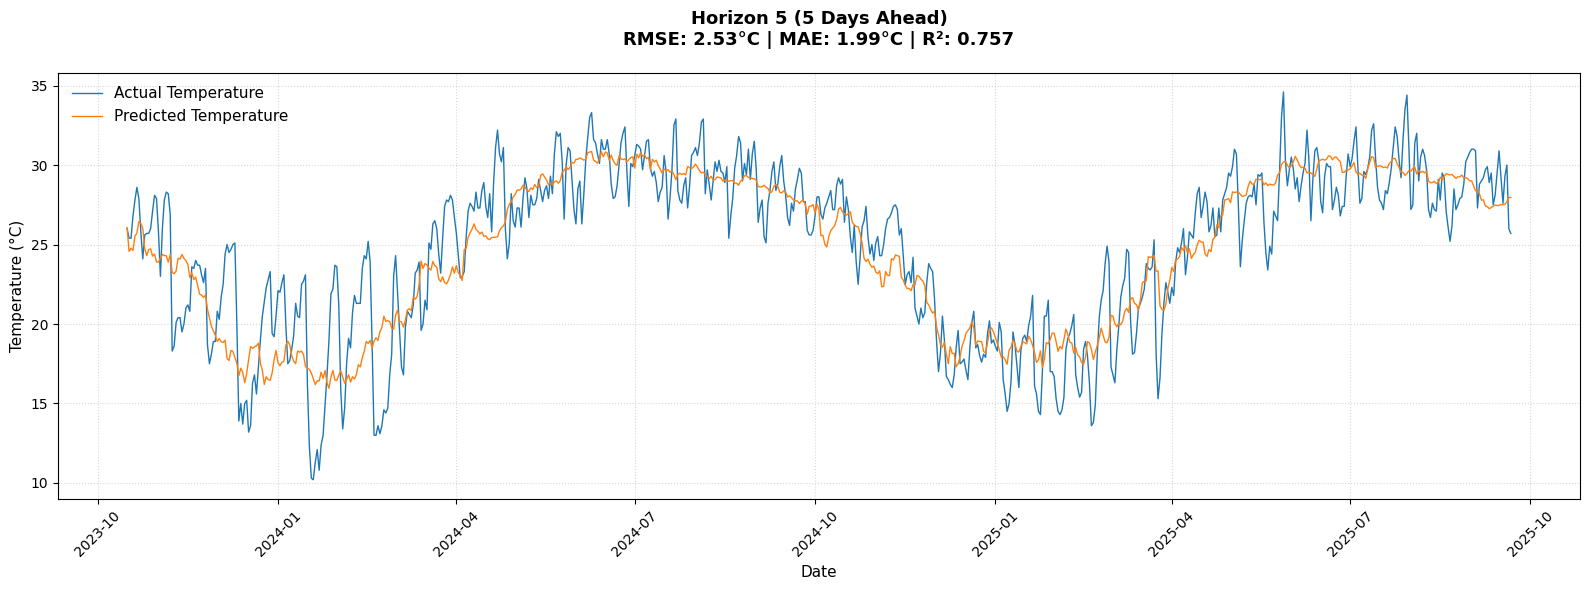

In [ ]:

def plot_separate_horizons(y_test, y_pred_test, figsize=(16, 6)):
    """
    Vẽ 5 biểu đồ riêng biệt cho 5 horizons.
    Mỗi biểu đồ hiển thị dữ liệu thực (y_true) và dự đoán (y_pred)
    với màu và kiểu đường dễ phân biệt.
    """
    
    # Kiểm tra input
    assert y_test.shape[1] == 5, "y_test phải có 5 columns"
    assert y_pred_test.shape[1] == 5, "y_pred_test phải có 5 columns"
    assert len(y_test) == len(y_pred_test), "Số samples phải khớp"
    
    horizon_names = [
        'Horizon 1 (Next Day)', 
        'Horizon 2 (2 Days Ahead)', 
        'Horizon 3 (3 Days Ahead)', 
        'Horizon 4 (4 Days Ahead)', 
        'Horizon 5 (5 Days Ahead)'
    ]
    
    # Màu nhẹ cho Actual, màu đậm cho Predict
    true_color = "#1f77b4"   # Xanh dương dịu
    pred_color = "#ff7f0e"   # Cam dịu
    
    for i in range(5):
        plt.figure(figsize=figsize)
        
        y_true_horizon = y_test.iloc[:, i]
        y_pred_horizon = y_pred_test[:, i]
        dates = y_test.index
        
        # Metrics
        rmse = np.sqrt(np.mean((y_true_horizon - y_pred_horizon) ** 2))
        mae = np.mean(np.abs(y_true_horizon - y_pred_horizon))
        r2 = 1 - np.sum((y_true_horizon - y_pred_horizon) ** 2) / np.sum((y_true_horizon - np.mean(y_true_horizon)) ** 2)
        
        # --- Vẽ biểu đồ ---
        plt.plot(
            dates, y_true_horizon, 
            label='Actual Temperature', 
            color=true_color, 
            linewidth=1
        )
        
        plt.plot(
            dates, y_pred_horizon, 
            label='Predicted Temperature', 
            color=pred_color, 
            linewidth=1
        )
        
        # --- Tuỳ chỉnh ---
        plt.title(
            f'{horizon_names[i]}\nRMSE: {rmse:.2f}°C | MAE: {mae:.2f}°C | R²: {r2:.3f}',
            fontsize=13, fontweight='bold', pad=20
        )
        plt.ylabel('Temperature (°C)', fontsize=11)
        plt.xlabel('Date', fontsize=11)
        plt.legend(fontsize=11, frameon=False)
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


plot_separate_horizons(y_test, y_pred_test)


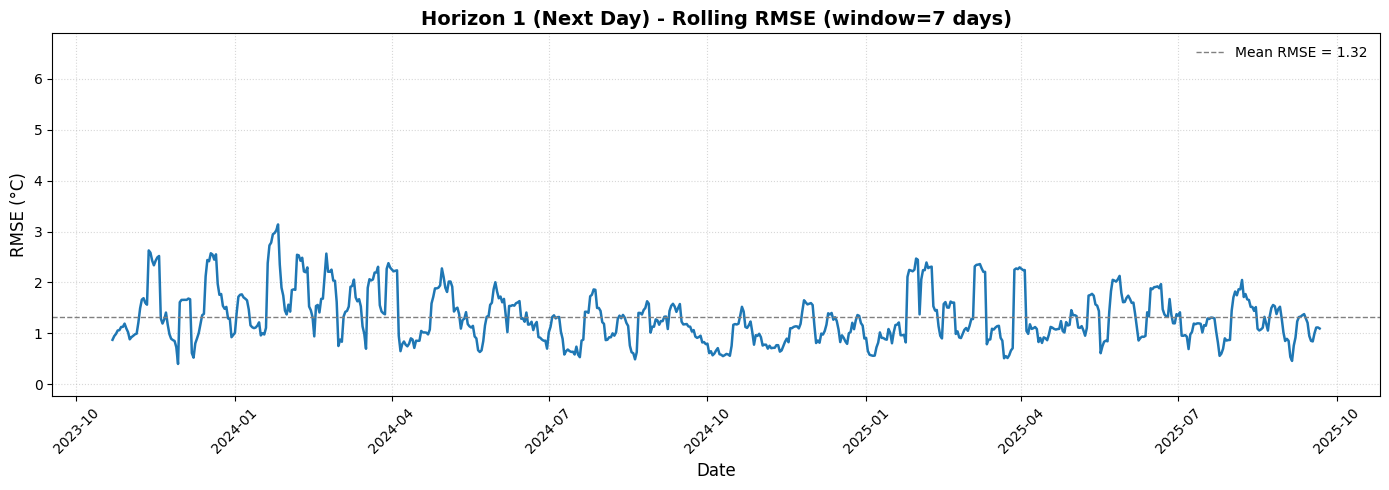

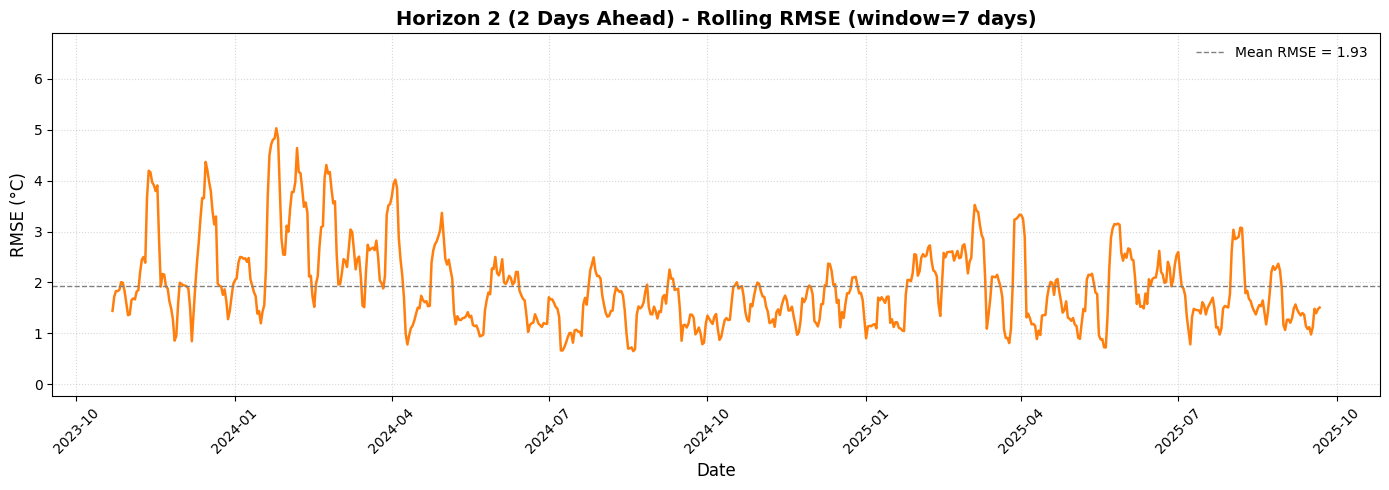

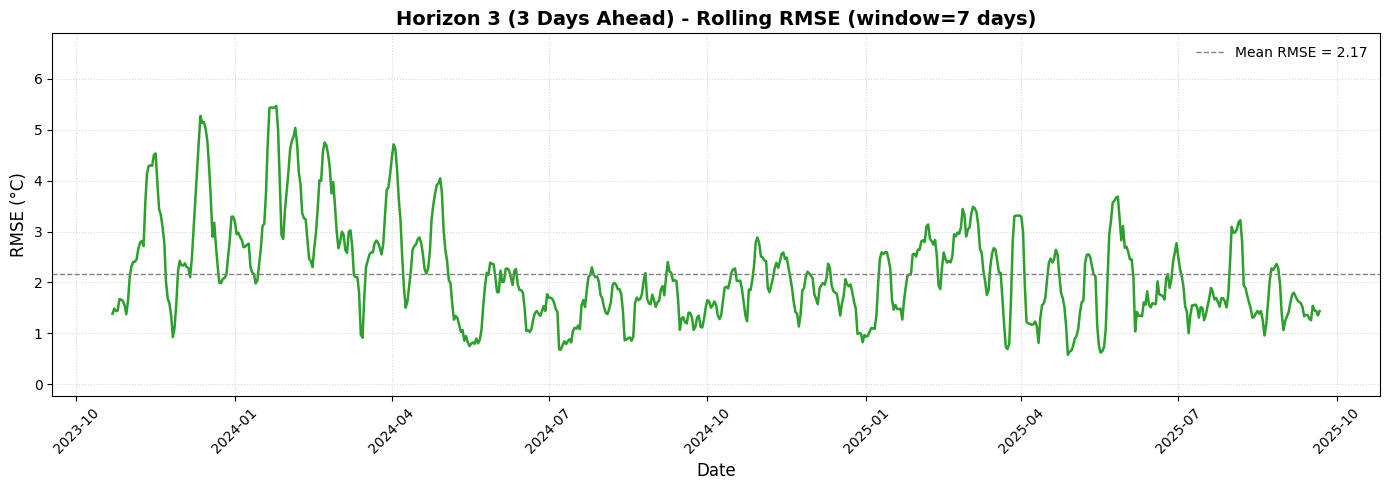

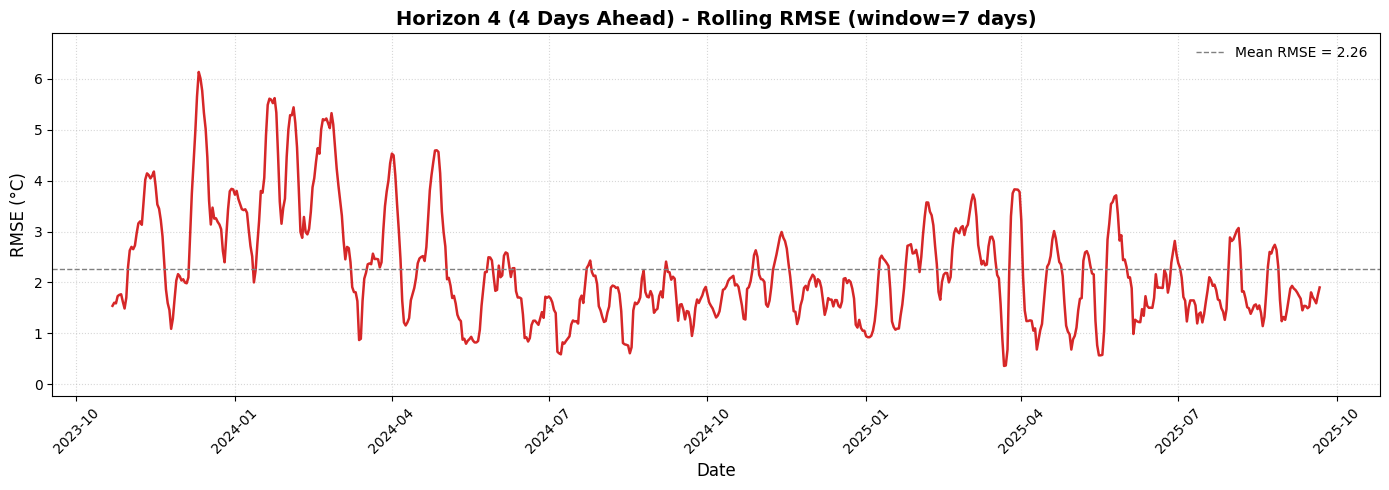

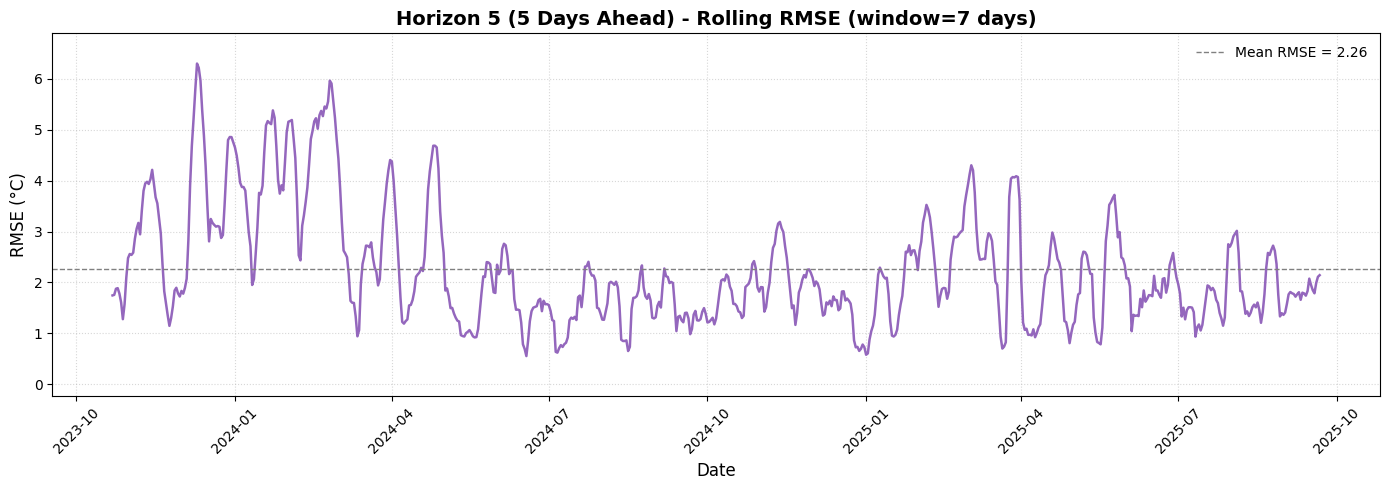

In [14]:
def plot_rmse_over_time(y_test, y_pred_test, window=7, figsize=(14, 5)):
    """
    Vẽ 5 biểu đồ riêng biệt cho RMSE theo thời gian (rolling window),
    với cùng đơn vị (cố định trục Y).
    """
    
    # Kiểm tra input
    assert y_test.shape[1] == 5, "y_test phải có 5 columns"
    assert y_pred_test.shape[1] == 5, "y_pred_test phải có 5 columns"
    assert len(y_test) == len(y_pred_test), "Số samples phải khớp"
    
    horizon_names = [
        'Horizon 1 (Next Day)', 
        'Horizon 2 (2 Days Ahead)', 
        'Horizon 3 (3 Days Ahead)', 
        'Horizon 4 (4 Days Ahead)', 
        'Horizon 5 (5 Days Ahead)'
    ]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    dates = y_test.index

    # Tính rolling RMSE cho tất cả horizons để tìm giới hạn trục Y chung
    all_rmse = []
    for i in range(5):
        y_true = y_test.iloc[:, i]
        y_pred = y_pred_test[:, i]
        rolling_rmse = np.sqrt(((y_true - y_pred)**2).rolling(window).mean())
        all_rmse.append(rolling_rmse)

    # Tính min/max chung cho toàn bộ 5 biểu đồ
    all_values = pd.concat(all_rmse)
    ymin, ymax = all_values.min(), all_values.max()
    margin = (ymax - ymin) * 0.1  # thêm khoảng trống 10%
    ymin -= margin
    ymax += margin

    # Vẽ từng biểu đồ
    for i in range(5):
        plt.figure(figsize=figsize)
        plt.plot(dates, all_rmse[i], color=colors[i], linewidth=1.8)
        
        mean_rmse = all_rmse[i].mean()
        plt.axhline(mean_rmse, color='gray', linestyle='--', linewidth=1,
                    label=f'Mean RMSE = {mean_rmse:.2f}')
        
        plt.title(f'{horizon_names[i]} - Rolling RMSE (window={window} days)', 
                  fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('RMSE (°C)', fontsize=12)
        plt.ylim(ymin, ymax)  # <-- cố định trục Y
        plt.legend(fontsize=10, frameon=False)
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_rmse_over_time(y_test, y_pred_test, window=7)


### 5. UI + Model Maintainence + Realtime predict - Sương Mai
- Sử dụng Gradio 
- Trả lời ngắn gọn câu hỏi của thầy ""The common sense is, if you train model and use it to predict day by day, at some point, the performance will downgrade. When you should retrain your model?""
<br> Lí do phải retrain là gì: ngắn gọn
<br> Ngắn gọn cơ chế maintainnence: có 2 điều kiện khi RMSE vướt ngưỡng + 90 ngày maintain một lần

- Sửa lại READ.ME cái mục cấu trúc project + Vẽ Biểu đồ (trên Canva,... tuỳ) về cấu trúc tổng thể, cách hoạt động của các file (VD như File Monitoring vẽ if/ else block Yes điều kiện retrain => mũi tên file Model_training, vv... )

- Link Video sử dụng UI để dự đoán realtime + show Cloud trên ClearML của mình + kèm link 

### 6. Preprocessing/ Feature Enginering/ Tuning/ Training / Đánh giá kết quả Hourly (dùng luôn lgb)
- Vẽ tổng quát Biểu đồ các step: input, output đầu ra mỗi step, thứ từ các step mũi tên như nào (Vẽ trên canva hay ppt r cop lại đây)
- Preprocessing: 
   + Input: dữ liệu hourly bao nhiêu row, bao cột
   + Drop columns nào, làm gì, ... (Nói là LGB nên cũng không cần xử lí nhiều, chủ yếu bỏ mấy cột thừa)
   + Output: ...
- Feature Engineering:
   + Feature Engineering Hourly:
      - Input: từ Preprocessing (đang bao nhiêu row hourly, bao nhiêu column)
      - Giải thích qua làm gì: 
      - Output: (Còn bao nhiêu cột Daily, Tạo bao nhiêu columns: ngắn gọn cho t với nhóm nhiệt độ thì lấy aggregate mean, max, min, với theo chu kì trong ngày, Nhóm mặt trời thì chỉ lấy mean, với cao nhất trong ngày, ... vv)
   + Feature Engineering Daily Adjusted to new feature in Hourly:
      - Input:
      - Giải thích qua làm gì, thêm cái gì đối với feature mới từ hourly
      - Output:

- Tuning/ Training: 
   + Cho t cái bản tóm tắt metric so sánh (Before training chỉ số các fold, Sau training kết quả train/ test average, perday so sánh với Daily LGB luôn)
   + Trực quan hoá bằng biểu đồ đường, biểu đồ cột so sánh các metric RMSE, MAE, R2 nhìn cho dễ - đừng vẽ mỗi cái một dòng khó nhìn lắm, để hết vào 1 cái khung figure, rồi chia row, column trong đấy để biểu đồ vào


### 7. ONNX 

In [ ]:
def lưu_nháp_kệ_đi():
   pass
   # hàm encoding conditions
   # condition = dp.ConditionsEncoder(is_category = False, encoding_method='target') # False tốt hơn
   # X_train = condition.fit_transform(X_train, X_train['temp'])
   # X_test = condition.transform(X_test)

   # # hàm encoding season
   # season = dp.SeasonClassifier(n_seasons=5, is_category = False) # False tốt hơn
   # X_train = season.fit_transform(X_train, X_train['temp'])
   # X_test = season.transform(X_test)

   # # hàm encoding wind
   # wind = dp.WindCategoryEncoder(is_category= False, n_quantiles= 4) # nếu không dùng kết hợp với condtions thì False tốt hơn
   # X_train = wind.fit_transform(X_train, X_train['temp'])
   # X_test = wind.transform(X_test)

   # # Nháp của t kệ đi
   # # Chạy code so sánh Numeric season vs Category season
   # # hàm encoding conditions
   # condition = dp.ConditionsEncoder(is_category = True, encoding_method='target') # False tốt hơn
   # train_feat = condition.fit_transform(train_feat, train_feat['temp'])
   # test_feat = condition.transform(test_feat)

   # # hàm encoding season
   # season = dp.SeasonClassifier(n_seasons=5, is_category = True) # False tốt hơn
   # train_feat = season.fit_transform(train_feat, train_feat['temp'])
   # test_feat = season.transform(test_feat)

   # # hàm encoding wind
   # wind = dp.WindCategoryEncoder(is_category= True) # nếu không dùng kết hợp với condtions thì False tốt hơn
   # train_feat = wind.fit_transform(train_feat, train_feat['temp'])
   # test_feat = wind.transform(test_feat)

   # # Chia X, y riêng biệt
   # X_train = train_feat.drop(columns= target_col)
   # y_train = train_feat[target_col]

   # X_test = test_feat.drop(columns= target_col)
   # y_test = test_feat[target_col]

   # print(f"Train: {X_train.shape, y_train.shape}, Test: {X_test.shape, y_test.shape}")

   # # Chạy code so sánh Numeric wind_cateogry vs Category wind_category


   # # Chạy code so sánh Numeric conditions vs Category conditions




   # from optuna.pruners import MedianPruner
   # from lightgbm import early_stopping

   # # ===  Tạo hàm objective ===
   # def objective(trial):
   #     boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])

   #     params = {
   #         'boosting_type': boosting_type,
   #         'max_depth': trial.suggest_int('max_depth', 3, 12),
   #         'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
   #         'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.3),
   #         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
   #         'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
   #         'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True),
   #         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
   #         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
   #         'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
   #         'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
   #         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
   #         'max_bin': trial.suggest_int('max_bin', 64, 512),
   #         'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),

   #         'objective': 'regression',
   #         'metric': 'rmse',
   #         'random_state': 42,
   #         'n_jobs': -1,
   #         'verbosity': -1  # 
   #     }

   #     if boosting_type == 'dart':
   #         params['drop_rate'] = trial.suggest_float('drop_rate', 0.05, 0.5)
   #         params['skip_drop'] = trial.suggest_float('skip_drop', 0.3, 0.7)

   #     # === TimeSeriesSplit CV ===
   #     cv = TimeSeriesSplit(n_splits=5)
   #     rmse_scores = []

   #     for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_sel)):
   #         X_tr, X_val = X_train_sel.iloc[train_idx], X_train_sel.iloc[val_idx]
   #         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

   #         # Fit riêng cho từng cột output
   #         models_fold = {}
   #         y_pred_val = pd.DataFrame(index=y_val.index, columns=y_val.columns)

   #         for col in y_train.columns:
   #             model = LGBMRegressor(**params)
   #             model.fit(
   #                 X_tr, y_tr[col],
   #                 eval_set=[(X_val, y_val[col])],
   #                 eval_metric='rmse',
   #                 callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
       
   #             )
   #             models_fold[col] = model
   #             y_pred_val[col] = model.predict(X_val)

   #         metrics = evaluate_multi_output(y_val, y_pred_val)
   #         rmse_fold = metrics["average"]["RMSE"]
   #         rmse_scores.append(rmse_fold)

   #         # Báo cho Optuna biết tiến độ trial
   #         trial.report(rmse_fold, step=fold_idx)
   #         if trial.should_prune():
   #             raise optuna.TrialPruned()

   #     mean_rmse = np.mean(rmse_scores)
   #     return mean_rmse

   # # === 3️ Cấu hình Pruner ===
   # pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=2, interval_steps=1)

   # # === 4 Chạy Optuna Study ===
   # sampler = optuna.samplers.TPESampler(seed=42)
   # study_grad = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)
   # study_grad.optimize(objective, n_trials=500, show_progress_bar=True)

   # # === 5️ In kết quả ===
   # print(" Best parameters:", study_grad.best_trial.params)
   # print(" Best RMSE (Optuna CV):", study_grad.best_value)

   # # === 6️ Fit lại với best params cho từng output ===
   # best_params = study_grad.best_trial.params
   # final_models = {}
   # y_pred_train = pd.DataFrame(index=y_train.index, columns=y_train.columns)
   # y_pred_test = pd.DataFrame(index=y_test.index, columns=y_test.columns)

   # for col in y_train.columns:
   #     model = LGBMRegressor(**best_params)
   #     model.fit(
   #         X_train_sel, y_train[col],
   #         eval_set=[(X_test_sel, y_test[col])],
   #         eval_metric='rmse',
   #         callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
   #     )

   #     final_models[col] = model
   #     y_pred_train[col] = model.predict(X_train_sel)
   #     y_pred_test[col] = model.predict(X_test_sel)

   # # Evaluate
   # bestGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)
   # bestGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)

   # print("Best Model - Train metrics (average):", bestGrad_train_metrics["average"])
   # print("Best Model - Test metrics (average):", bestGrad_test_metrics["average"])
